In [1]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import signal, stats
import re
import sys
import os
import mne
import mne_connectivity
import IPython
import seaborn as sns
import scipy
import joblib
import h5io
import dask.array as da 
import itertools
from plotnine import *
import pickle
import statsmodels
from statsmodels import stats
from statsmodels.stats import multitest
import tensorpac as tp
from scipy.ndimage import label

In [2]:
from scipy.ndimage import label

def find_largest_cluster_mask(matrix):

    if not matrix.any():
        return matrix
    
    # Label the connected components in the inverted matrix
    labeled_array, num_features = label(matrix)
    
    # Find the size of each connected component
    component_sizes = np.bincount(labeled_array.ravel())
    
    # Exclude the background component (label 0)
    largest_component_label = component_sizes[1:].argmax() + 1
    
    # Create a mask for the largest component
    largest_cluster_mask = (labeled_array == largest_component_label).astype(int)
    
    return largest_cluster_mask

In [3]:
def find_pair_pac_pvalue(p):

    # create average pac and average perm pac by averaging over trials
    average_perm_pac = p.surrogates.mean(-1)
    average_pac = p.pac.mean(-1)

    # find the uncorrected p values
    tmp = average_pac <= average_perm_pac
    uncorrected_p = np.sum(tmp, axis = 0)/200

    # create a mask of largest sig cluster
    mask = uncorrected_p.copy()
    mask[uncorrected_p > .01] = 0
    mask[uncorrected_p <= .01] = 1
    large_cluster = find_largest_cluster_mask(mask)

    if np.sum(large_cluster) >= 10:

        # sum pac values in the largest cluster for each surrogate
        perm_test_stat = np.zeros((200, 1))
        for i in range(200):
            tmp = average_perm_pac[i, :, :]
            tmp[large_cluster == 0] = 0
            perm_test_stat[i] = np.sum(tmp)  

        # get summed pac value of the real data
        real_pac = average_pac.copy()
        real_pac[large_cluster == 0] = 0
        test_stat = np.sum(real_pac) 

        # get the p value
        pval = np.sum(test_stat <= perm_test_stat)/200
    else:
        # get summed pac value of the real data
        real_pac = average_pac.copy()
        real_pac[large_cluster == 0] = 0
        test_stat = np.sum(real_pac) 
        pval = 1        


    return test_stat, pval, large_cluster

In [2]:
# read in df
to_ofc_df = pd.read_csv('/home/brooke/pacman/connectivity/scripts/pac/compiled_approach_to_ofc_results.csv')

In [3]:
to_ofc_sig_df = to_ofc_df[to_ofc_df['pval'] < 0.01]

In [4]:
to_ofc_df['sig'] = to_ofc_df['pval'] < 0.01

In [5]:
to_ofc_sig_df['roi_pair'].value_counts()

roi_pair
ofc_dlpfc     141
ofc_insula    117
ofc_hc         94
ofc_amyg       74
ofc_cing       59
Name: count, dtype: int64

In [6]:
to_ofc_df['roi_pair'].value_counts()

roi_pair
ofc_dlpfc     449
ofc_insula    439
ofc_hc        324
ofc_amyg      244
ofc_cing      200
Name: count, dtype: int64

## From OFC

In [7]:
# read in df
from_ofc_df = pd.read_csv('/home/brooke/pacman/connectivity/scripts/pac/compiled_approach_from_ofc_results.csv')

In [8]:
from_ofc_sig_df = from_ofc_df[from_ofc_df['pval'] < 0.01]

In [9]:
from_ofc_df['sig'] = from_ofc_df['pval'] < 0.01

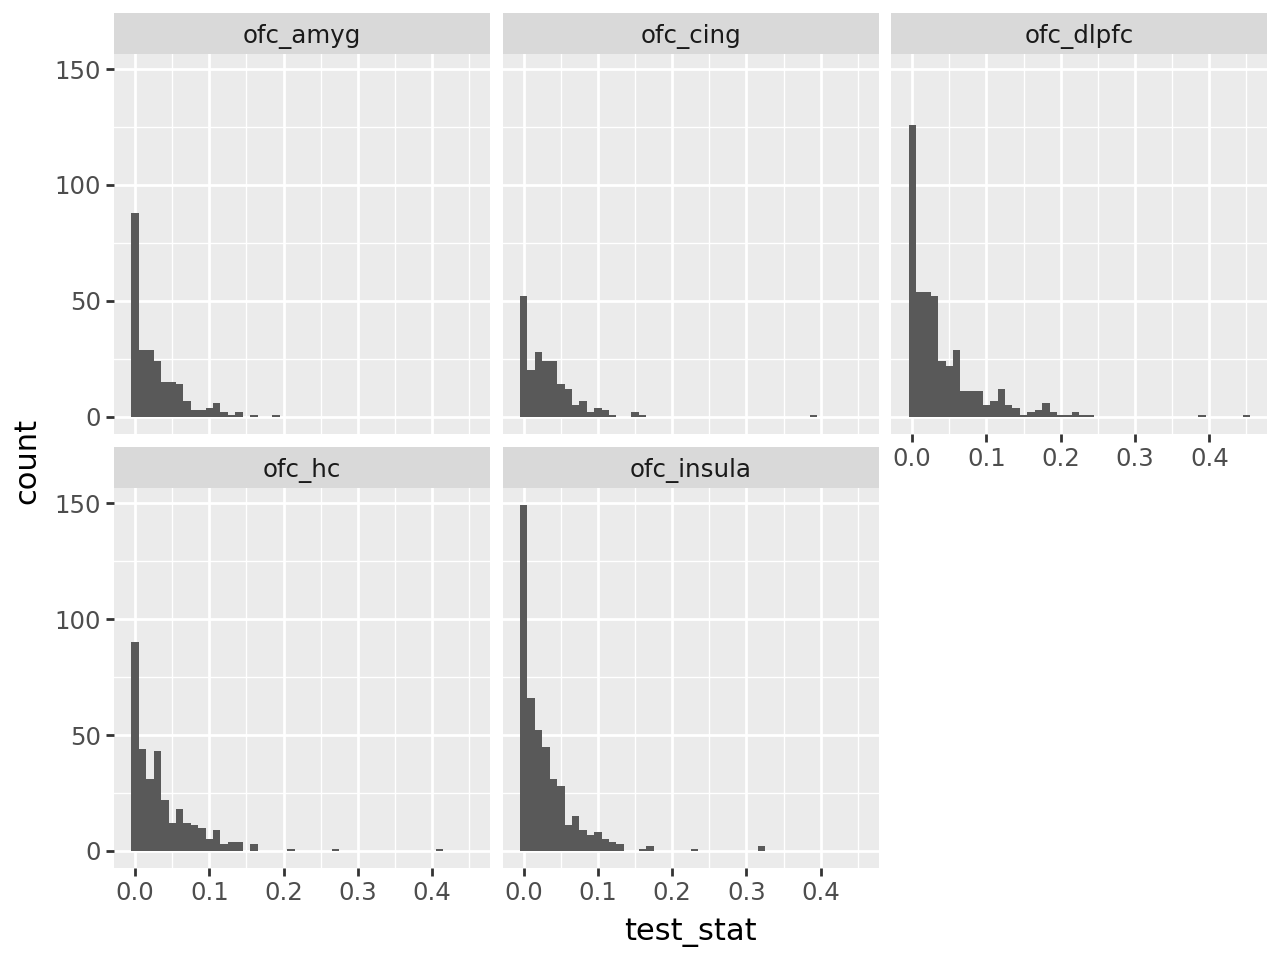

In [11]:
(
    ggplot(from_ofc_df, aes(x = 'test_stat'))
    + geom_histogram(binwidth = .01)
    + facet_wrap('~roi_pair')
)

In [36]:
from_ofc_df

subject   elec1    elec2  test_stat   pval              pairs   roi_pair  \
0     BJH025   A1-A2  B10-B11   0.048114  0.005   A1-A2_to_B10-B11   ofc_cing   
1     BJH025   A1-A2  B12-B13   0.120658  0.000   A1-A2_to_B12-B13  ofc_dlpfc   
2     BJH025   A1-A2  B13-B14   0.013097  1.000   A1-A2_to_B13-B14  ofc_dlpfc   
3     BJH025   A1-A2  B14-B15   0.044039  0.000   A1-A2_to_B14-B15  ofc_dlpfc   
4     BJH025   A1-A2  B15-B16   0.122112  0.000   A1-A2_to_B15-B16  ofc_dlpfc   
...      ...     ...      ...        ...    ...                ...        ...   
1600  BJH025  A9-A10  GL4-GL5   0.004370  1.000  A9-A10_to_GL4-GL5   ofc_amyg   
1601  BJH025  A9-A10  GL5-GL6   0.000000  1.000  A9-A10_to_GL5-GL6   ofc_amyg   
1602  BJH025  A9-A10  GR3-GR4   0.093850  0.005  A9-A10_to_GR3-GR4   ofc_amyg   
1603  BJH025  A9-A10  GR4-GR5   0.000000  1.000  A9-A10_to_GR4-GR5   ofc_amyg   
1604  BJH025   B1-B2    C1-C2   0.055897  0.000     B1-B2_to_C1-C2   ofc_amyg   

                   metric    sig  
0     Imaginary Coherence   True  
1     Imaginary Coherence   True  
2     Imaginary Coherence  False  
3     Imaginary Coherence   True  
4     Imaginary Coherence   True  
...                   ...    ...  
1600  Imaginary Coherence  False  
1601  Imaginary Coherence  False  
1602  Imaginary Coherence   True  
1603  Imaginary Coherence  False  
1604  Imaginary Coherence   True  

[1605 rows x 9 columns]

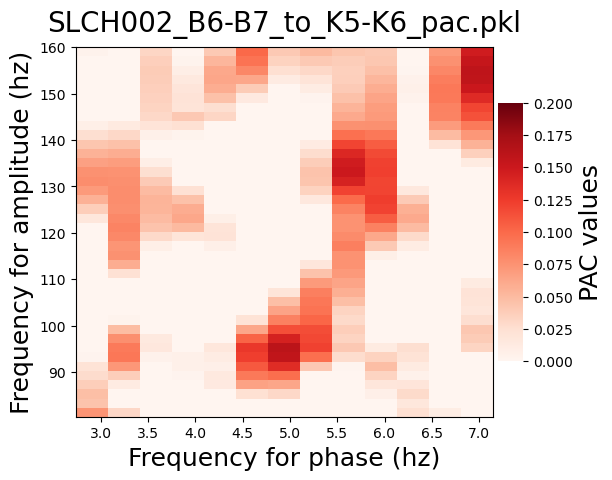

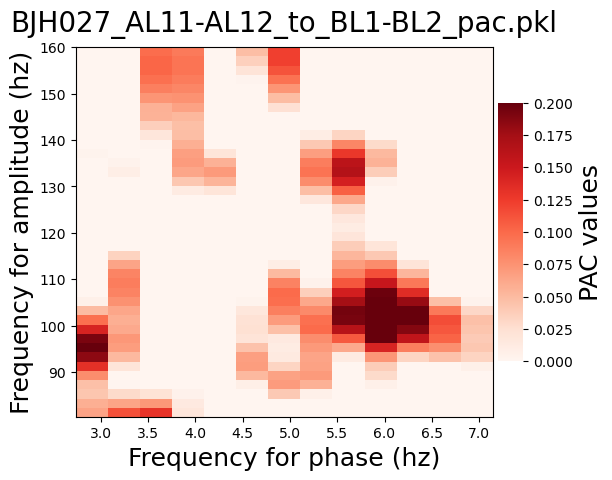

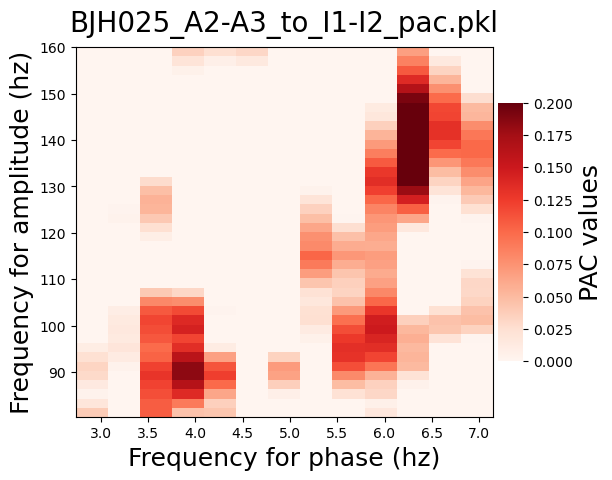

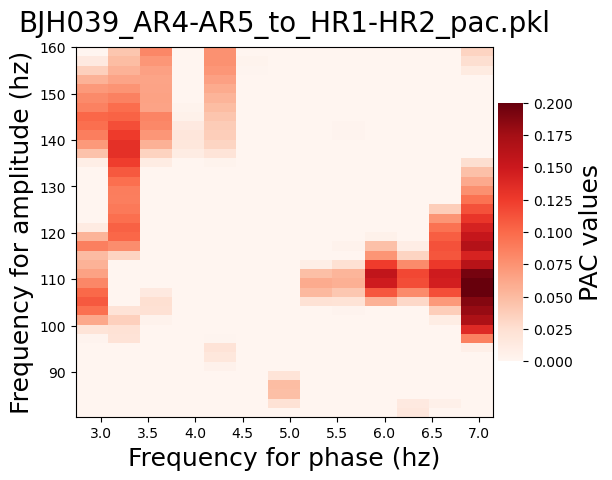

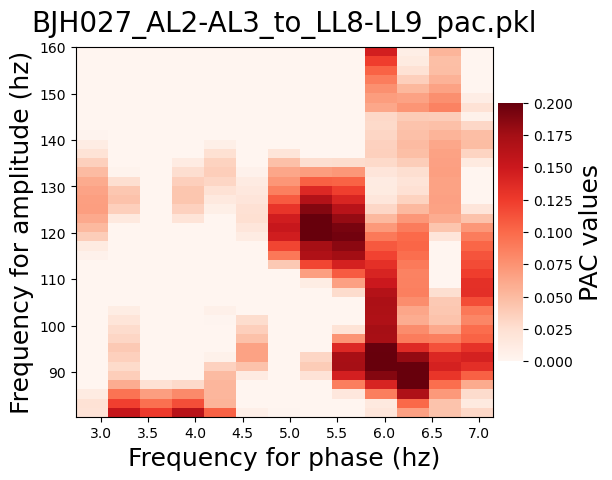

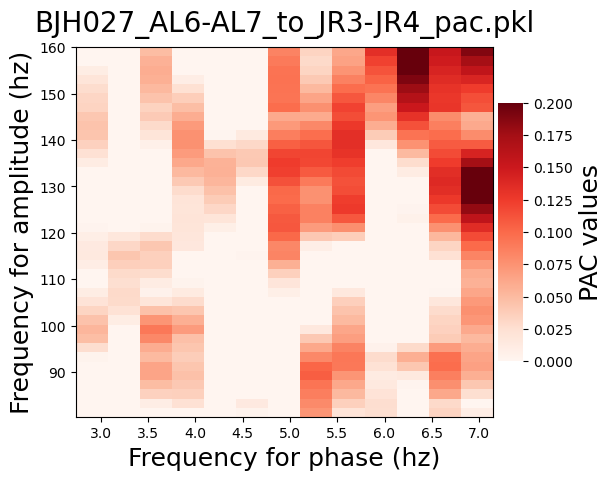

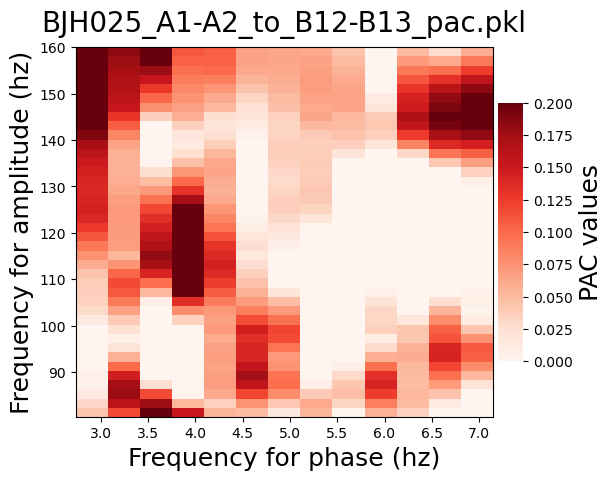

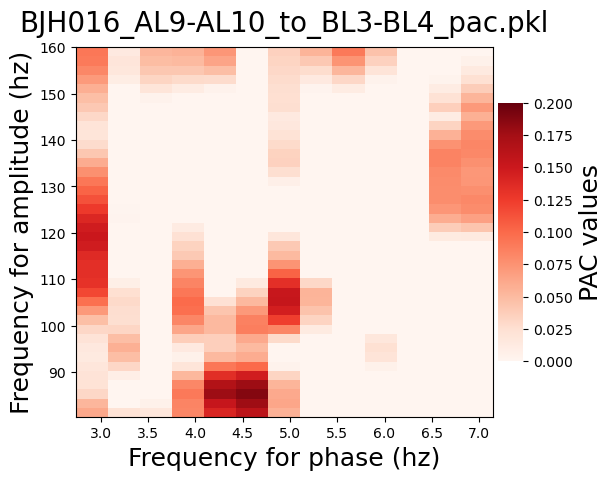

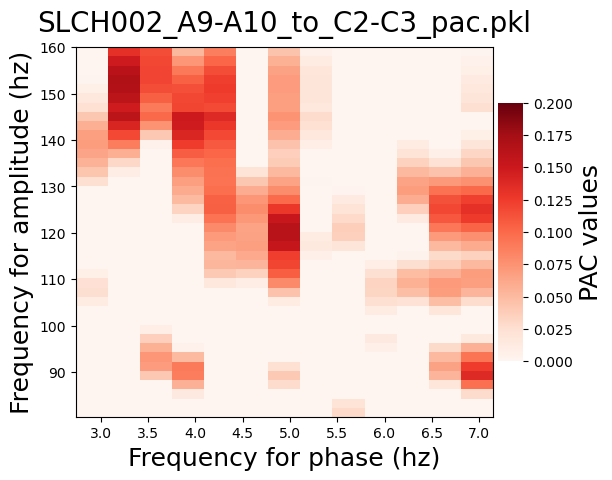

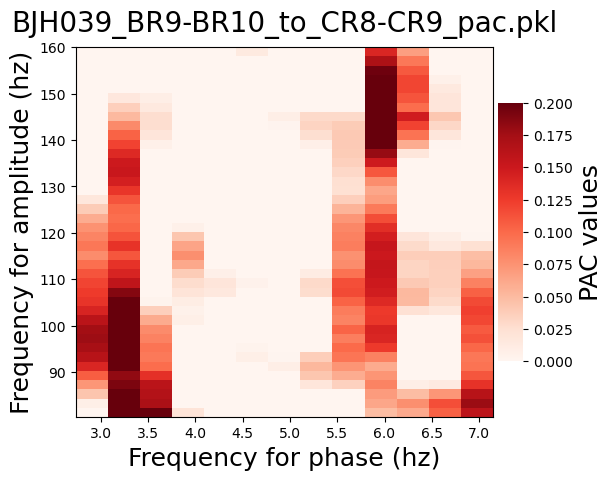

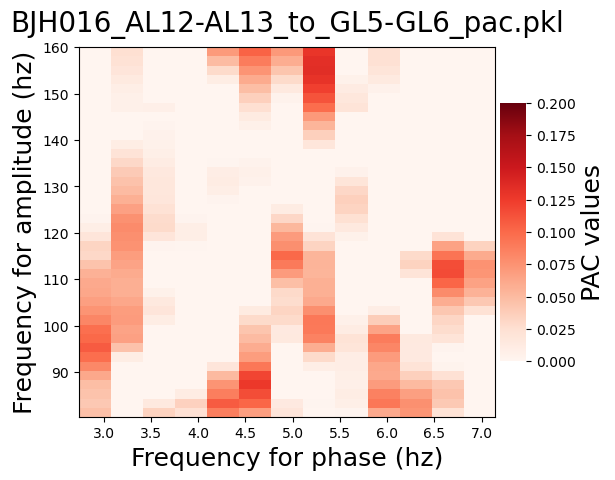

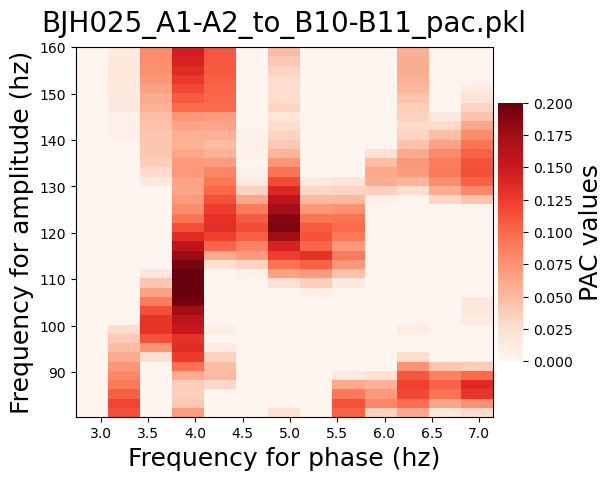

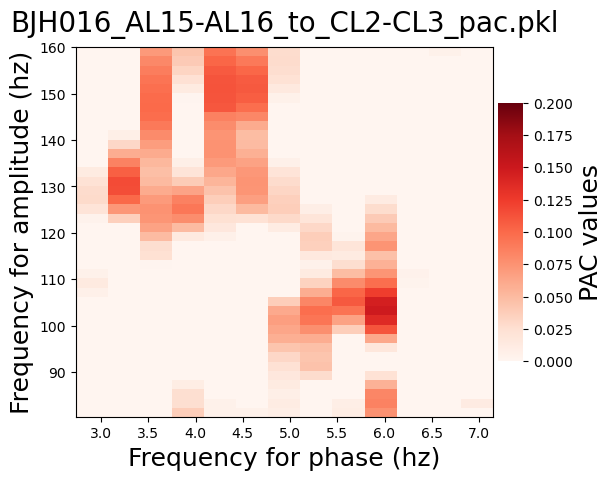

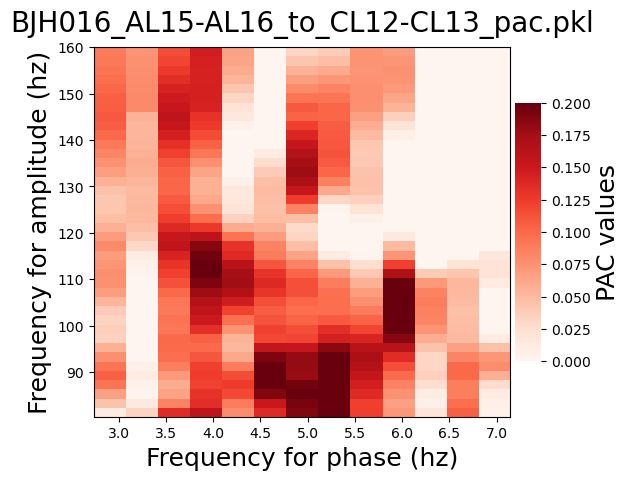

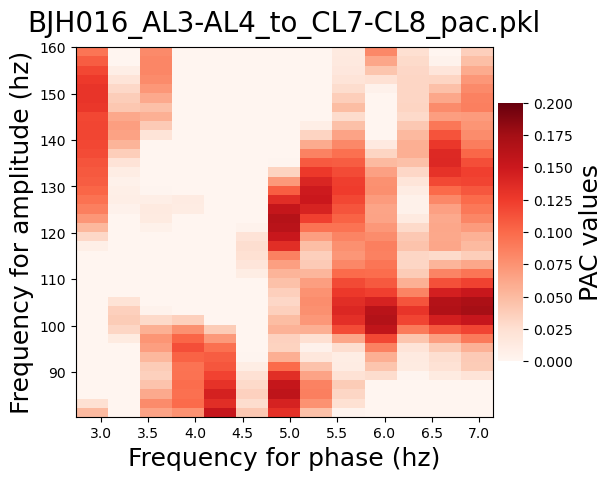

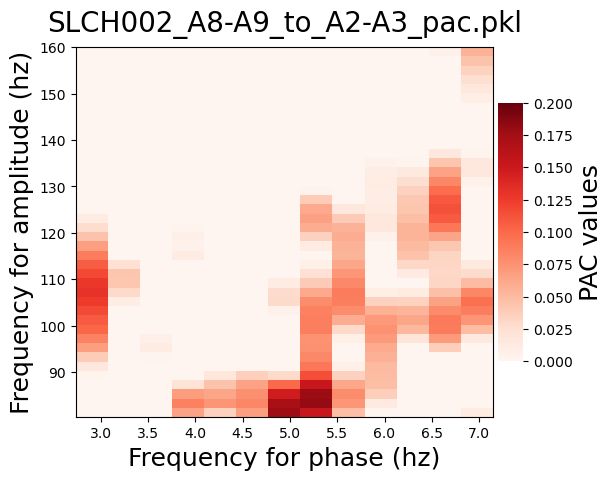

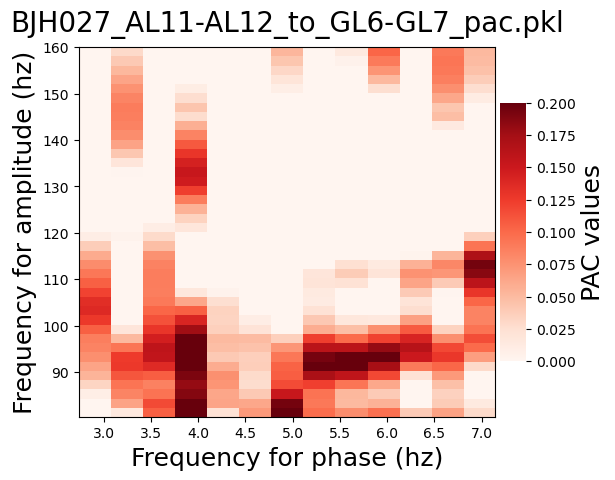

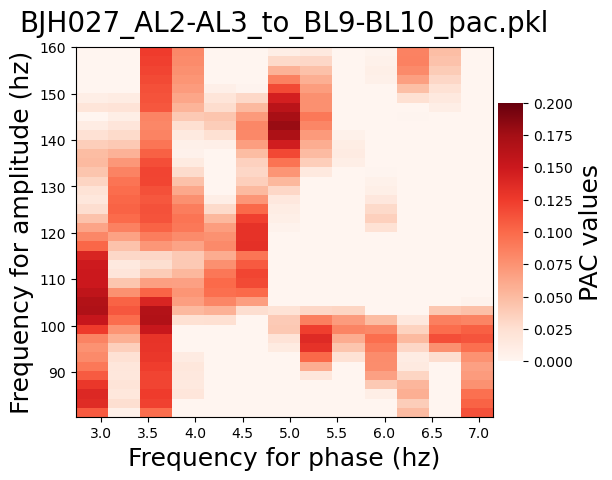

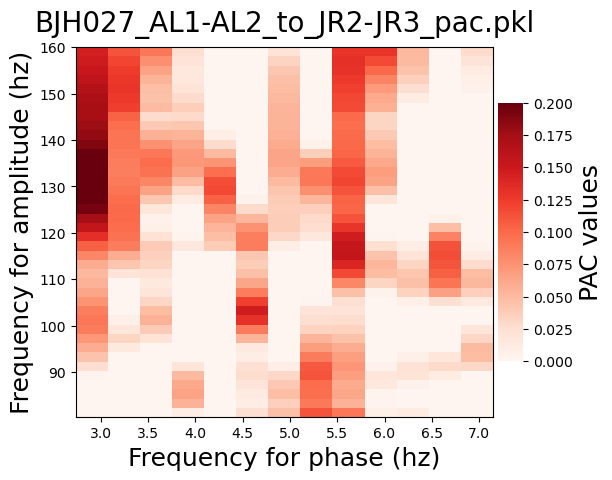

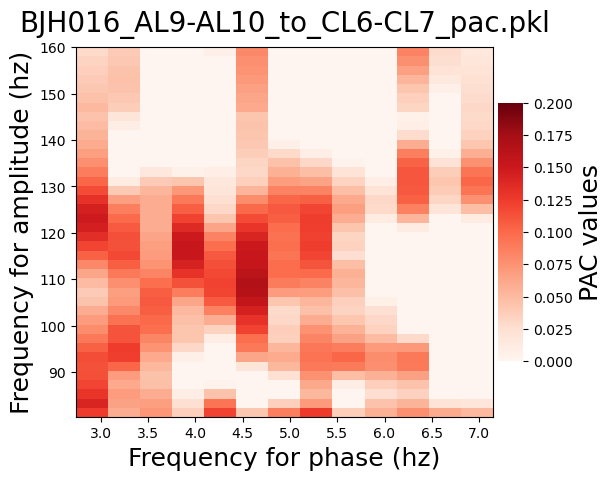

In [12]:
t7_folder = '/media/brooke/T7/pacman/connectivity/pac/approach/from_ofc'

sampled_df = from_ofc_sig_df.sample(n=20)

for i, row in sampled_df.iterrows():
    sub = row['subject']
    elec1 = row['elec1']
    elec2 = row['elec2']
    file = f'{sub}_{elec1}_to_{elec2}_pac.pkl'
    with open(f'{t7_folder}/{file}', 'rb') as f:
        p = pickle.load(f)

        xpac = (p.pac - p.surrogates.mean(axis = 0)) / np.std(p.surrogates, axis = 0)
        p.comodulogram(xpac.mean(-1), title = file, cmap='Reds', vmin=0, vmax = .2,
                    fz_labels=18, fz_title=20, fz_cblabel=18)
        p.show()
        

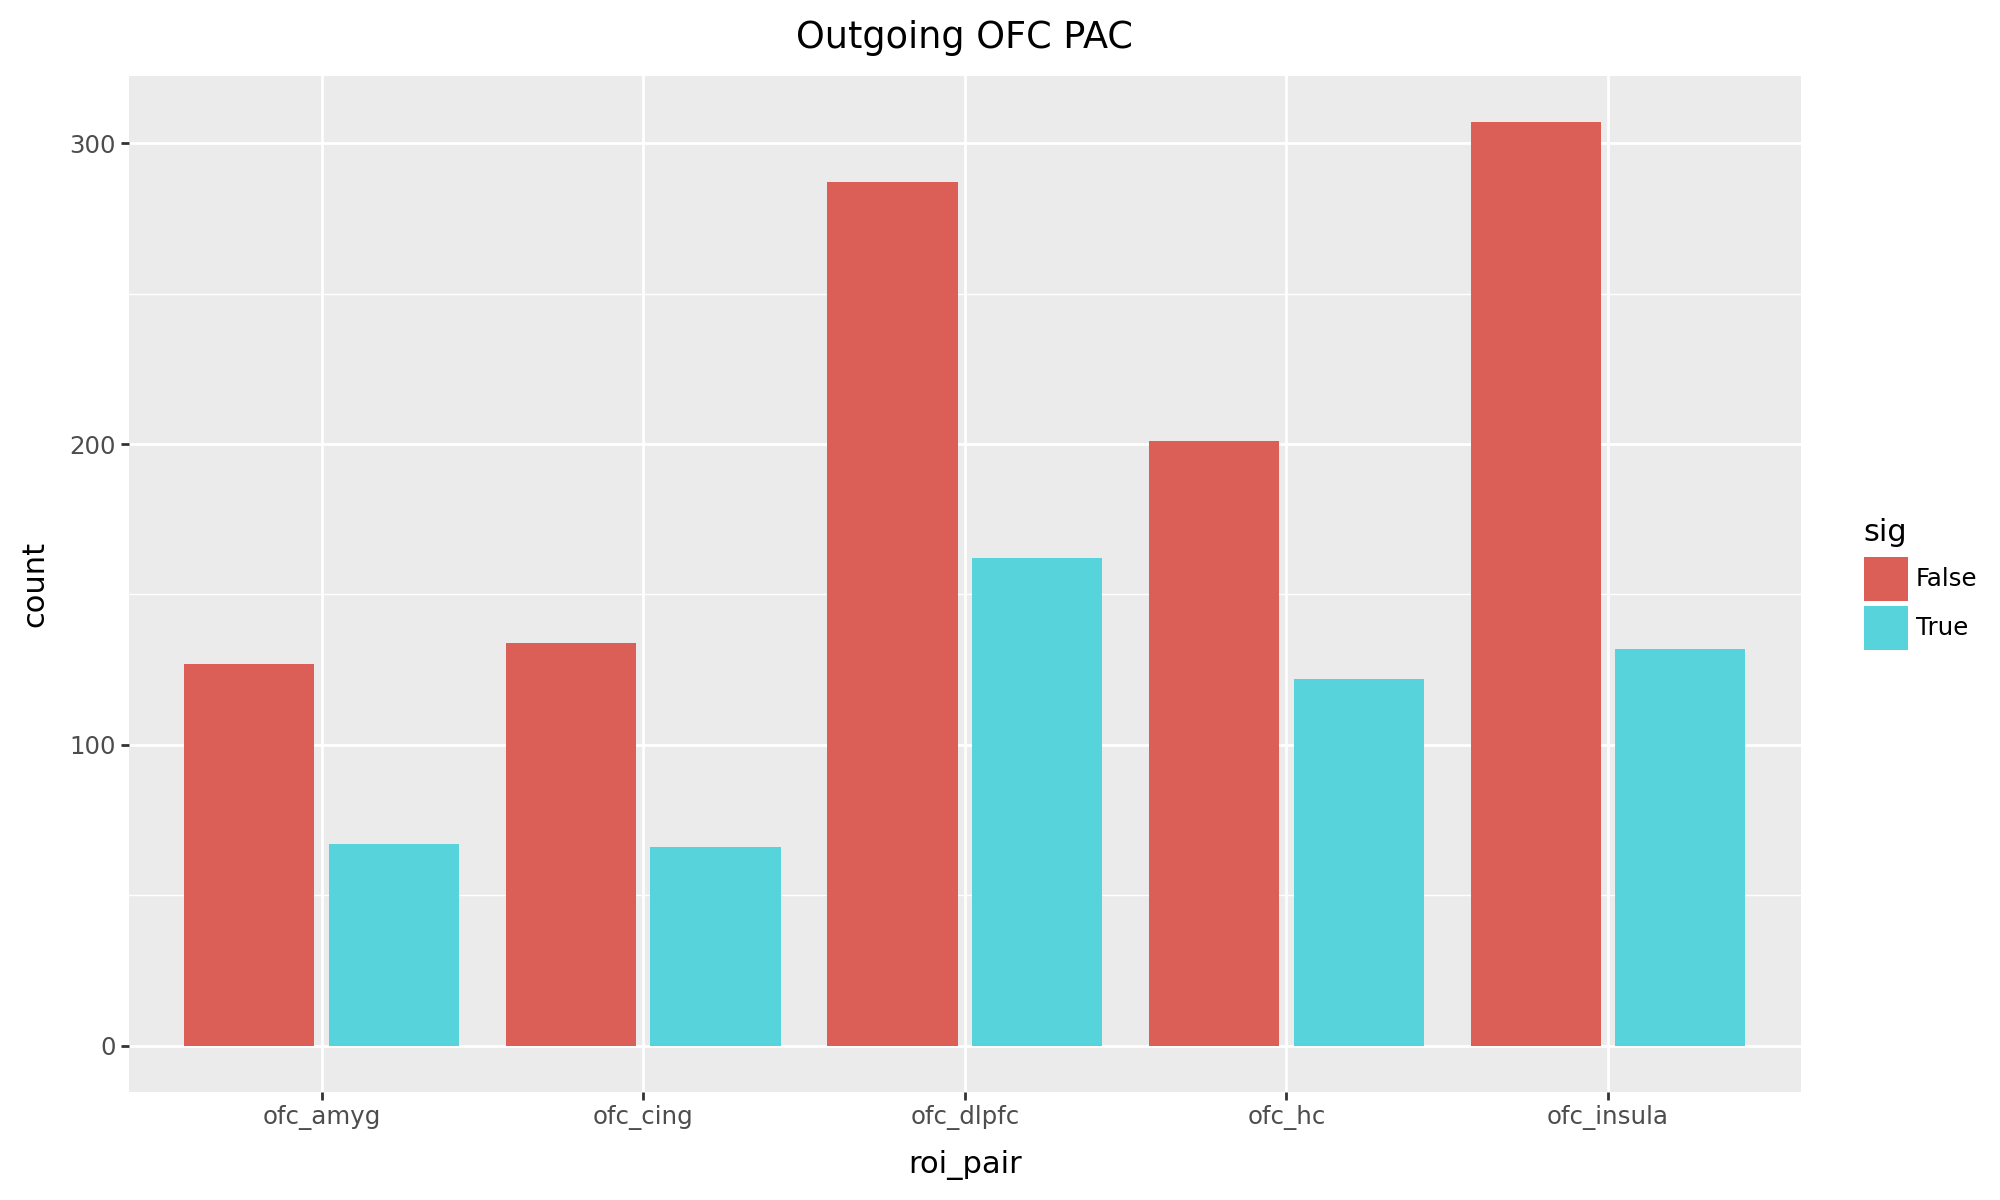

In [64]:
(
    ggplot(from_ofc_df, aes(x = 'roi_pair', fill = 'sig'))
    + geom_bar(position = position_dodge2())
    + theme(figure_size=(10, 6))
    + ggtitle("Outgoing OFC PAC")
)

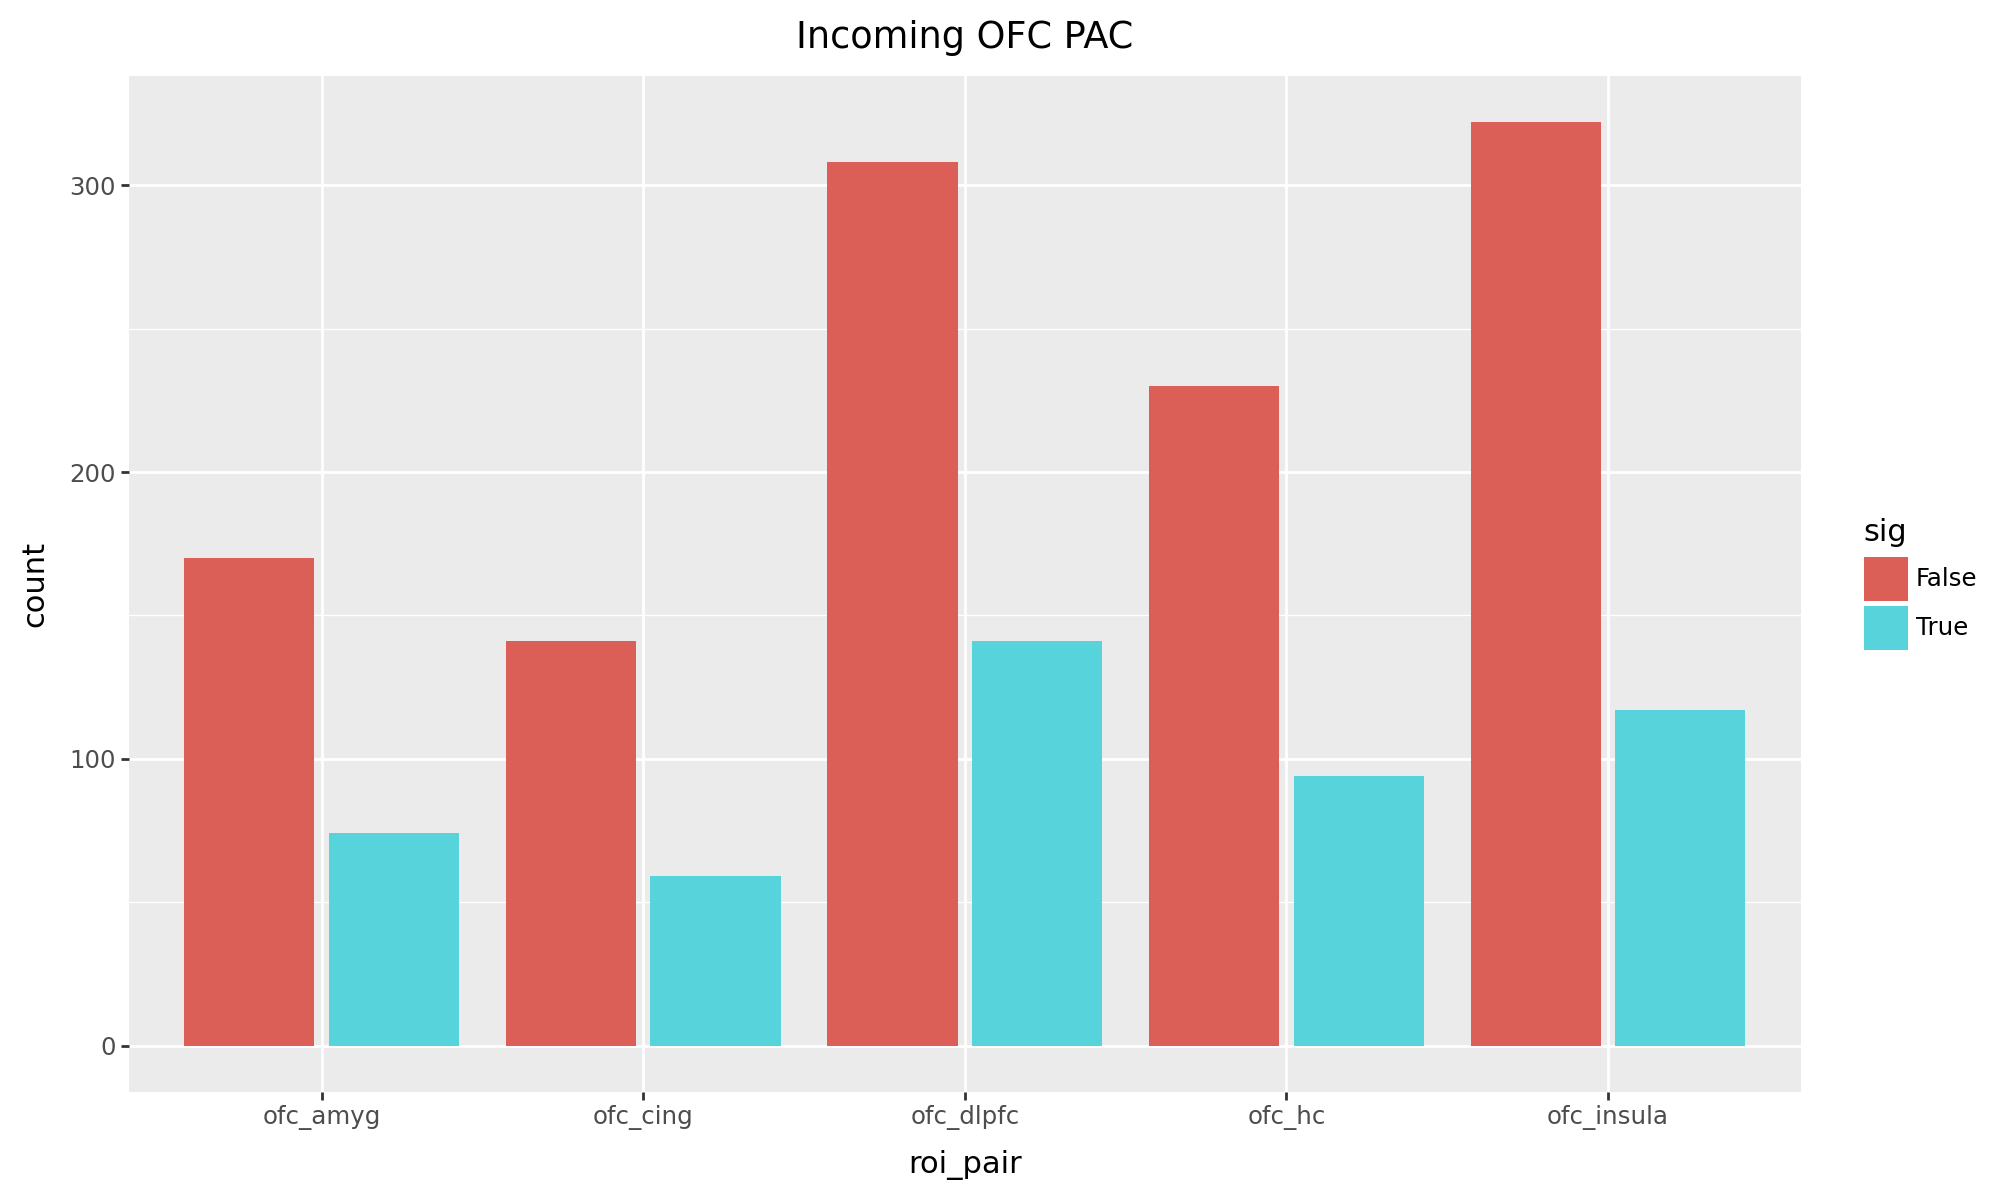

In [44]:
(
    ggplot(to_ofc_df, aes(x = 'roi_pair', fill = 'sig'))
    + geom_bar(position = position_dodge2())
    + theme(figure_size=(10, 6))
    + ggtitle("Incoming OFC PAC")
)

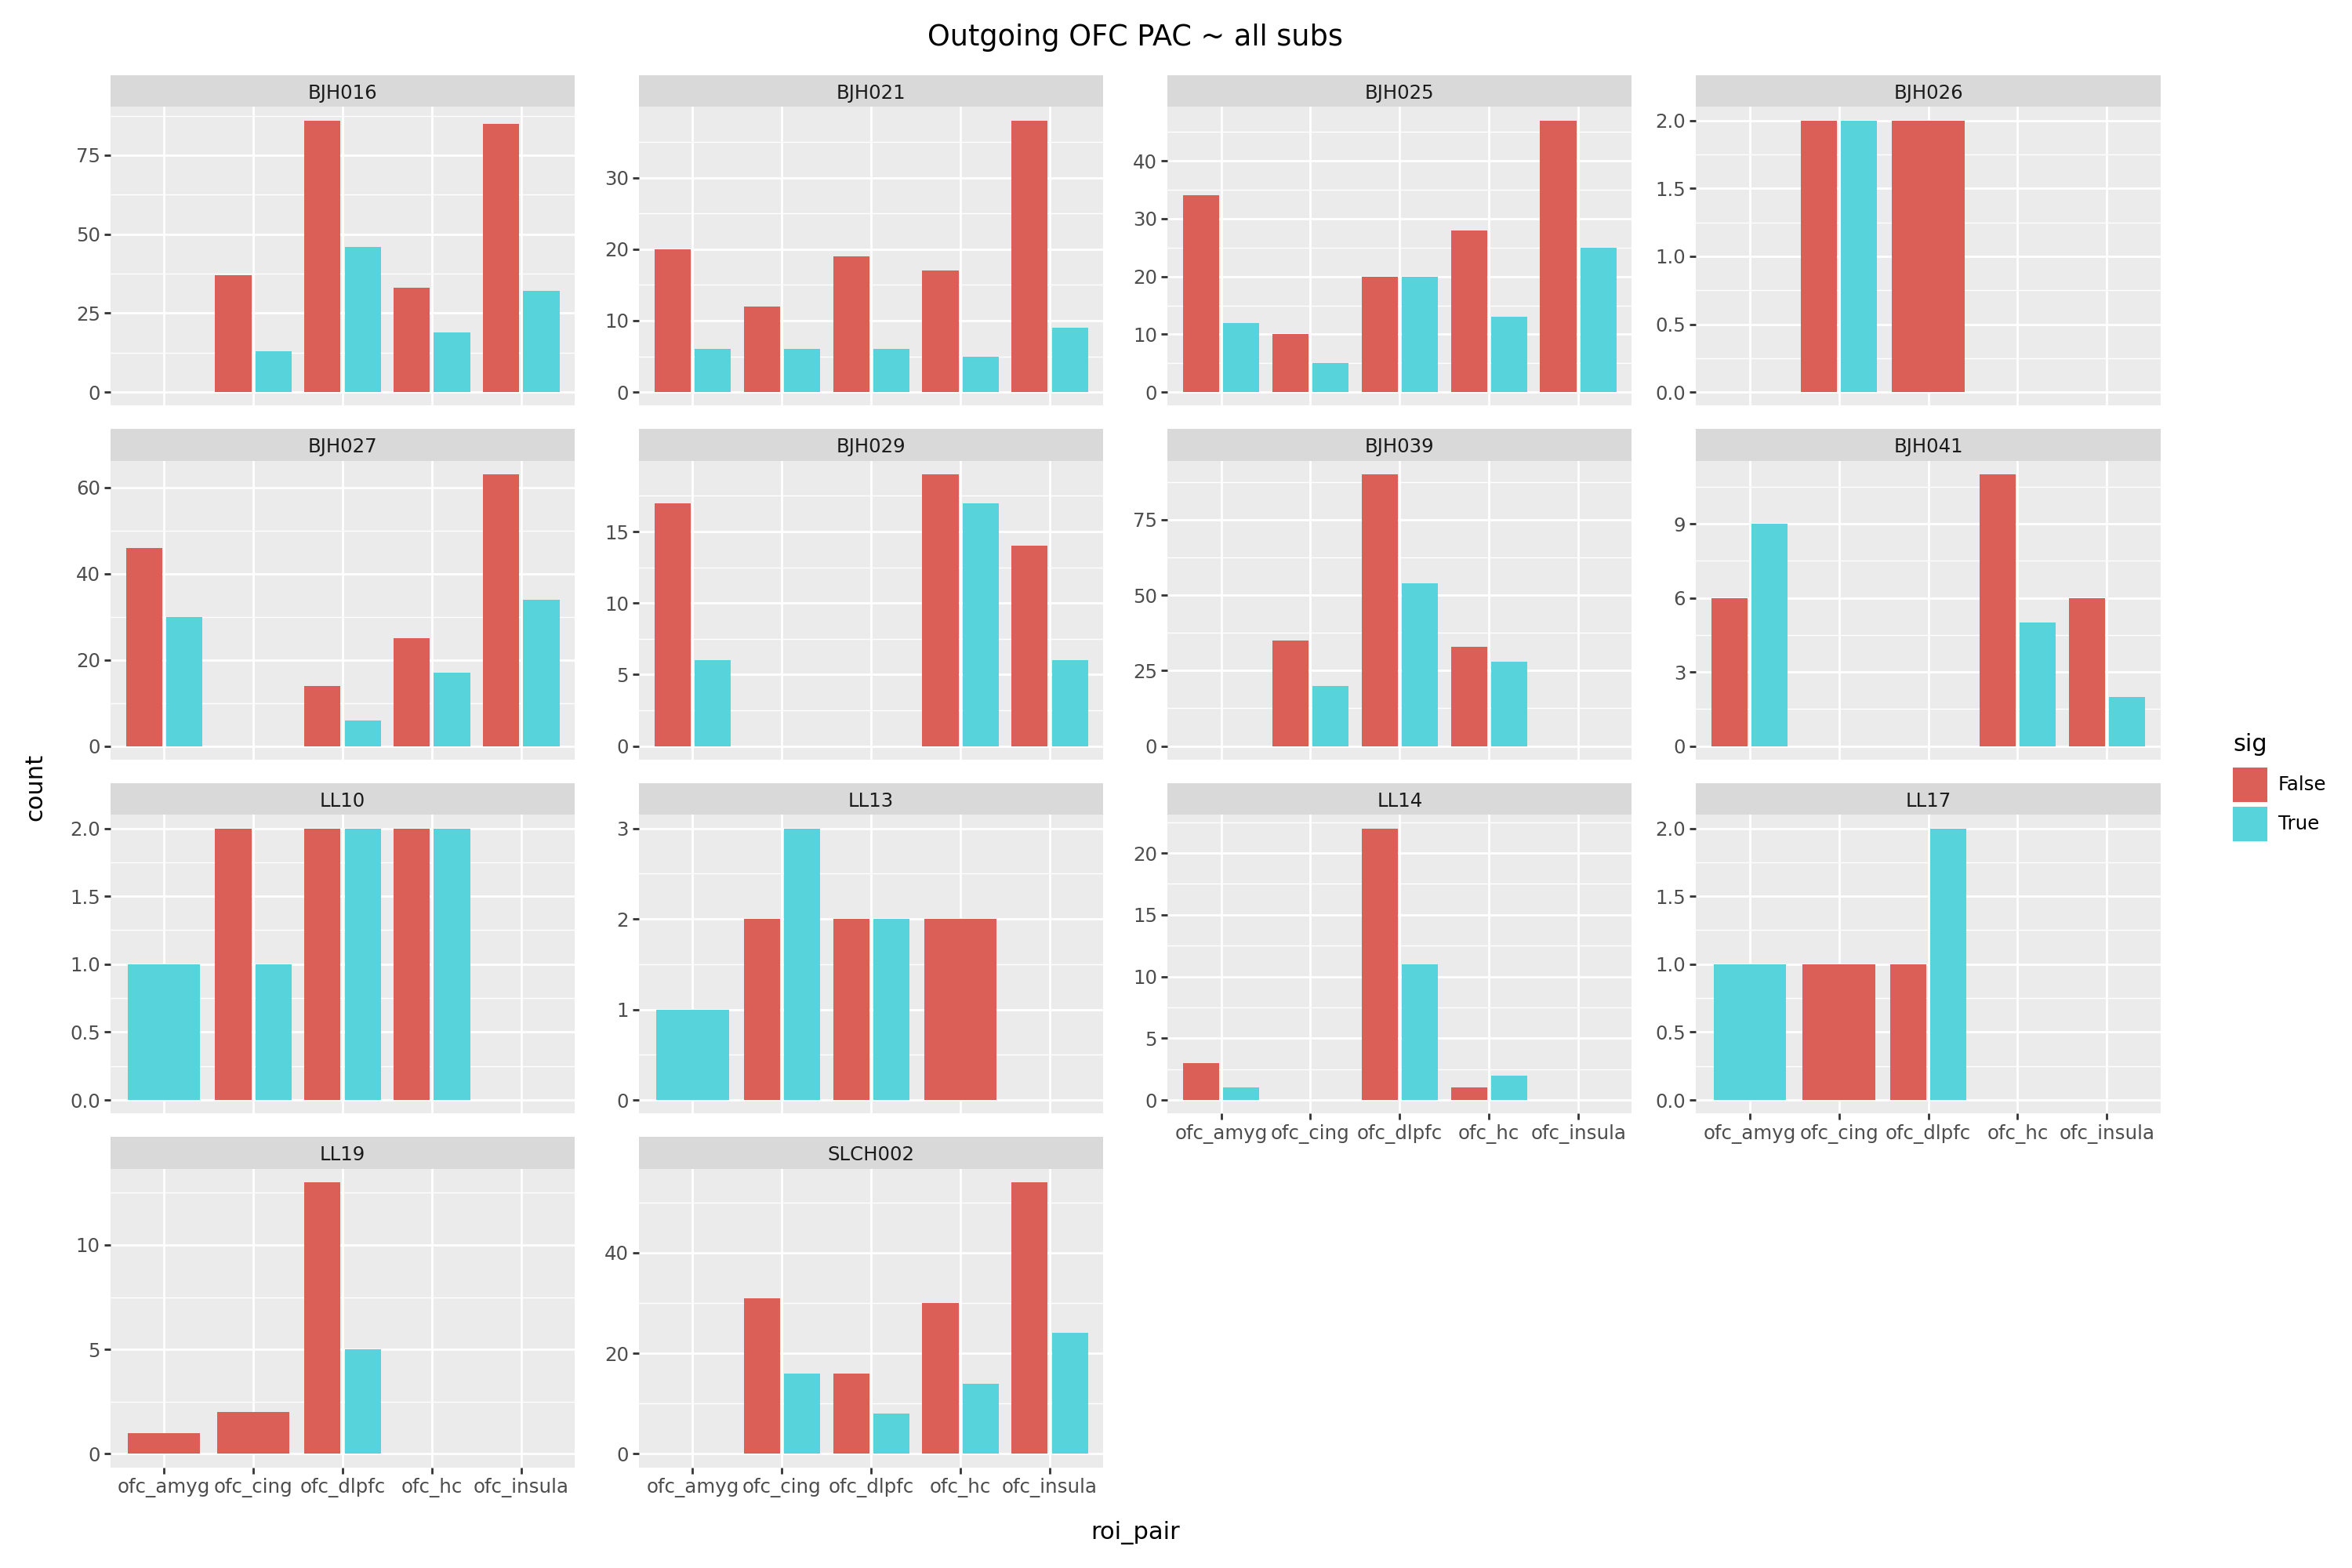

In [45]:
(
    ggplot(from_ofc_df, aes(x = 'roi_pair', fill = 'sig'))
    + geom_bar(position = position_dodge2())
    + facet_wrap('subject', scales = 'free_y')
    + theme(figure_size=(15, 10))
    + ggtitle("Outgoing OFC PAC ~ all subs")
)

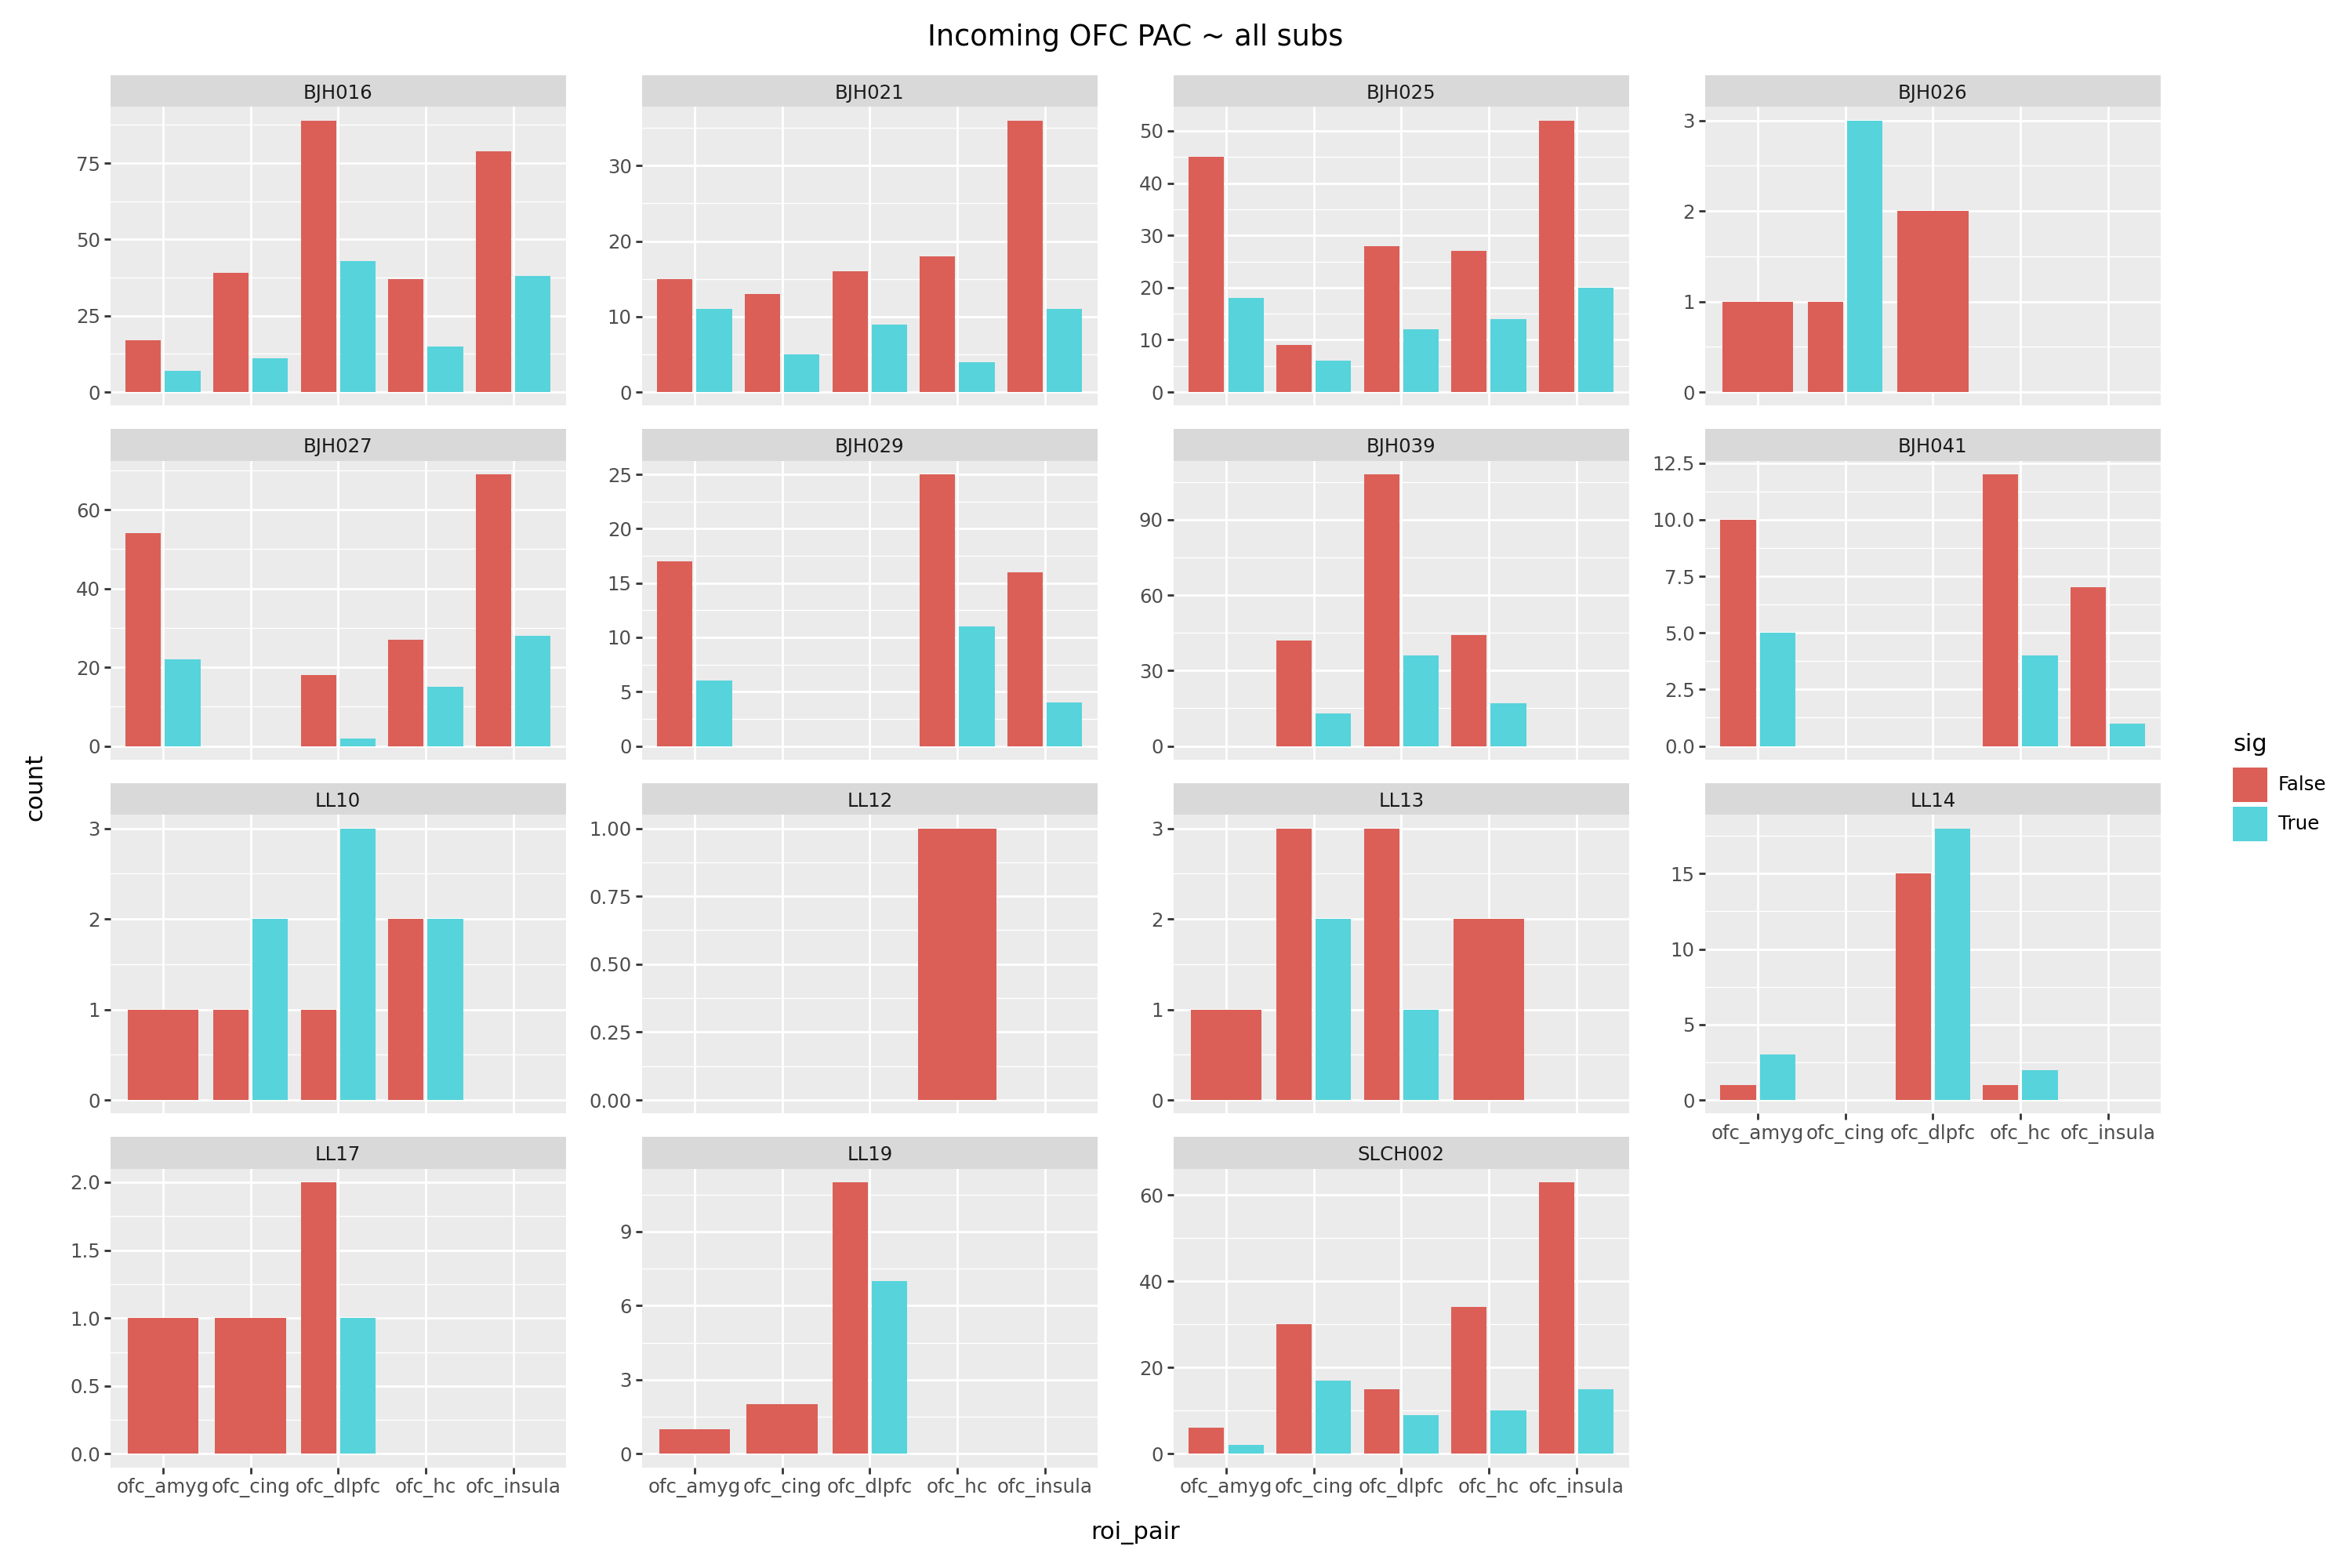

In [46]:
(
    ggplot(to_ofc_df, aes(x = 'roi_pair', fill = 'sig'))
    + geom_bar(position = position_dodge2())
    + facet_wrap('subject', scales = 'free_y')
    + theme(figure_size=(15, 10))
    + ggtitle("Incoming OFC PAC ~ all subs")
)

In [48]:
to_ofc_sig_16_df = to_ofc_sig_df[((to_ofc_sig_df['subject'] == 'BJH016') & (to_ofc_sig_df['roi_pair'] == 'ofc_dlpfc'))]
from_ofc_sig_16_df = from_ofc_sig_df[((from_ofc_sig_df['subject'] == 'BJH016') & (from_ofc_sig_df['roi_pair'] == 'ofc_dlpfc'))]

t7_folder = '/media/brooke/T7/pacman/connectivity/pac/approach/'
to_cluster = np.zeros((40, 13))
for idx, row in to_ofc_sig_16_df.iterrows():
    file = f"{row['subject']}_{row['elec2']}_to_{row['elec1']}_pac.pkl"
    with open(f'{t7_folder}/to_ofc/{file}', 'rb') as f:
        p = pickle.load(f)

    test_stat, pval, cluster_tmp= find_pair_pac_pvalue(p)
    to_cluster = to_cluster + cluster_tmp


from_cluster = np.zeros((40, 13))
for idx, row in from_ofc_sig_16_df.iterrows():
    file = f"{row['subject']}_{row['elec1']}_to_{row['elec2']}_pac.pkl"
    with open(f'{t7_folder}/from_ofc/{file}', 'rb') as f:
        p = pickle.load(f)

    test_stat, pval, cluster_tmp= find_pair_pac_pvalue(p)
    from_cluster = from_cluster + cluster_tmp


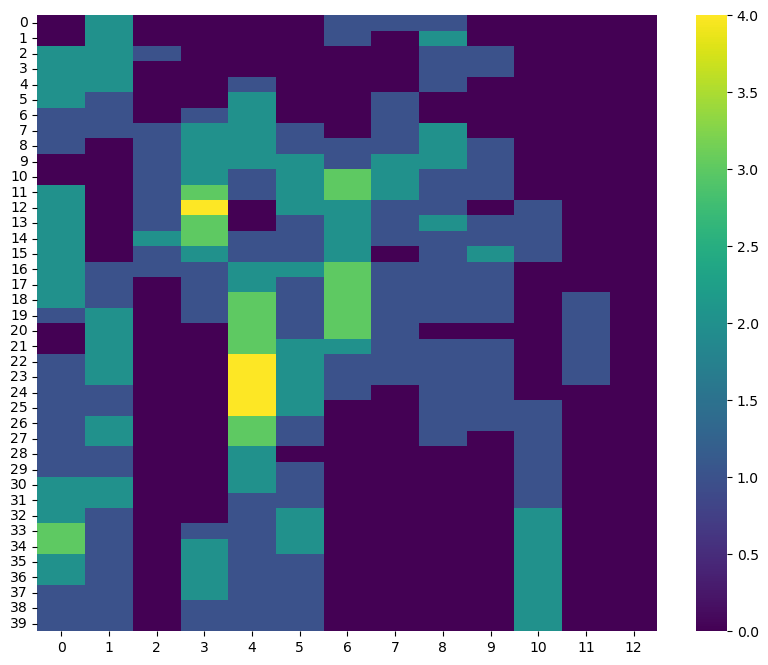

In [49]:
# Optionally, convert to a pandas DataFrame for better labeling
df = pd.DataFrame(to_cluster)

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df, annot=False, cmap='viridis')

# Show the plot
plt.show()

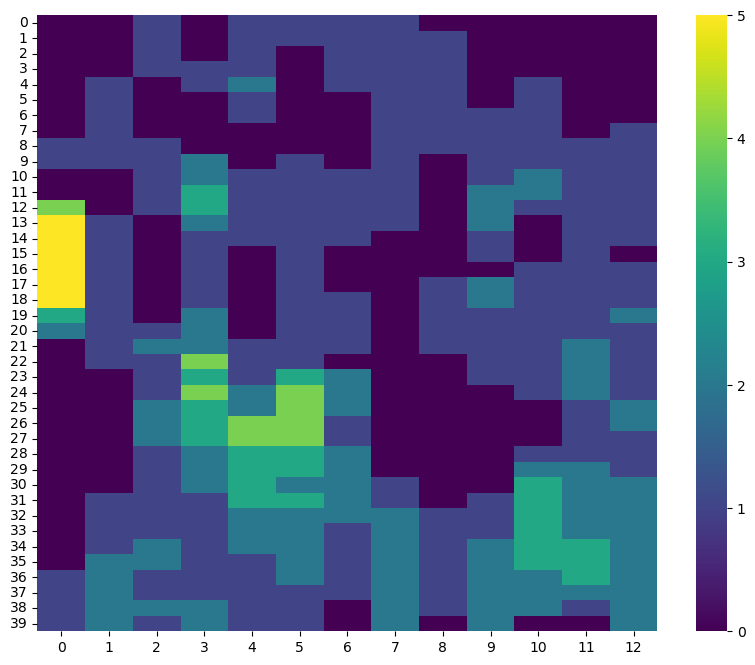

In [50]:
df = pd.DataFrame(from_cluster)

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df, annot=False, cmap='viridis')

# Show the plot
plt.show()

In [51]:
to_ofc_sig_dlpfc_df = to_ofc_sig_df[(to_ofc_sig_df['roi_pair'] == 'ofc_dlpfc')]
from_ofc_sig_dlpfc_df = from_ofc_sig_df[(from_ofc_sig_df['roi_pair'] == 'ofc_dlpfc')]

t7_folder = '/media/brooke/T7/pacman/connectivity/pac/approach'
to_cluster = np.zeros((40, 13))
for idx, row in to_ofc_sig_dlpfc_df.iterrows():
    file = f"{row['subject']}_{row['elec2']}_to_{row['elec1']}_pac.pkl"
    with open(f'{t7_folder}/to_ofc/{file}', 'rb') as f:
        p = pickle.load(f)

    test_stat, pval, cluster_tmp= find_pair_pac_pvalue(p)
    to_cluster = to_cluster + cluster_tmp


from_cluster = np.zeros((40, 13))
for idx, row in from_ofc_sig_dlpfc_df.iterrows():
    file = f"{row['subject']}_{row['elec1']}_to_{row['elec2']}_pac.pkl"
    with open(f'{t7_folder}/from_ofc/{file}', 'rb') as f:
        p = pickle.load(f)

    test_stat, pval, cluster_tmp= find_pair_pac_pvalue(p)
    from_cluster = from_cluster + cluster_tmp


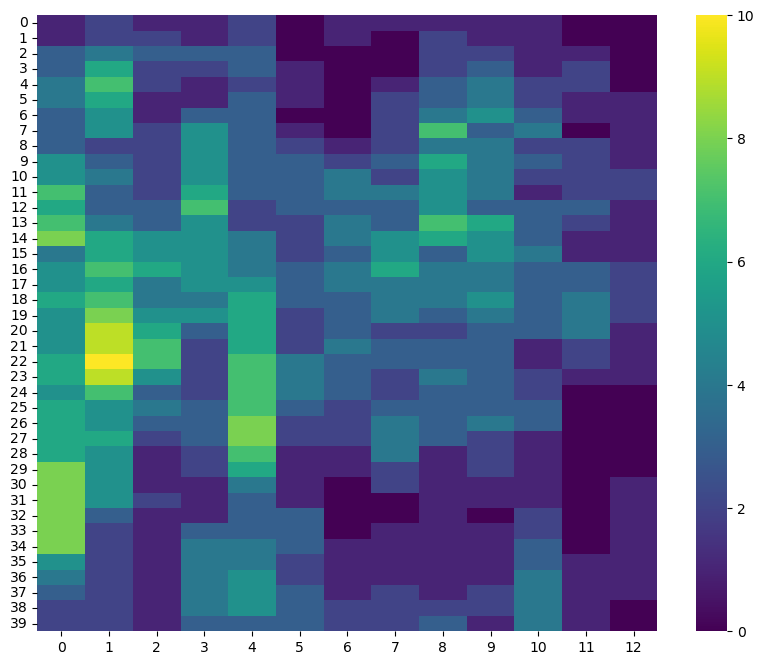

In [53]:
# Optionally, convert to a pandas DataFrame for better labeling
df = pd.DataFrame(to_cluster)

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df, annot=False, cmap='viridis')

# Show the plot
plt.show()

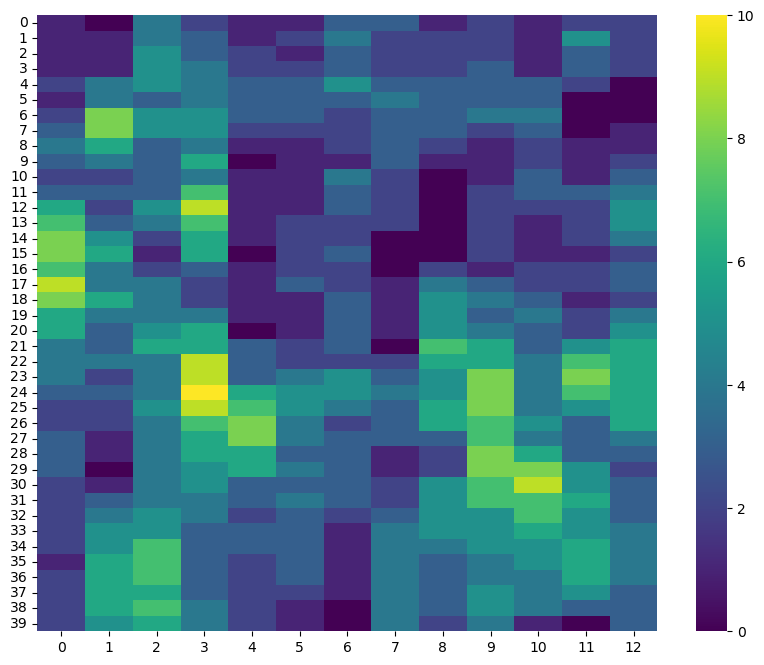

In [54]:
# Optionally, convert to a pandas DataFrame for better labeling
df = pd.DataFrame(from_cluster)

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df, annot=False, cmap='viridis')

# Show the plot
plt.show()

In [67]:
t7_folder = '/media/brooke/T7/pacman/connectivity/pac/approach'
to_cluster = np.zeros((40, 13))
for idx, row in to_ofc_sig_df.iterrows():
    file = f"{row['subject']}_{row['elec2']}_to_{row['elec1']}_pac.pkl"
    with open(f'{t7_folder}/to_ofc/{file}', 'rb') as f:
        p = pickle.load(f)

    test_stat, pval, cluster_tmp= find_pair_pac_pvalue(p)
    to_cluster = to_cluster + cluster_tmp


from_cluster = np.zeros((40, 13))
for idx, row in from_ofc_sig_df.iterrows():
    file = f"{row['subject']}_{row['elec1']}_to_{row['elec2']}_pac.pkl"
    with open(f'{t7_folder}/from_ofc/{file}', 'rb') as f:
        p = pickle.load(f)

    test_stat, pval, cluster_tmp= find_pair_pac_pvalue(p)
    from_cluster = from_cluster + cluster_tmp


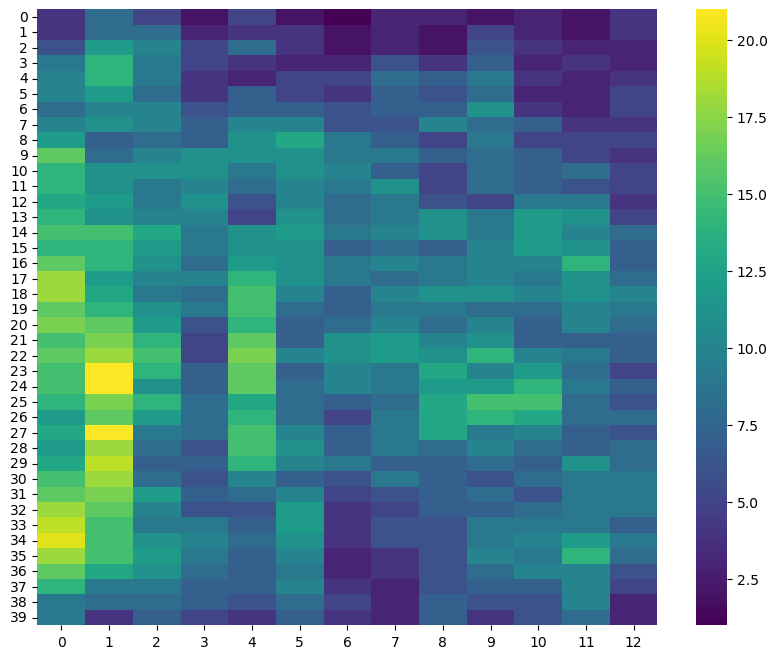

In [68]:
# Optionally, convert to a pandas DataFrame for better labeling
df = pd.DataFrame(to_cluster)

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df, annot=False, cmap='viridis')

# Show the plot
plt.show()

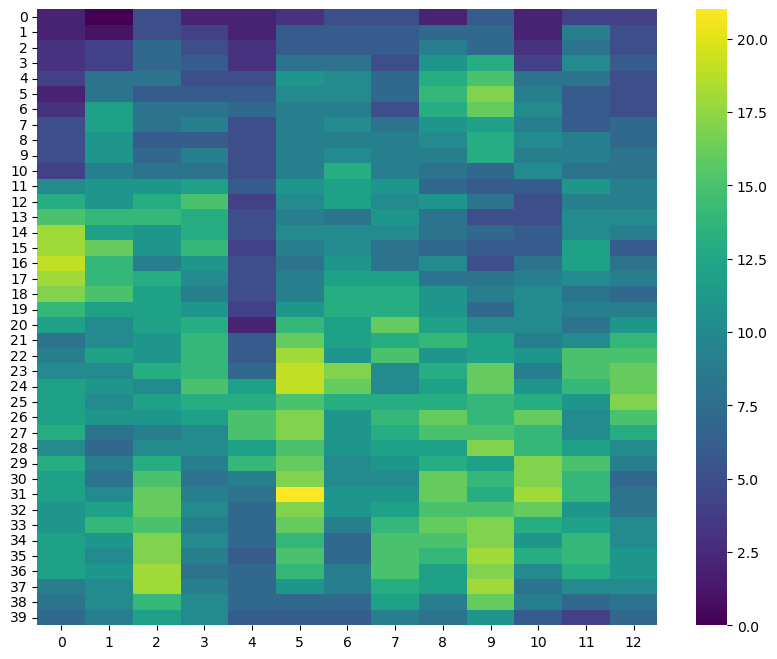

In [69]:
df = pd.DataFrame(from_cluster)

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df, annot=False, cmap='viridis')

# Show the plot
plt.show()

In [70]:
def get_average_roi_to_ofc_pair_pac(roi_str):

    # filter to roi
    to_ofc_sig_dlpfc_df = to_ofc_sig_df[(to_ofc_sig_df['roi_pair'] == roi_str)]

    t7_folder = '/media/brooke/T7/pacman/connectivity/pac/approach/'
    subs_list = np.unique(to_ofc_sig_dlpfc_df['subject'])
                        
    sub_pac = np.zeros((40, 13, len(subs_list)))                   
    for sIdx, sub in enumerate(subs_list):
        sub_df = to_ofc_sig_dlpfc_df[to_ofc_sig_dlpfc_df['subject'] == sub].reset_index()

        sub_xpac = np.zeros((40, 13, len(sub_df)))
        for idx, row in sub_df.iterrows():
            file = f"{row['subject']}_{row['elec2']}_to_{row['elec1']}_pac.pkl"
            with open(f'{t7_folder}/to_ofc/{file}', 'rb') as f:
                p = pickle.load(f)

            xpac = p.pac.mean(-1)
            xpac_perm = p.surrogates.mean(-1)
            xpac_z = (xpac - xpac_perm.mean(axis = 0)) / np.std(xpac_perm, axis = 0)

            sub_xpac[:, :, idx] = xpac_z
        # take average
        sub_avg_xpac = sub_xpac.mean(-1)
        sub_pac[:, :, sIdx] = sub_avg_xpac

    return(sub_pac)

def get_average_ofc_to_roi_pair_pac(roi_str):
    from_ofc_sig_dlpfc_df = from_ofc_sig_df[(from_ofc_sig_df['roi_pair'] == roi_str)]

    t7_folder = '/media/brooke/T7/pacman/connectivity/pac/approach'
    subs_list = np.unique(from_ofc_sig_dlpfc_df['subject'])
                        
    sub_pac = np.zeros((40, 13, len(subs_list)))                   
    for sIdx, sub in enumerate(subs_list):
        sub_df = from_ofc_sig_dlpfc_df[from_ofc_sig_dlpfc_df['subject'] == sub].reset_index()

        sub_xpac = np.zeros((40, 13, len(sub_df)))
        for idx, row in sub_df.iterrows():
            file = f"{row['subject']}_{row['elec1']}_to_{row['elec2']}_pac.pkl"
            with open(f'{t7_folder}/from_ofc/{file}', 'rb') as f:
                p = pickle.load(f)

            xpac = p.pac.mean(-1)
            xpac_perm = p.surrogates.mean(-1)
            xpac_z = (xpac - xpac_perm.mean(axis = 0)) / np.std(xpac_perm, axis = 0)

            sub_xpac[:, :, idx] = xpac_z
        # take average
        sub_avg_xpac = sub_xpac.mean(-1)
        sub_pac[:, :, sIdx] = sub_avg_xpac

    return(sub_pac)




In [71]:
def plot_pac(pac, title_str):

    pac_df = pd.DataFrame(pac, columns = np.round(p.xvec), index = np.round(p.yvec))

    # Create the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(pac_df, annot=False, cmap='viridis', vmin = 0)
    plt.xlabel('Phases')
    plt.ylabel('Amplitudes')
    plt.title(title_str)

    # Show the plot
    plt.show()

In [98]:
def plot_both_pacs(pac1, pac2, title1, title2, upper_v):
    pac_df1 = pd.DataFrame(pac1, columns=np.round(p.xvec), index=np.round(p.yvec))
    pac_df2 = pd.DataFrame(pac2, columns=np.round(p.xvec), index=np.round(p.yvec))

    # Create the figure and axes
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Plot the first heatmap
    sns.heatmap(pac_df1, annot=False, cmap='viridis', vmin=0, vmax = upper_v, ax=ax1)
    ax1.set_xlabel('Phases')
    ax1.set_ylabel('Amplitudes')
    ax1.set_title(title1)

    # Plot the second heatmap
    sns.heatmap(pac_df2, annot=False, cmap='viridis', vmin=0, vmax = upper_v, ax=ax2)
    ax2.set_xlabel('Phases')
    ax2.set_ylabel('Amplitudes')
    ax2.set_title(title2)

    # Show the plots
    plt.show()


### dlPFC

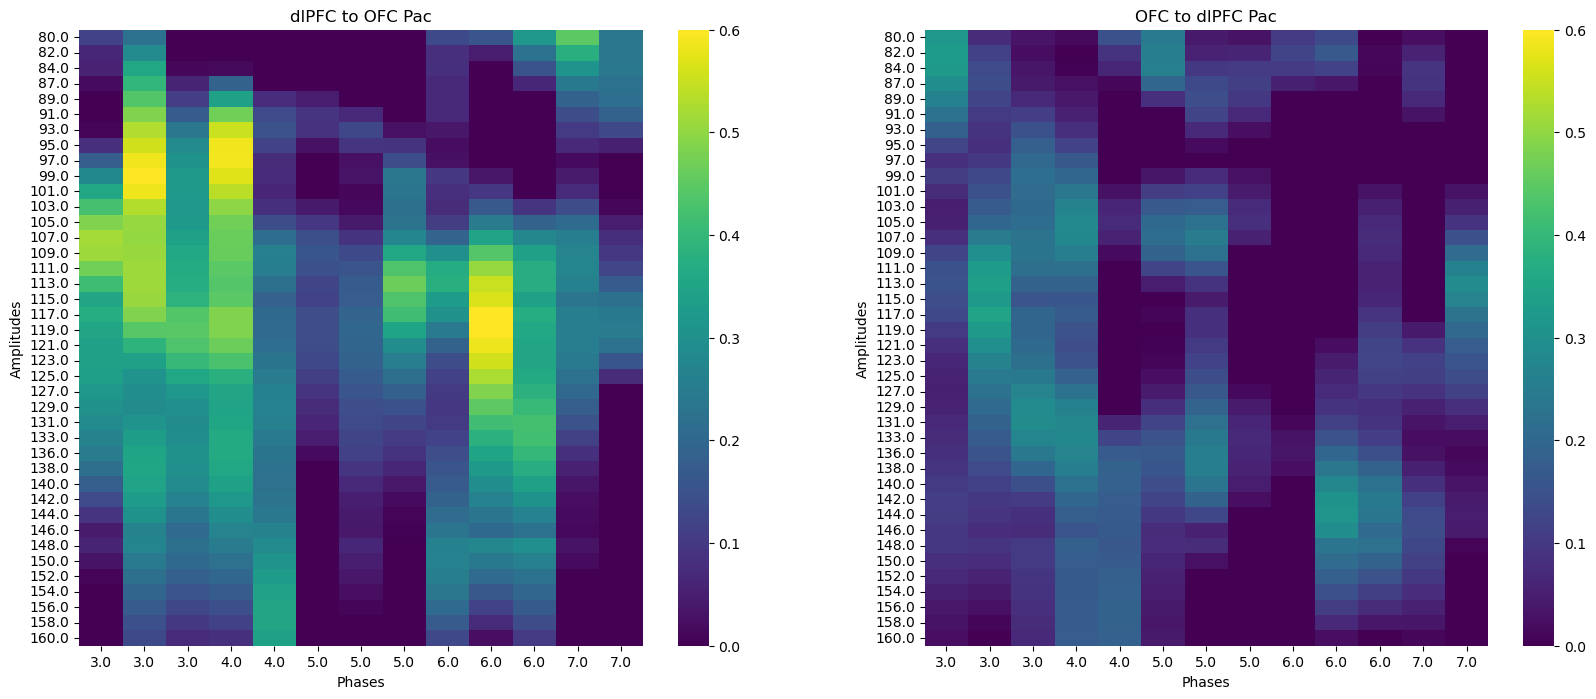

In [99]:
to_ofc_sub_pac = get_average_roi_to_ofc_pair_pac('ofc_dlpfc')
from_ofc_sub_pac = get_average_ofc_to_roi_pair_pac('ofc_dlpfc')

to_ofc_average_pac = to_ofc_sub_pac.mean(-1)
from_ofc_average_pac = from_ofc_sub_pac.mean(-1)

plot_both_pacs(to_ofc_average_pac, from_ofc_average_pac, 'dlPFC to OFC Pac', 'OFC to dlPFC Pac', upper_v = 0.6)

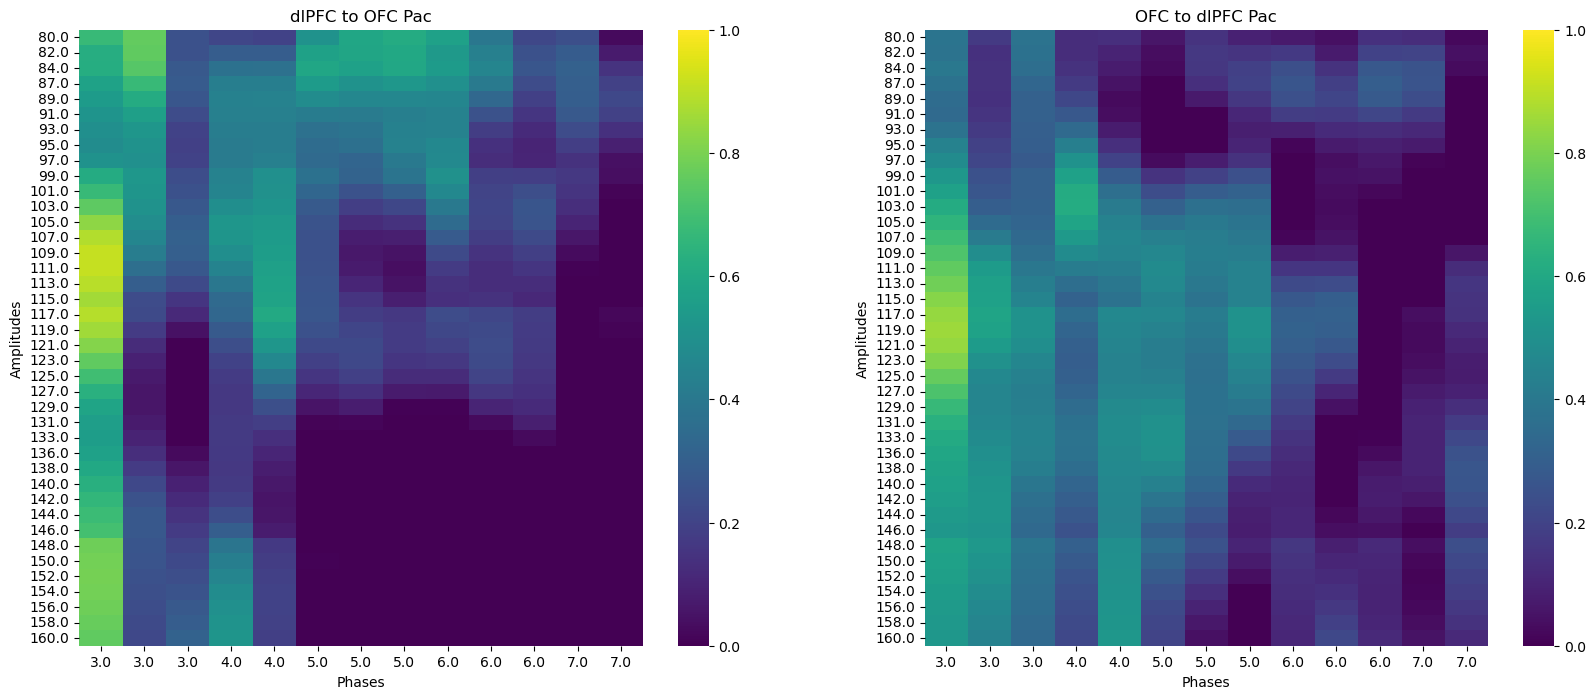

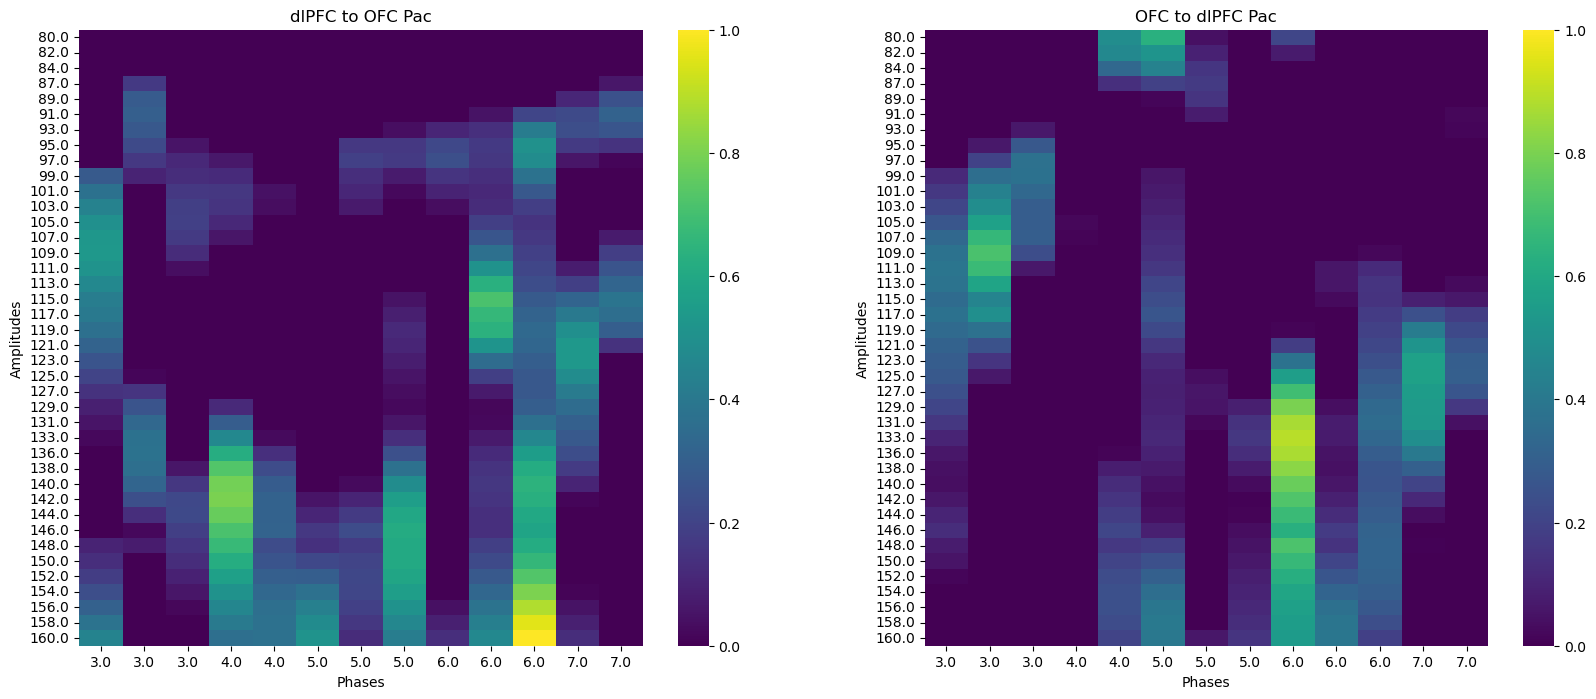

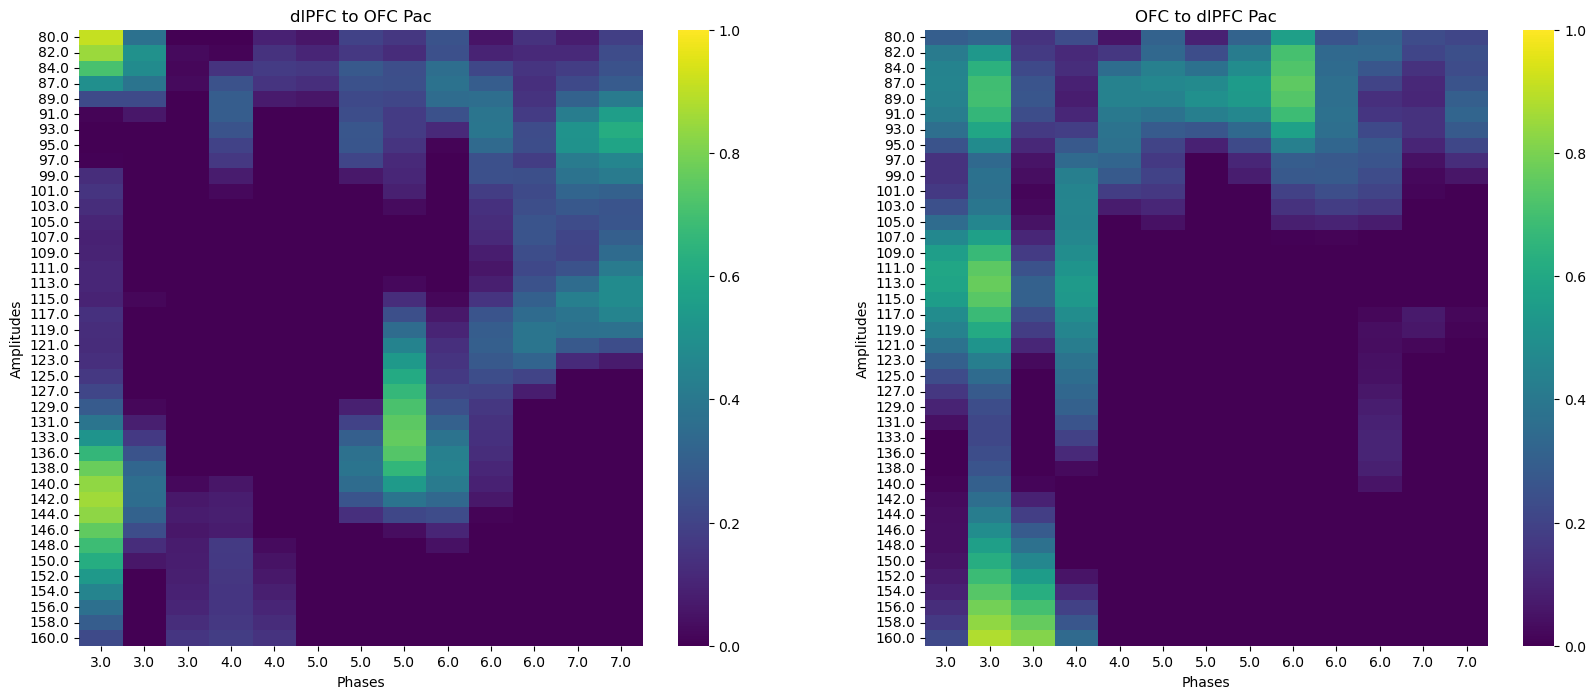

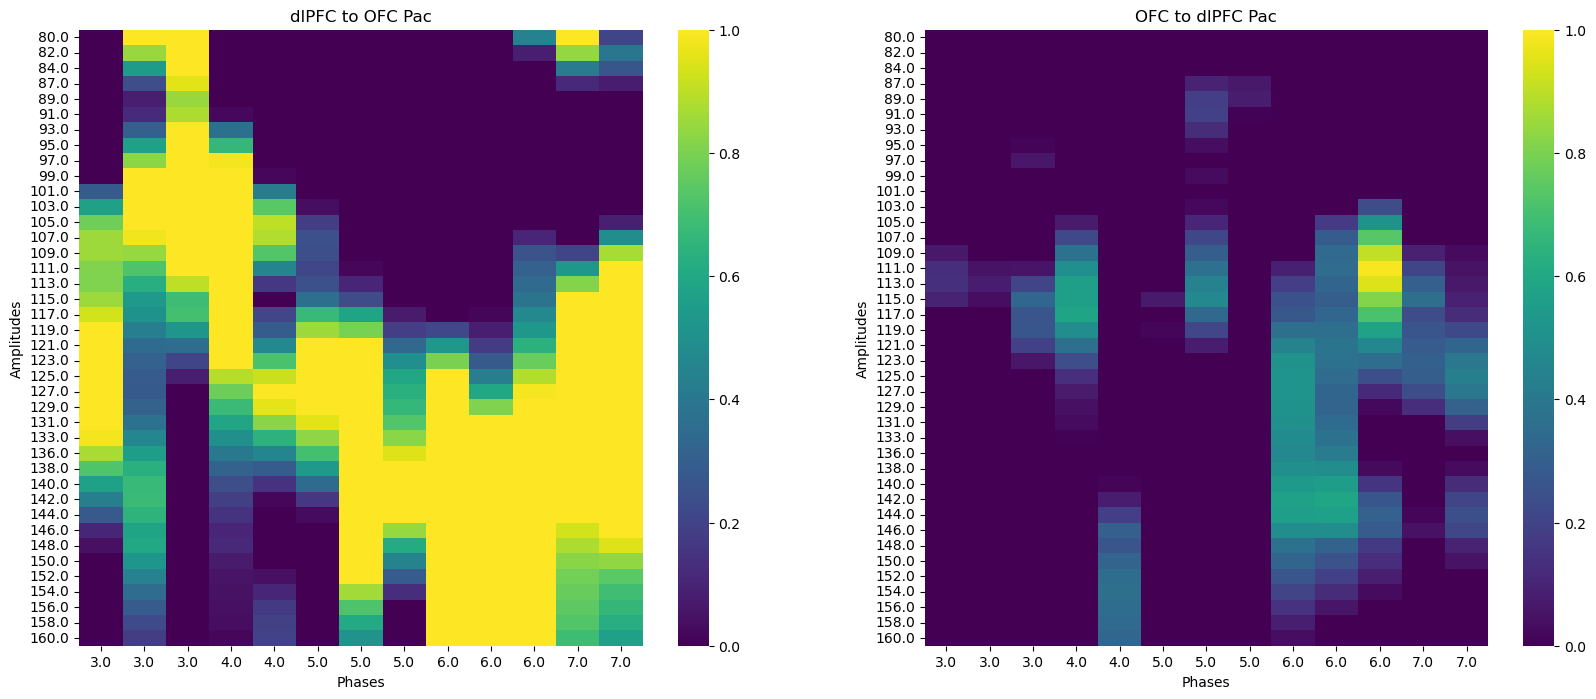

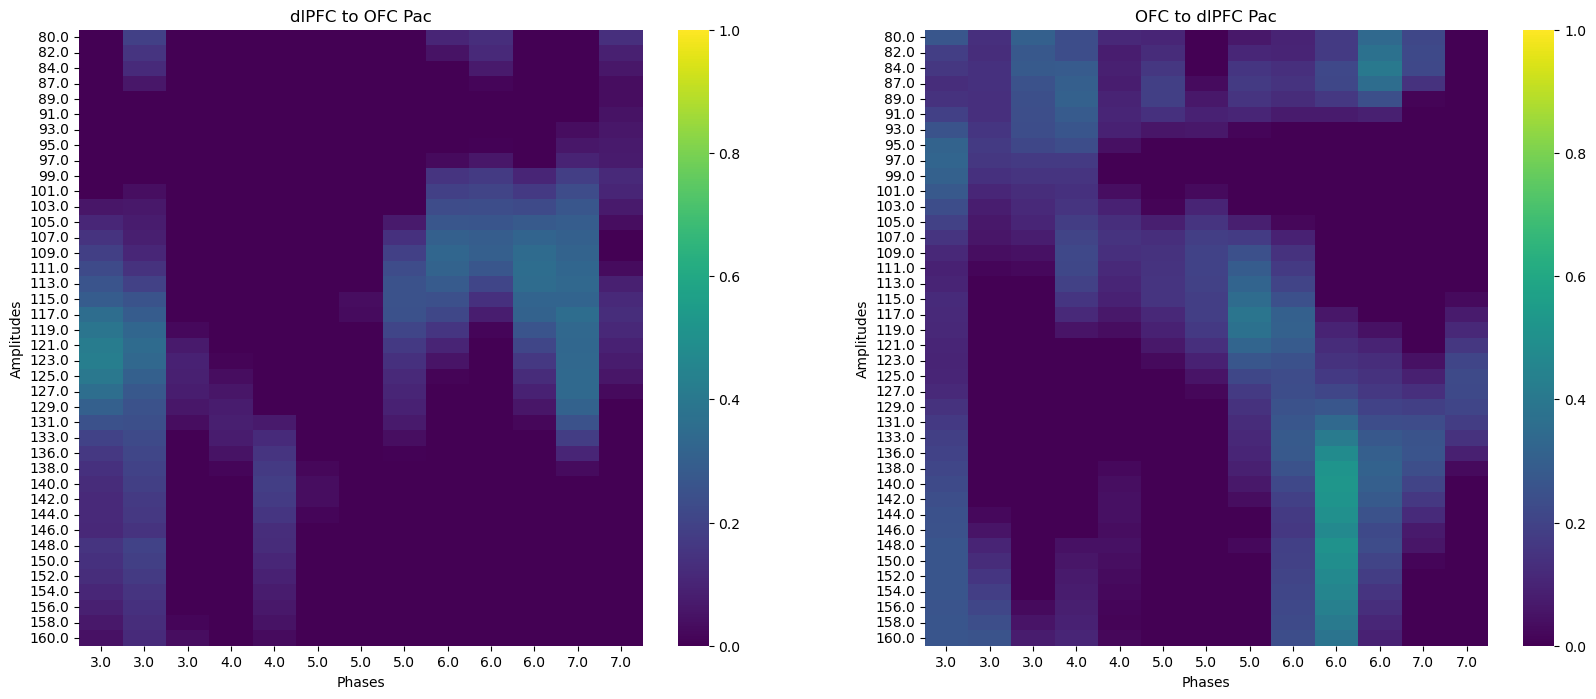

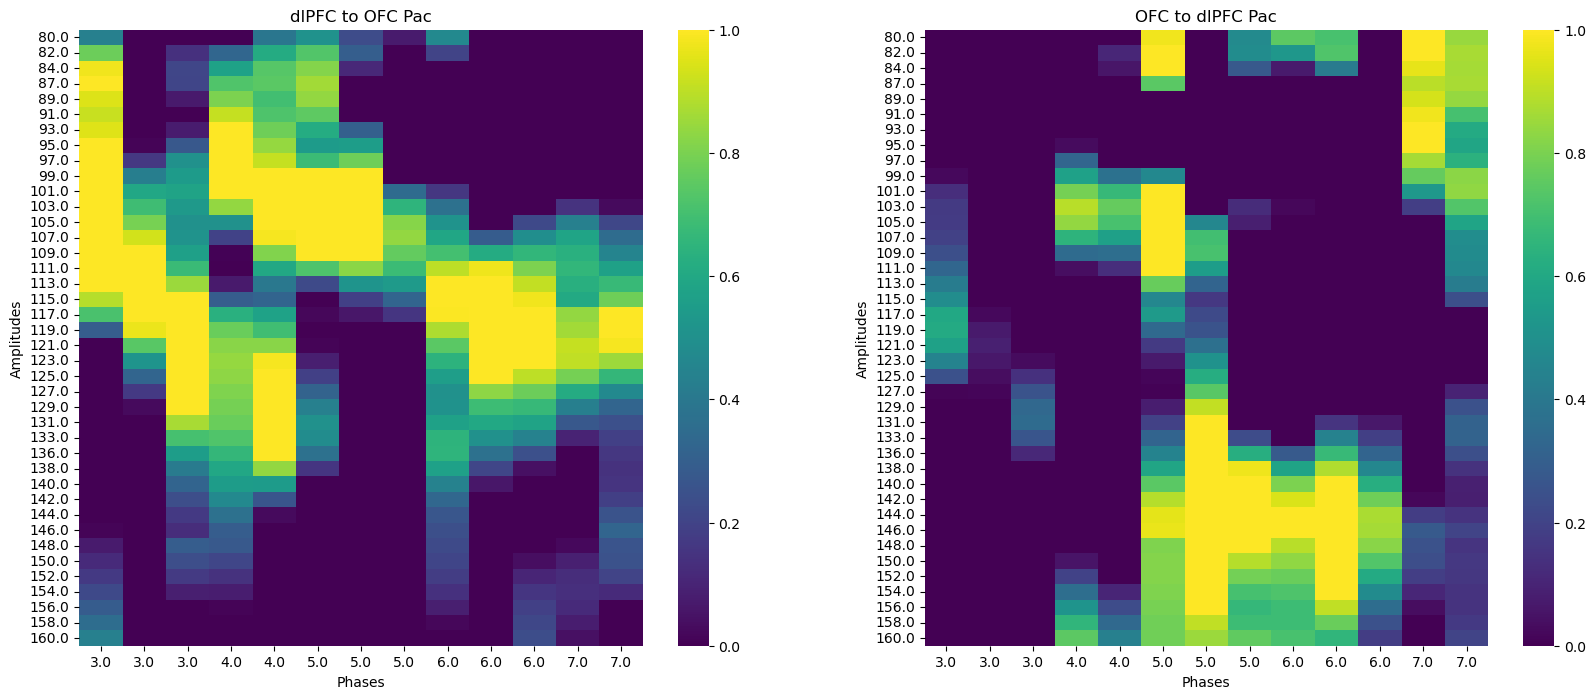

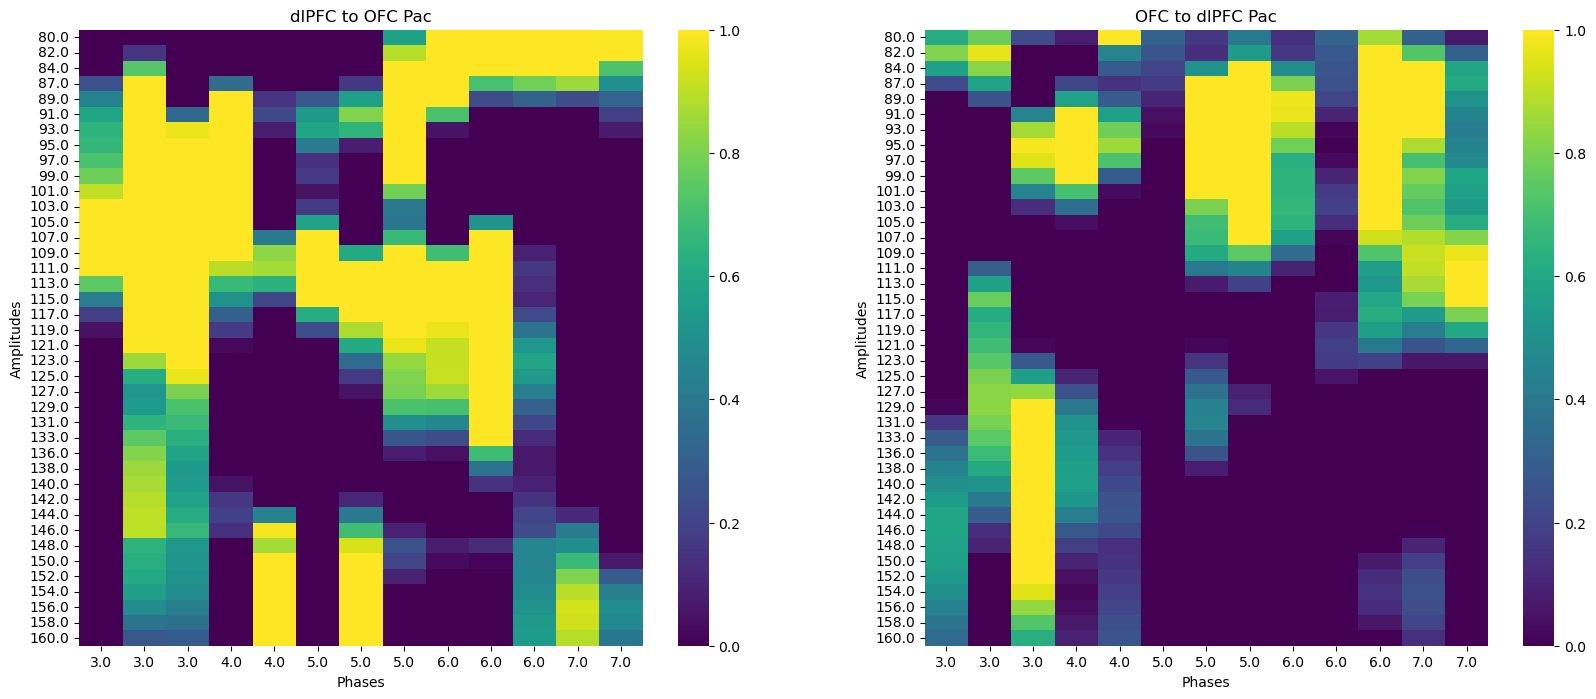

In [93]:
for i in range(7):
    plot_both_pacs(to_ofc_sub_pac[:, :, i], from_ofc_sub_pac[:, :, i], 'dlPFC to OFC Pac', 'OFC to dlPFC Pac')

### Ant. Cingulate

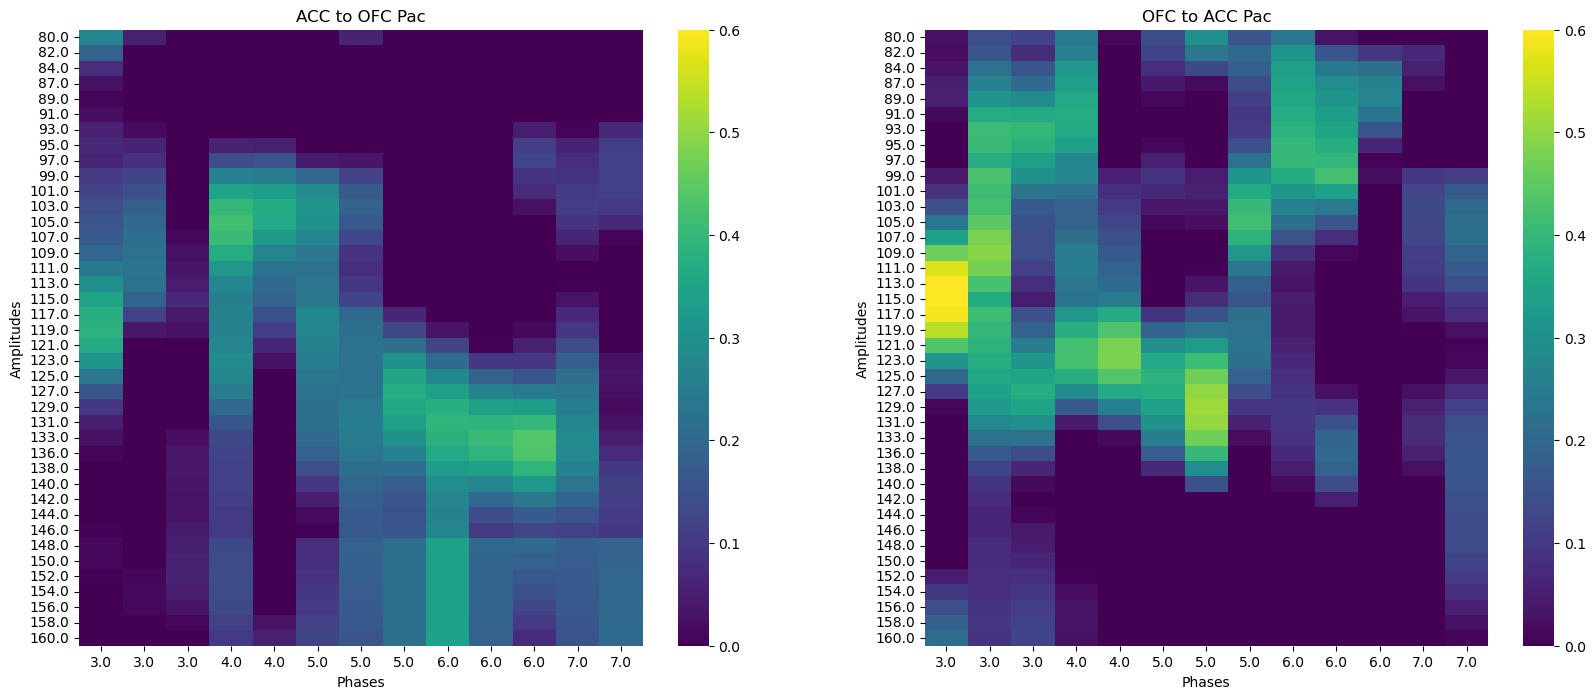

In [100]:
to_ofc_sub_pac = get_average_roi_to_ofc_pair_pac('ofc_cing')
from_ofc_sub_pac = get_average_ofc_to_roi_pair_pac('ofc_cing')

to_ofc_average_pac = to_ofc_sub_pac.mean(-1)
from_ofc_average_pac = from_ofc_sub_pac.mean(-1)

plot_both_pacs(to_ofc_average_pac, from_ofc_average_pac, 'ACC to OFC Pac', 'OFC to ACC Pac', upper_v = 0.6)

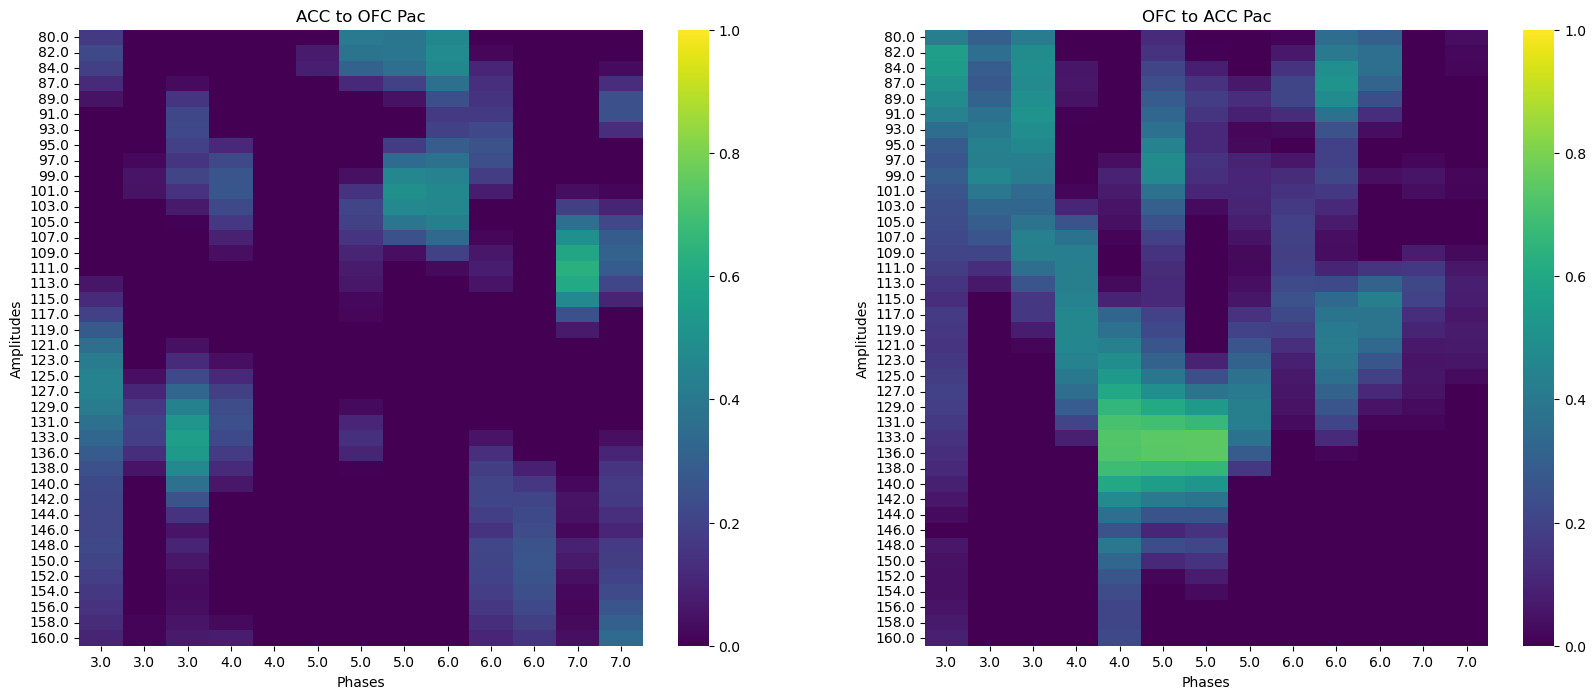

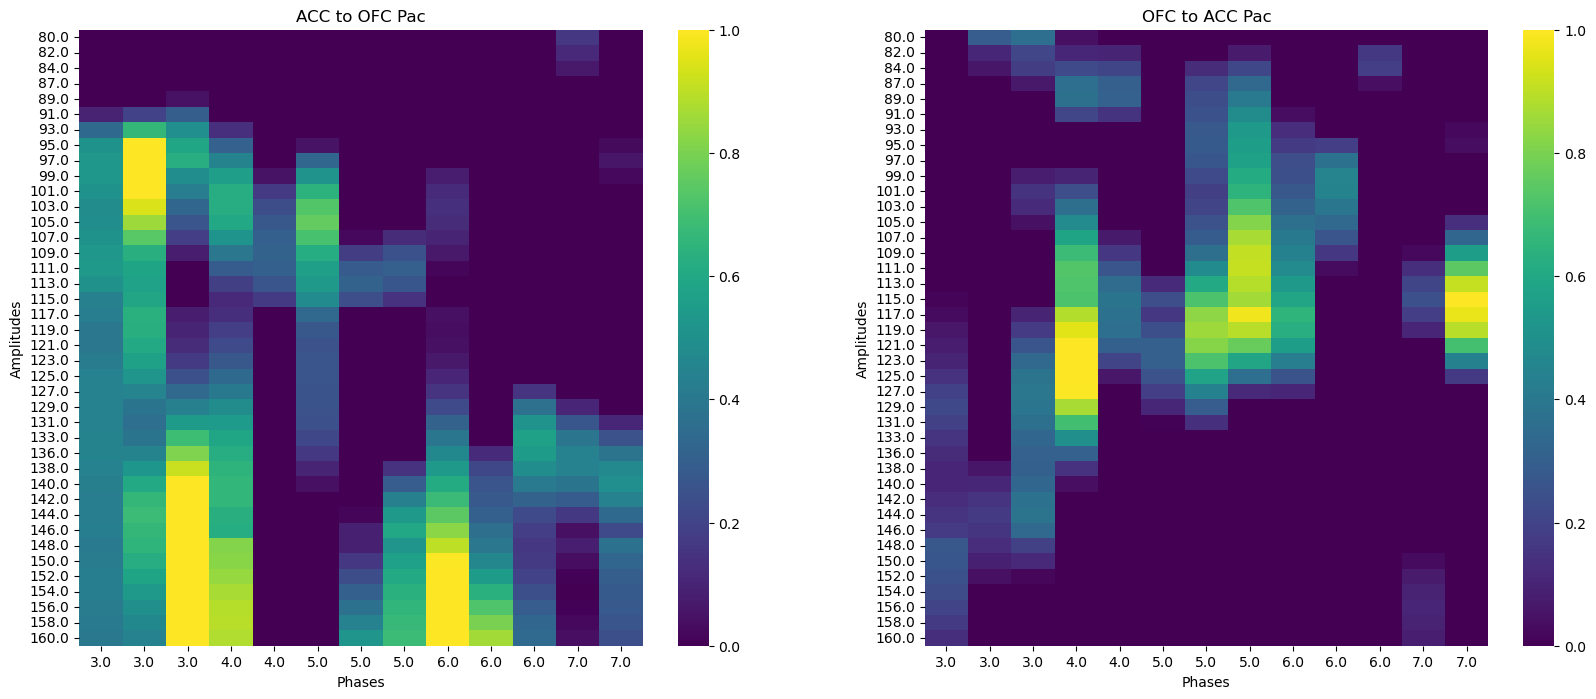

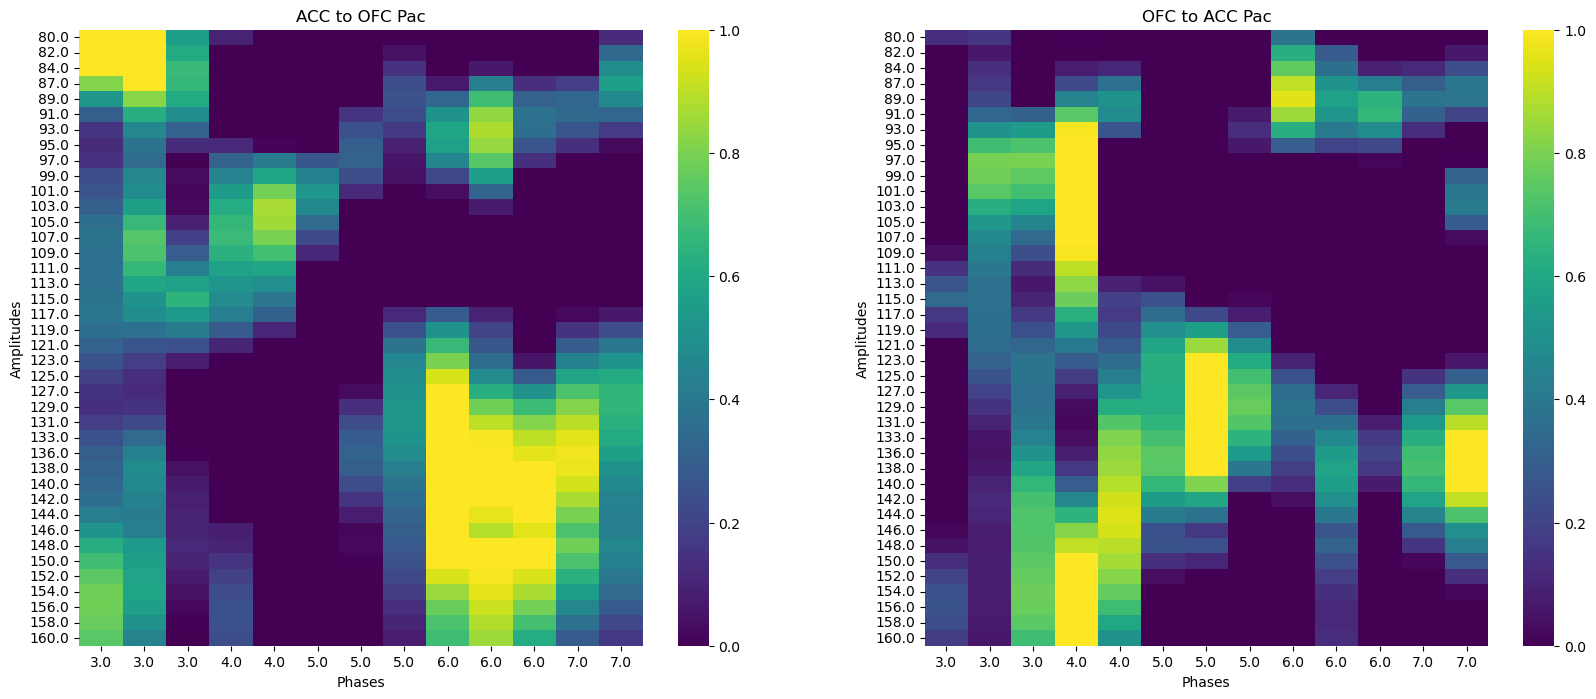

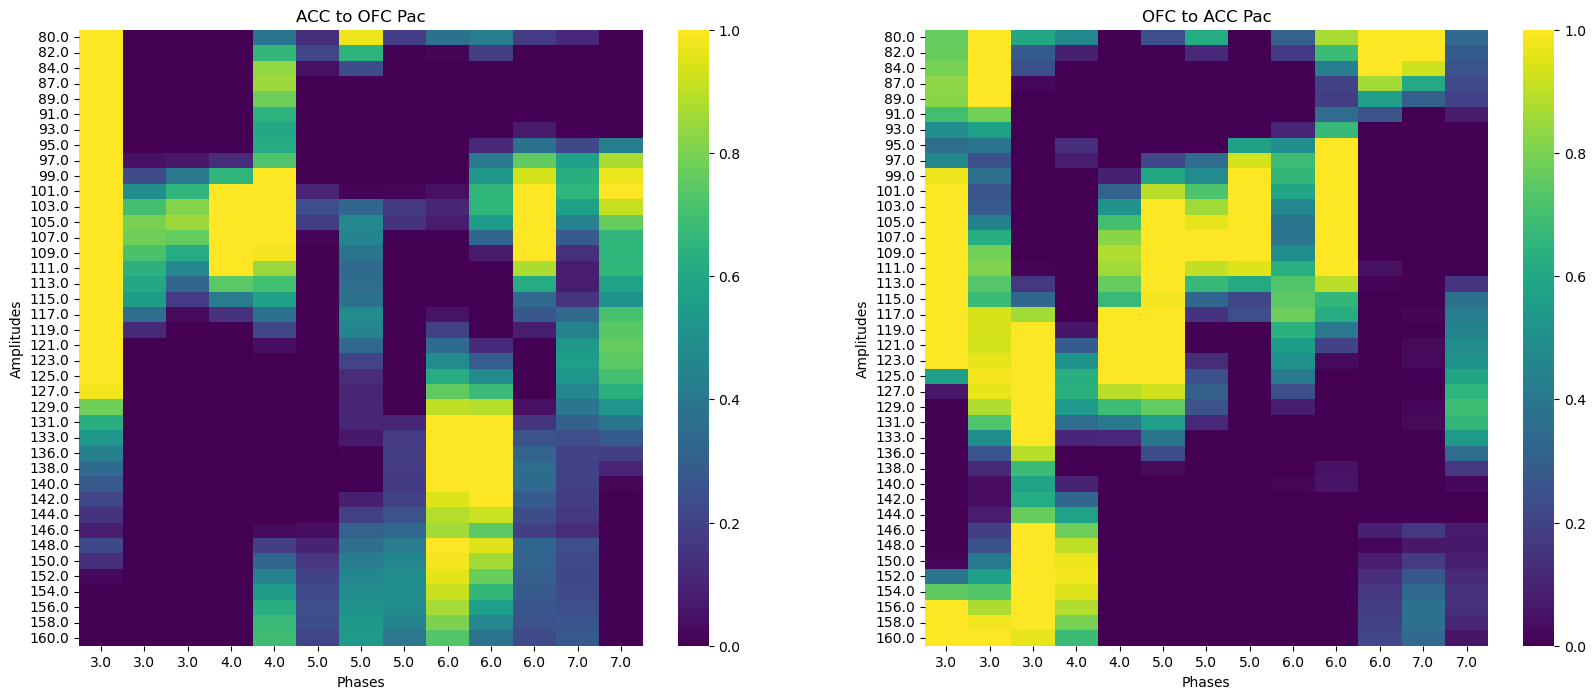

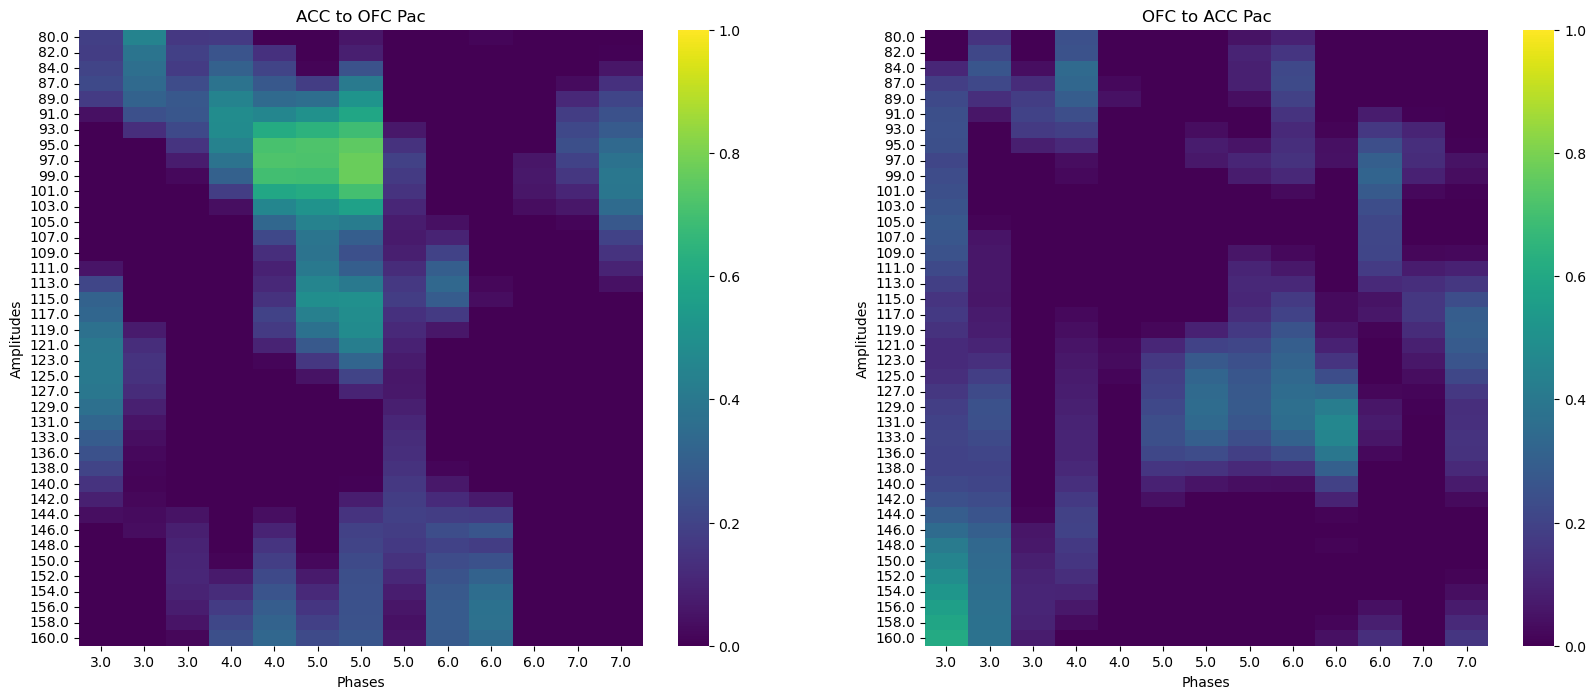

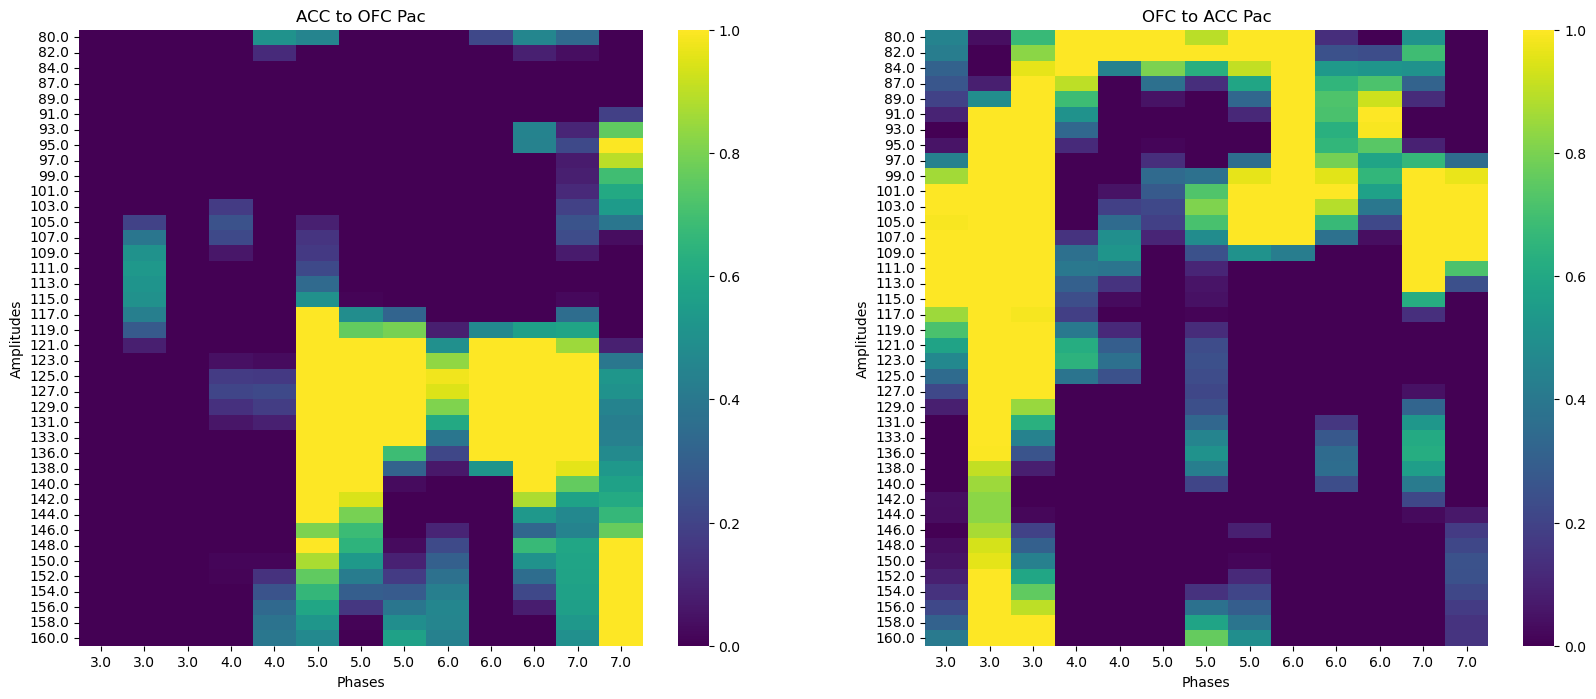

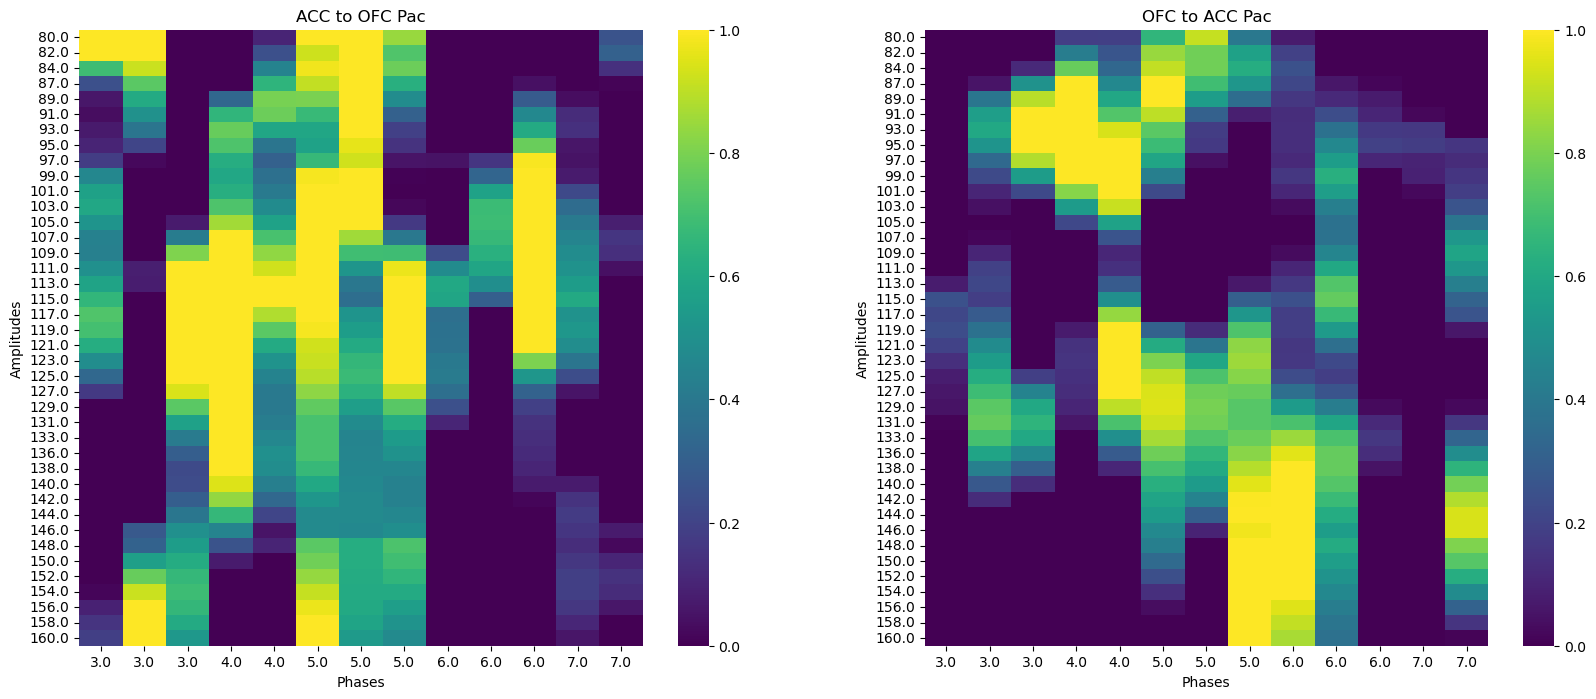

In [101]:
for i in range(7):
    plot_both_pacs(to_ofc_sub_pac[:, :, i], from_ofc_sub_pac[:, :, i], 'ACC to OFC Pac', 'OFC to ACC Pac', upper_v = 1)

### Insula

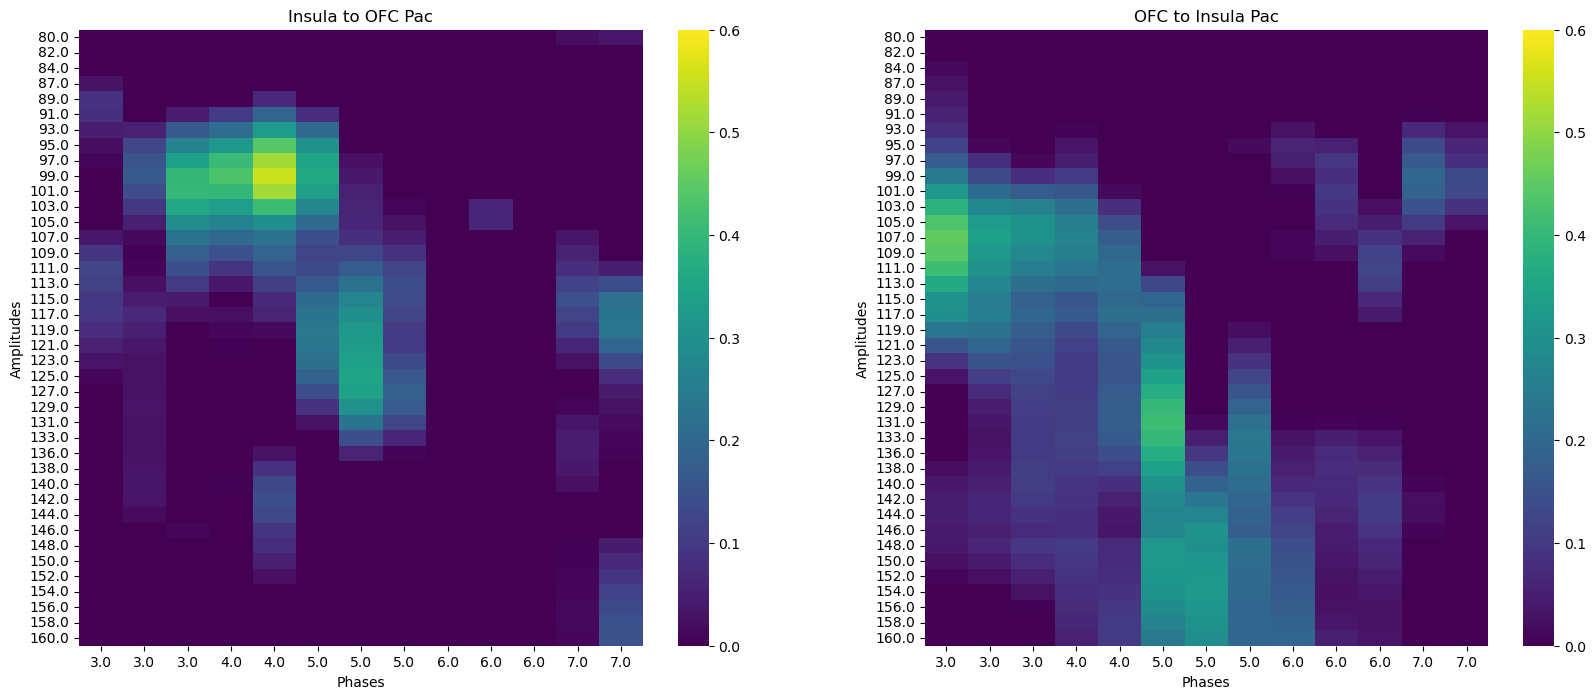

In [102]:
to_ofc_sub_pac = get_average_roi_to_ofc_pair_pac('ofc_insula')
from_ofc_sub_pac = get_average_ofc_to_roi_pair_pac('ofc_insula')

to_ofc_average_pac = to_ofc_sub_pac.mean(-1)
from_ofc_average_pac = from_ofc_sub_pac.mean(-1)

plot_both_pacs(to_ofc_average_pac, from_ofc_average_pac, 'Insula to OFC Pac', 'OFC to Insula Pac', upper_v = 0.6)

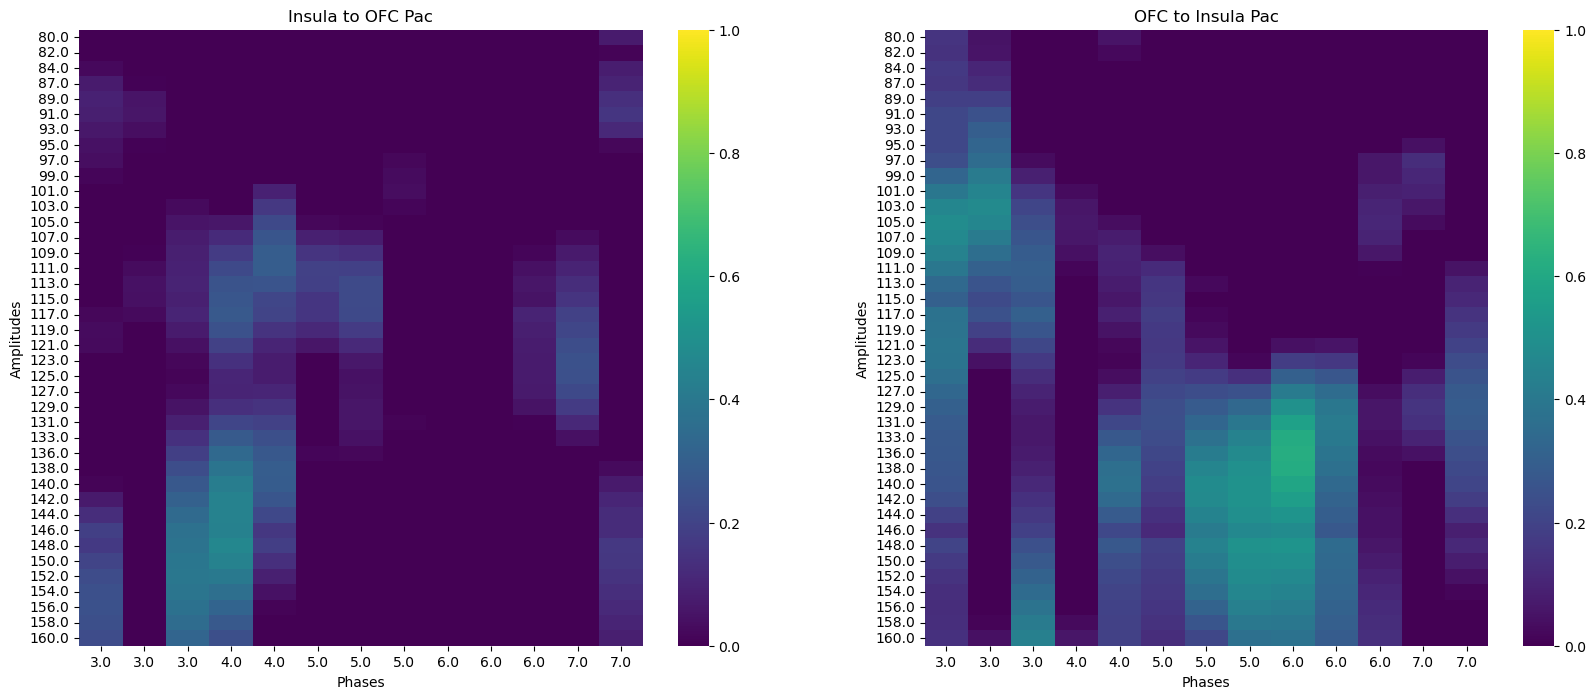

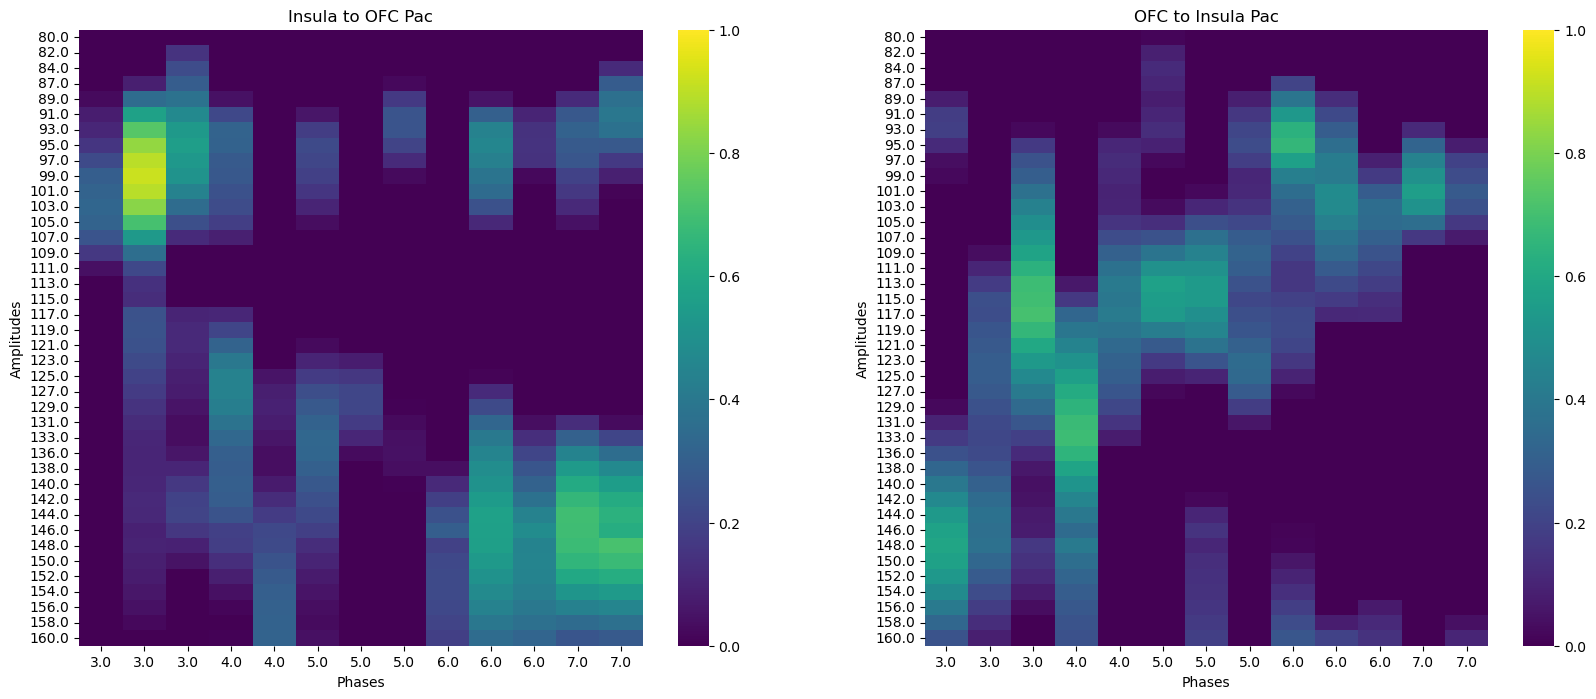

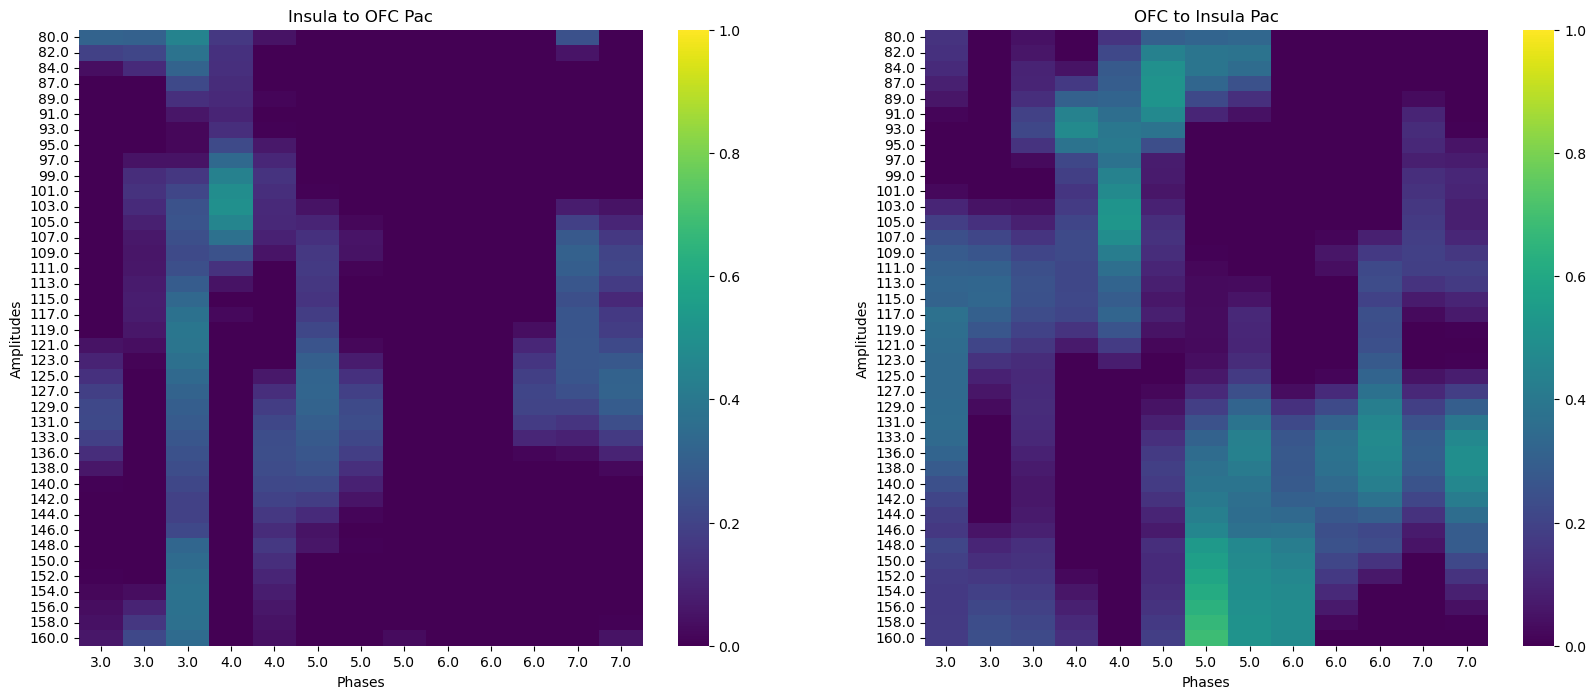

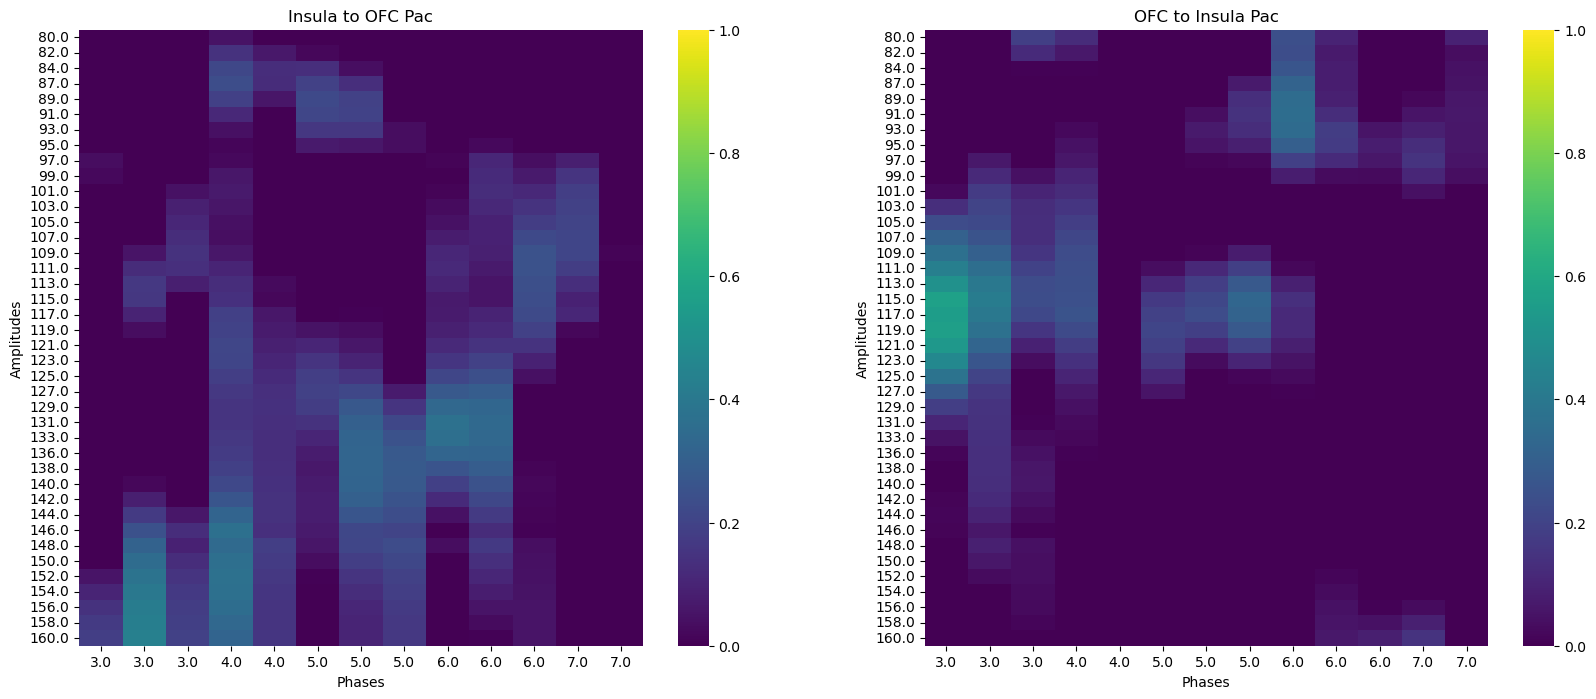

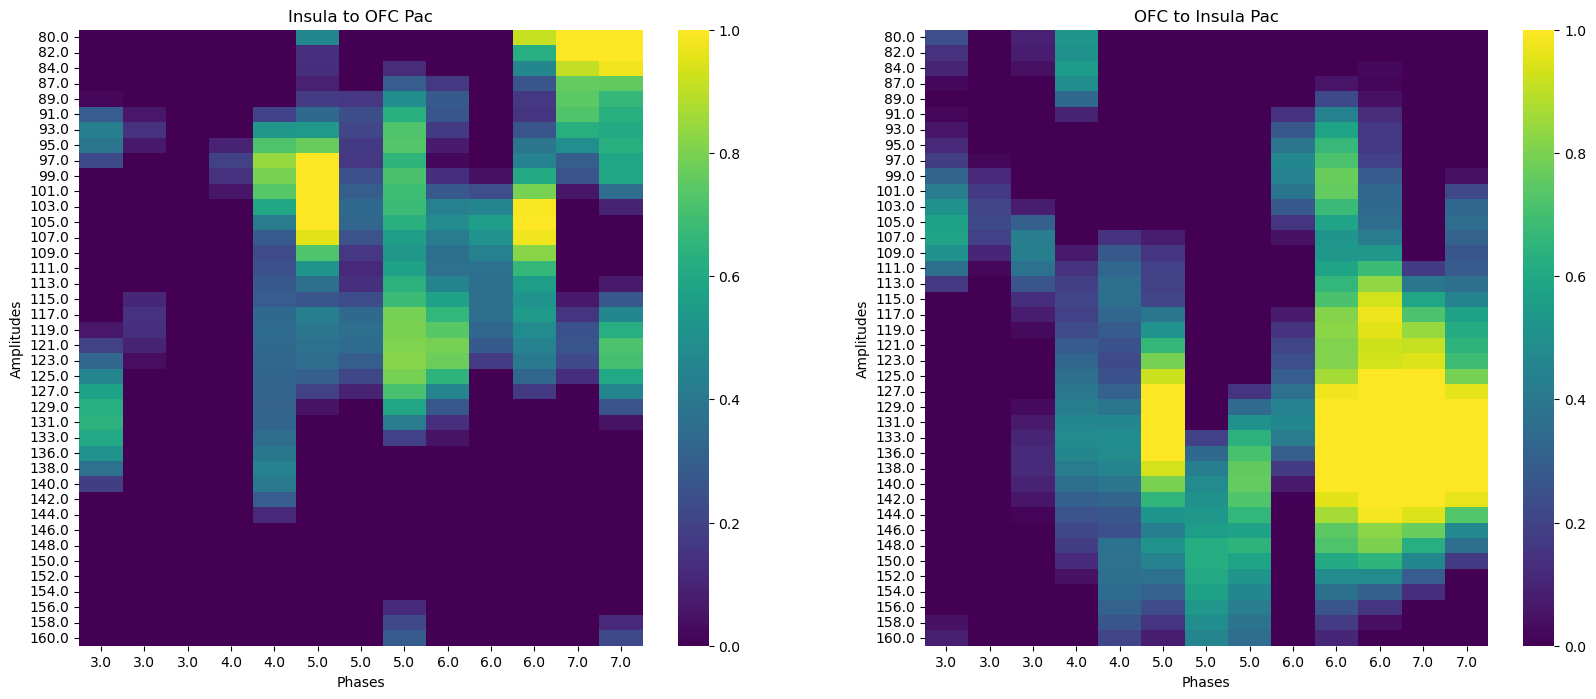

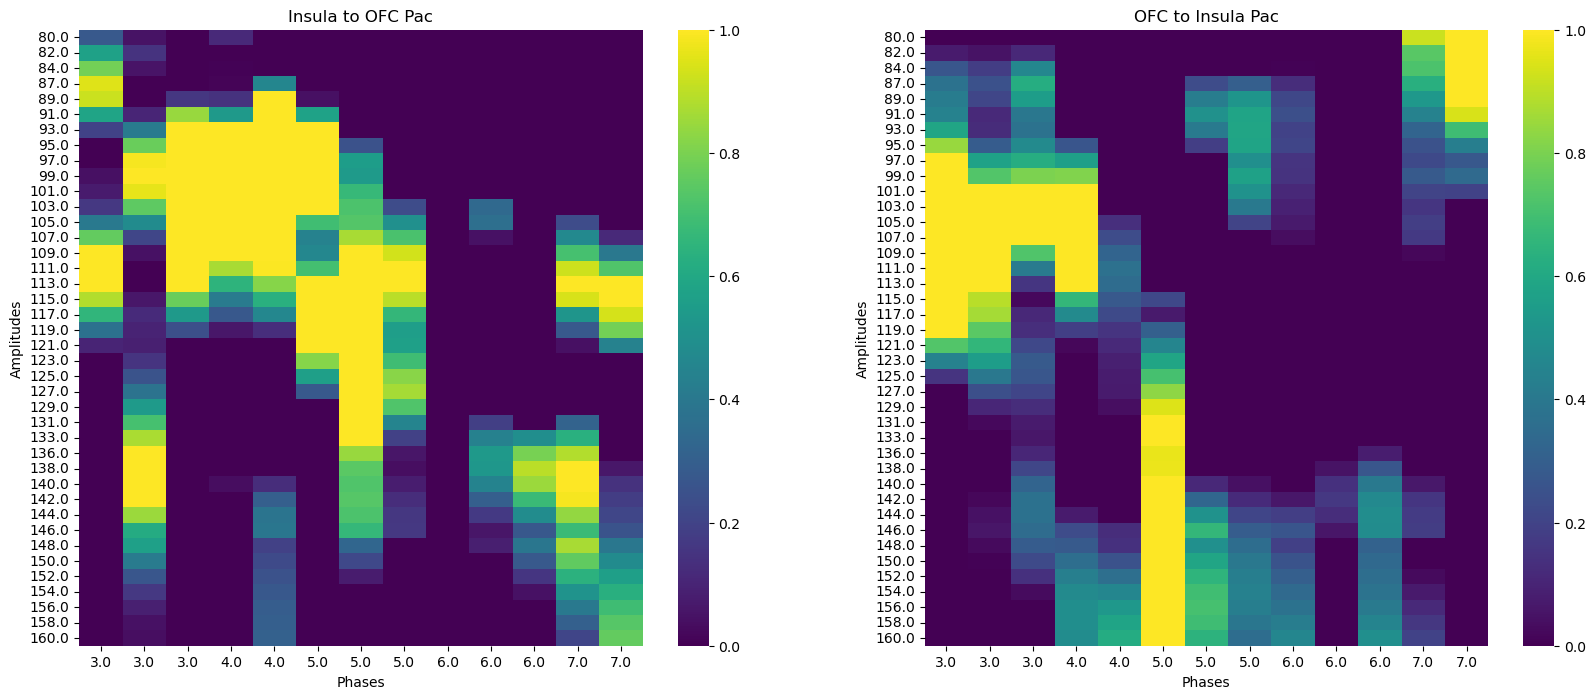

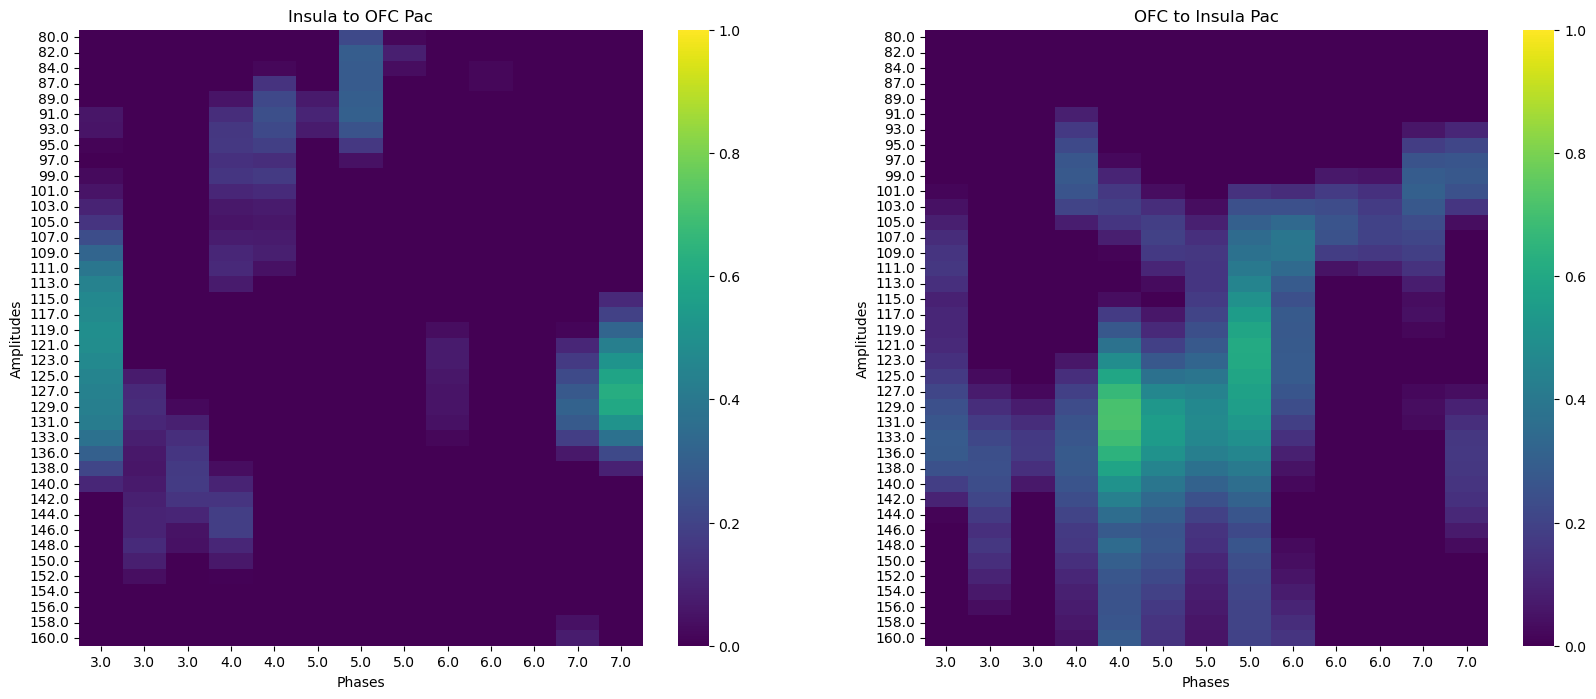

In [103]:
for i in range(7):
    plot_both_pacs(to_ofc_sub_pac[:, :, i], from_ofc_sub_pac[:, :, i], 'Insula to OFC Pac', 'OFC to Insula Pac', upper_v = 1)

### Hippocampus

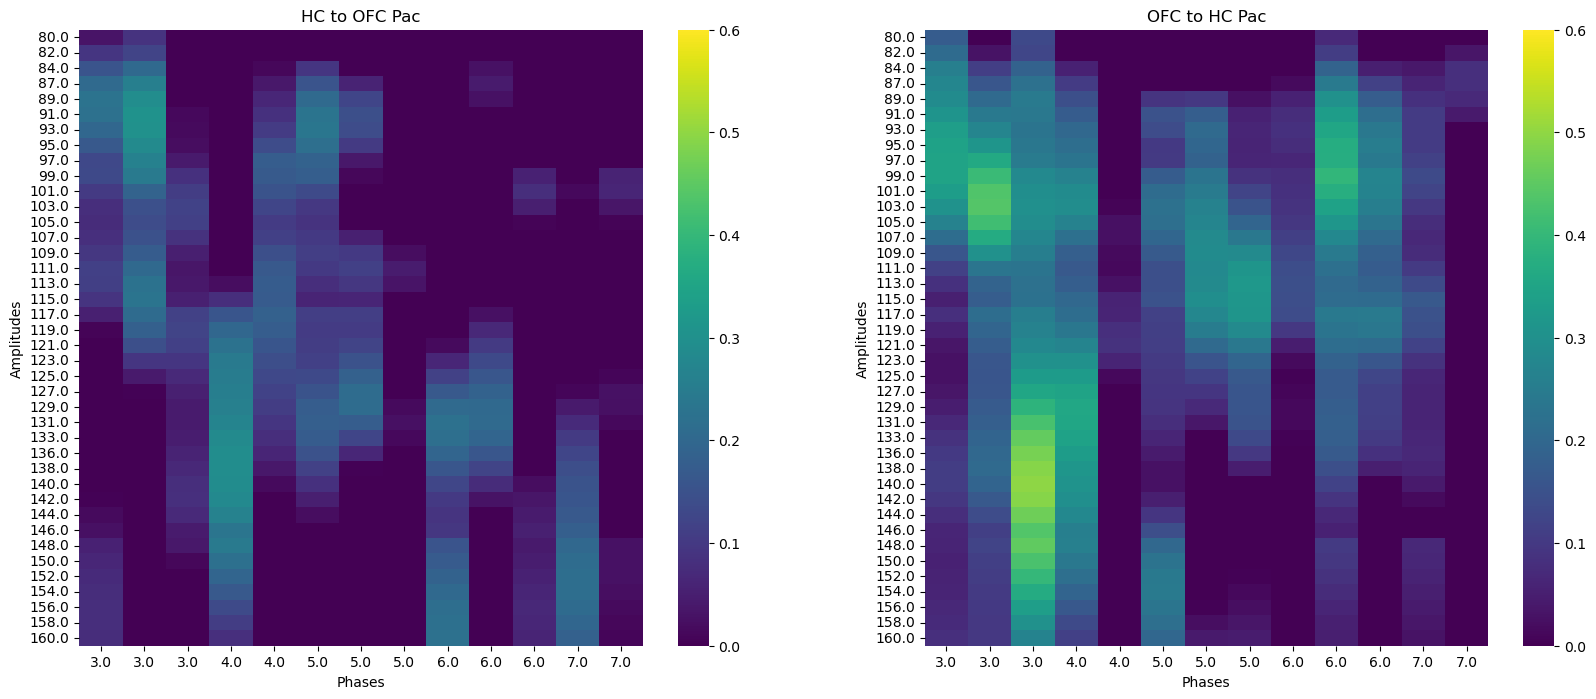

In [104]:
to_ofc_sub_pac = get_average_roi_to_ofc_pair_pac('ofc_hc')
from_ofc_sub_pac = get_average_ofc_to_roi_pair_pac('ofc_hc')

to_ofc_average_pac = to_ofc_sub_pac.mean(-1)
from_ofc_average_pac = from_ofc_sub_pac.mean(-1)

plot_both_pacs(to_ofc_average_pac, from_ofc_average_pac, 'HC to OFC Pac', 'OFC to HC Pac', upper_v = 0.6)

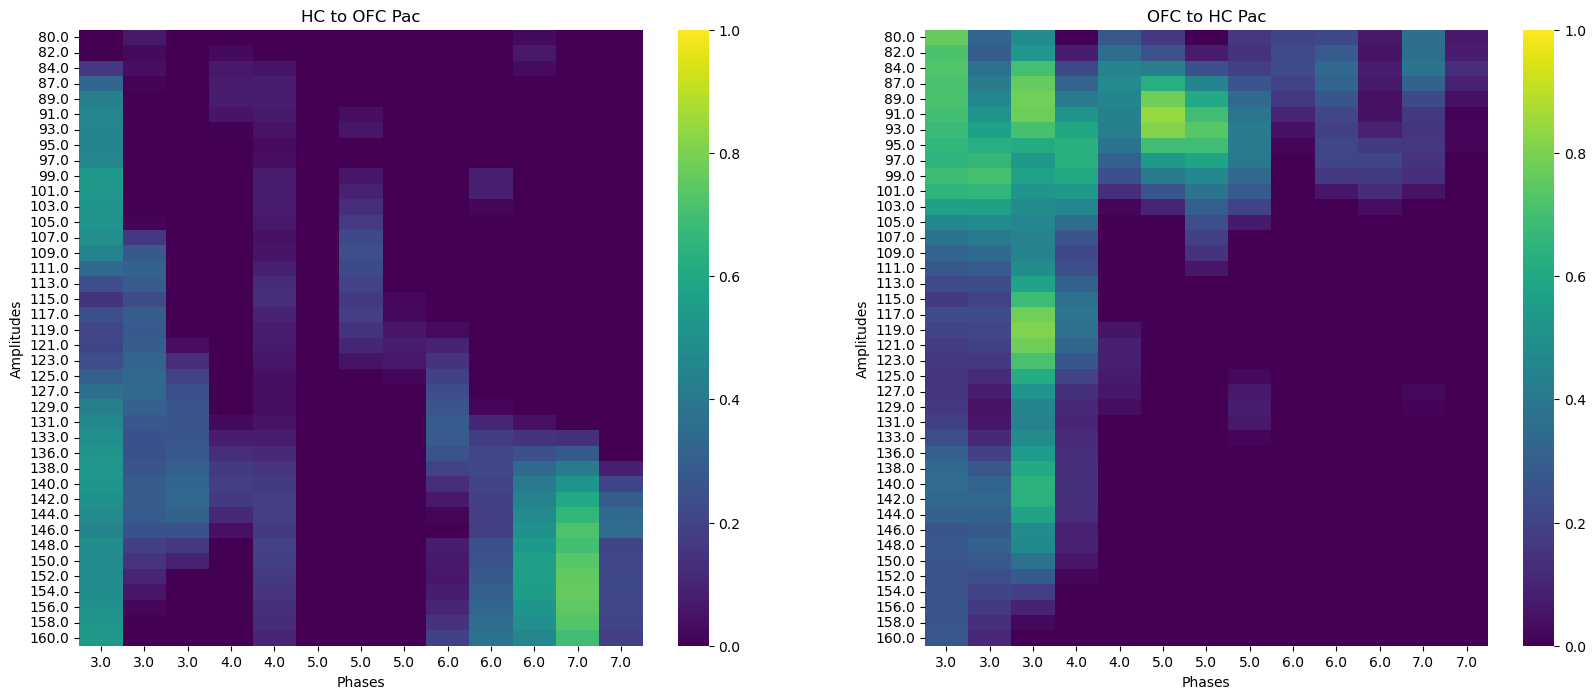

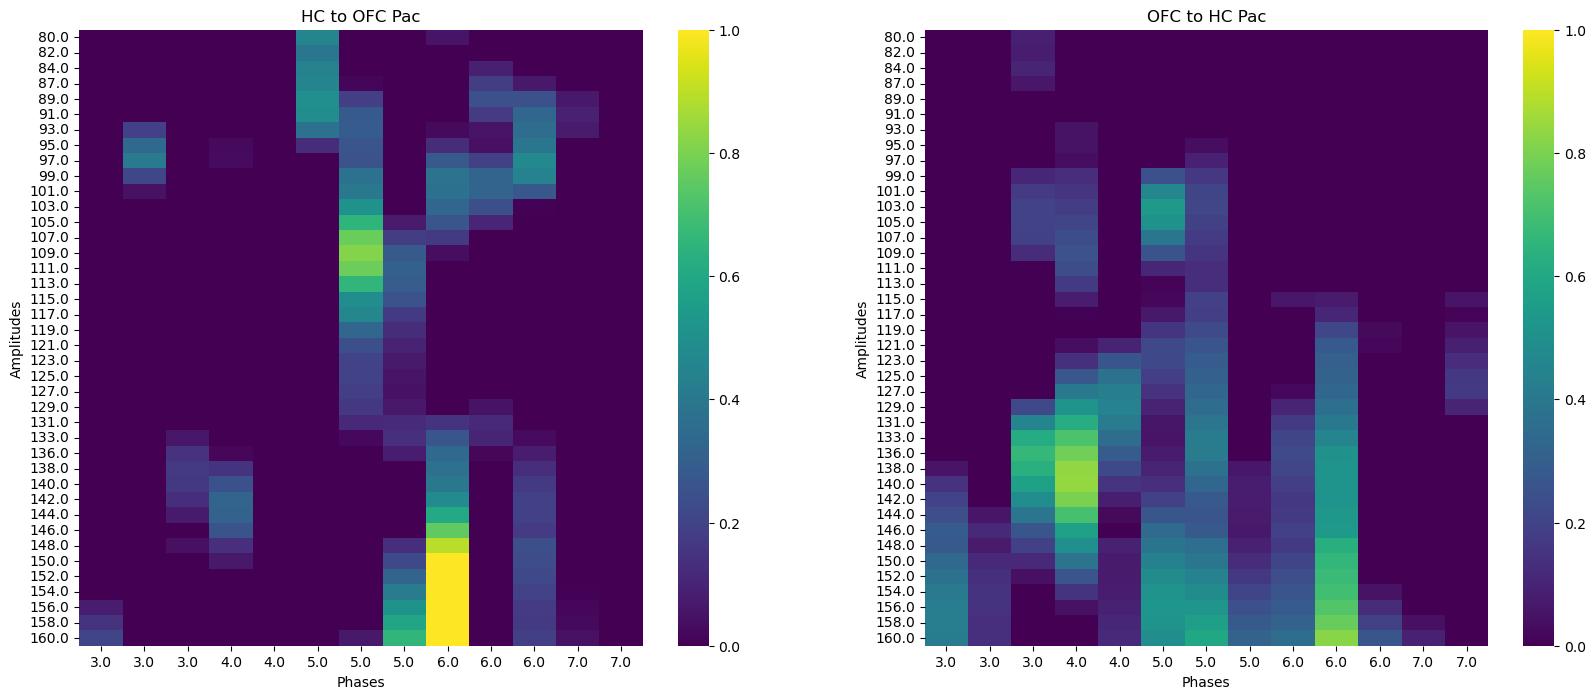

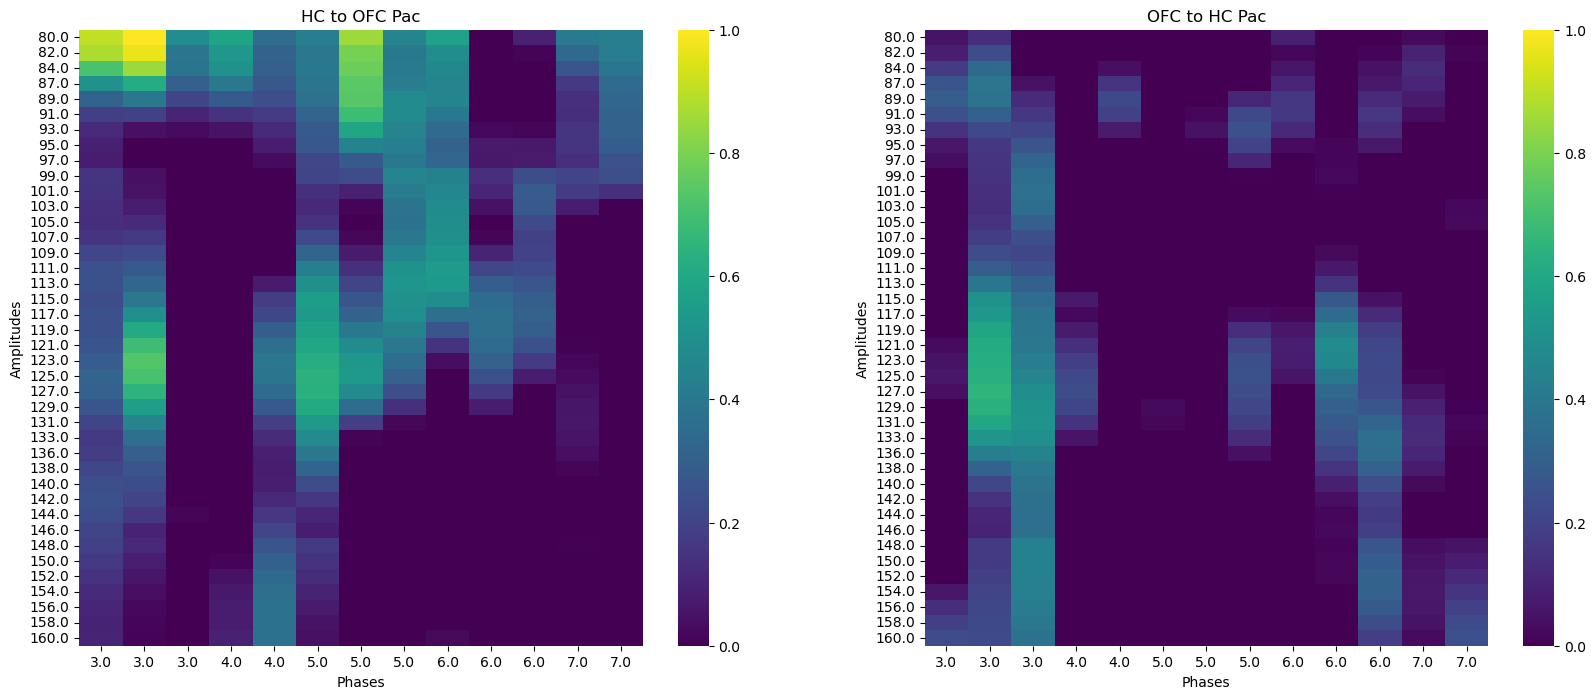

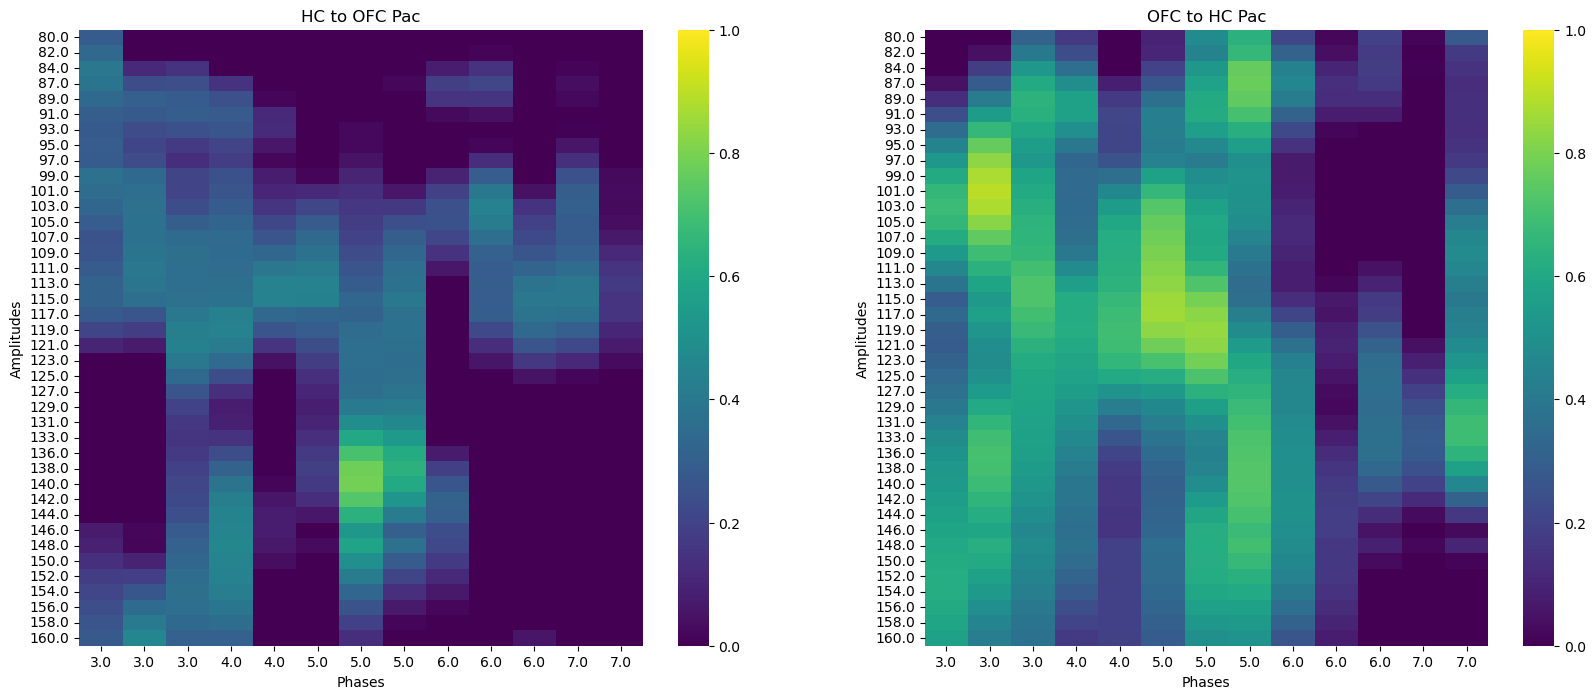

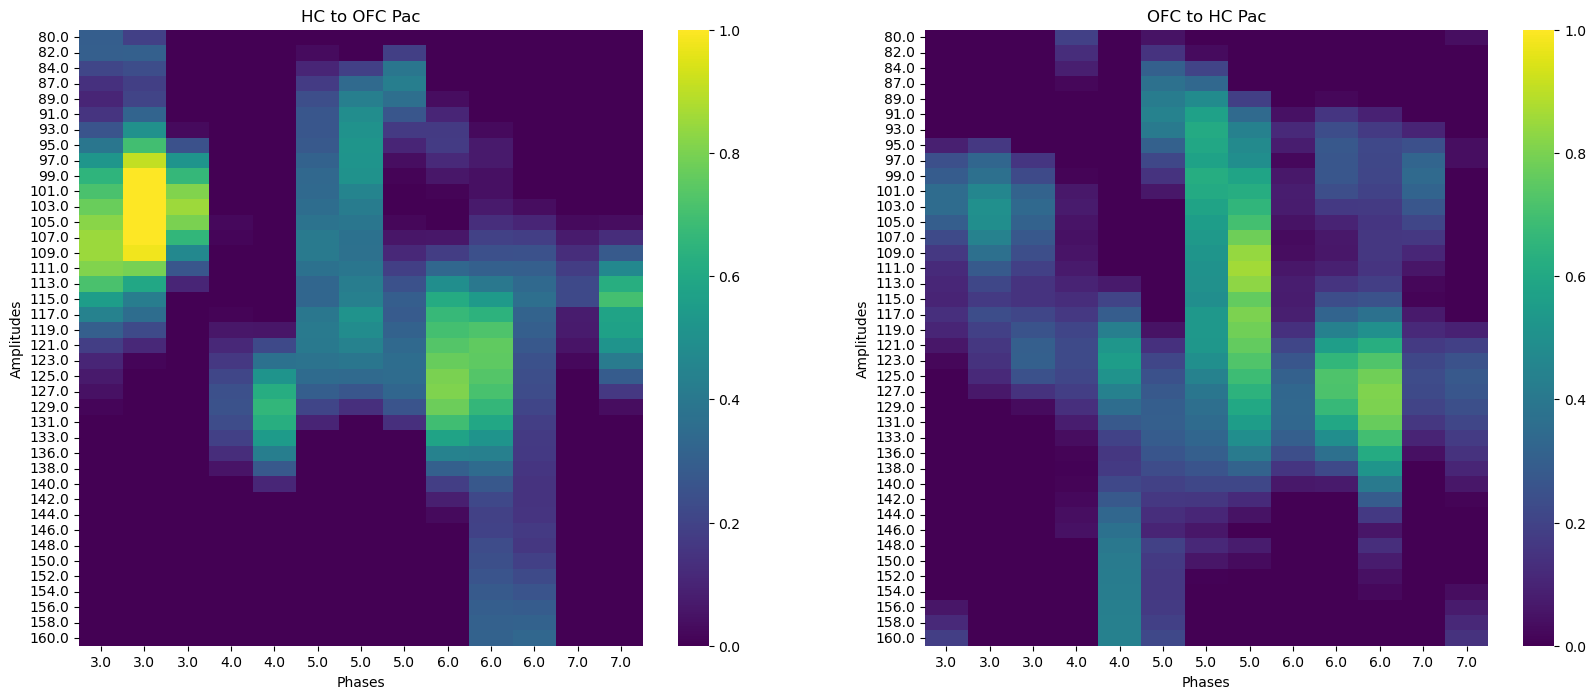

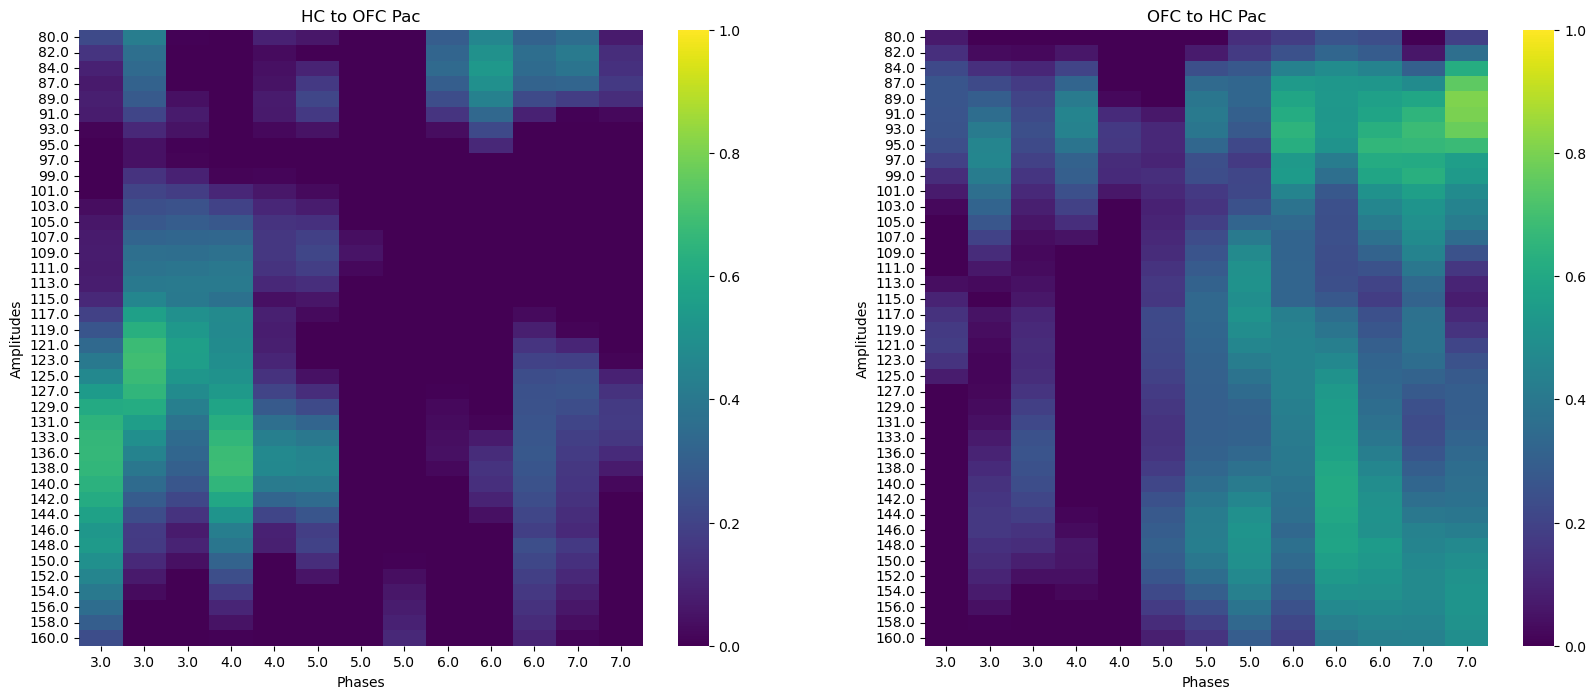

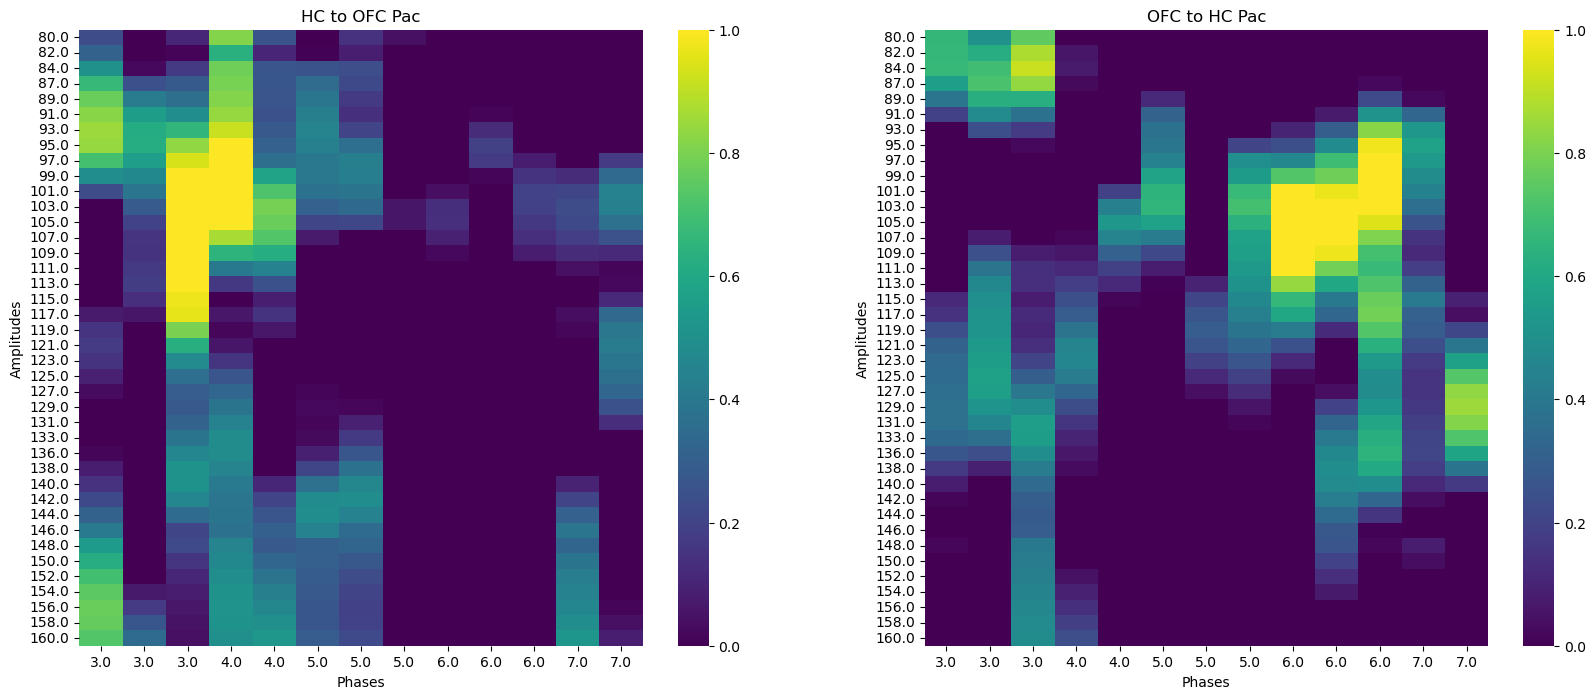

In [105]:
for i in range(7):
    plot_both_pacs(to_ofc_sub_pac[:, :, i], from_ofc_sub_pac[:, :, i], 'HC to OFC Pac', 'OFC to HC Pac', upper_v = 1)

### Amygdala

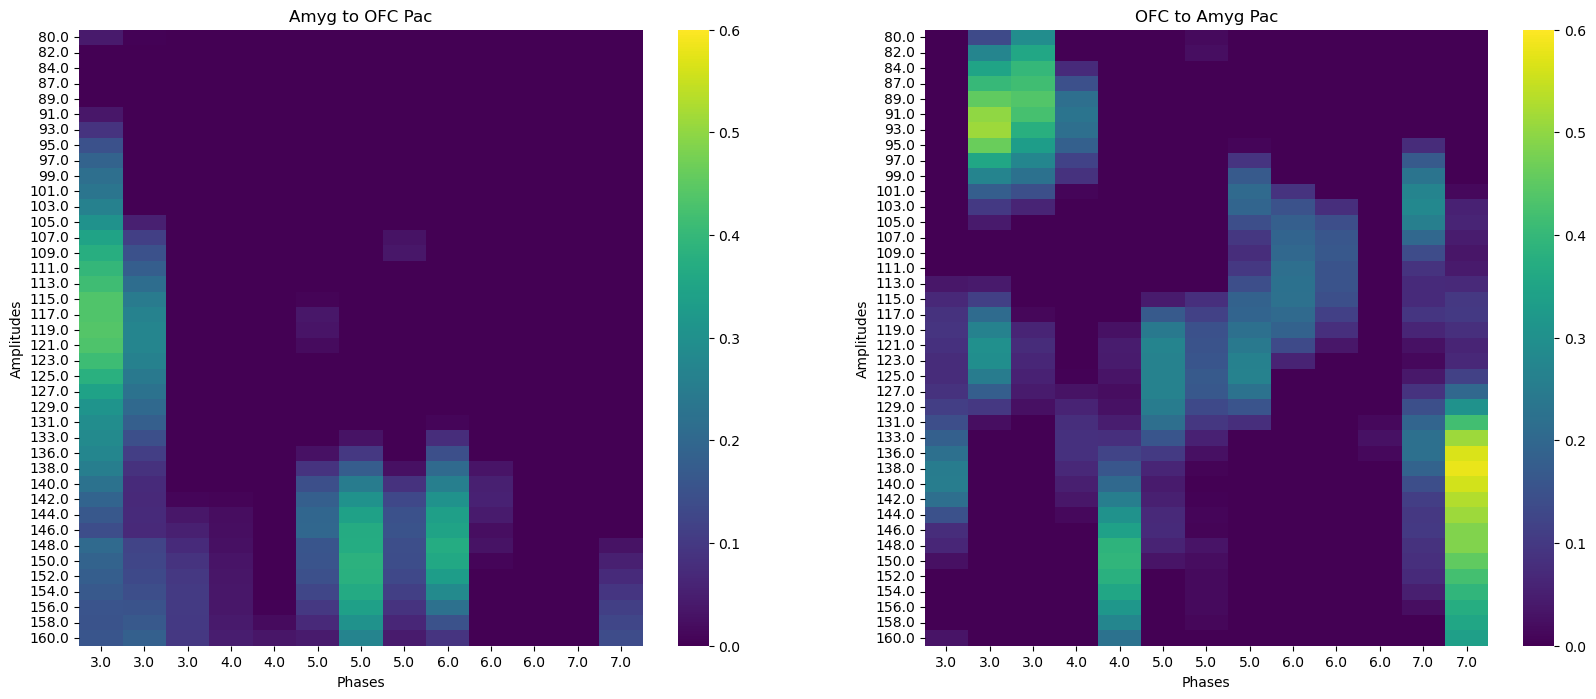

In [106]:
to_ofc_sub_pac = get_average_roi_to_ofc_pair_pac('ofc_amyg')
from_ofc_sub_pac = get_average_ofc_to_roi_pair_pac('ofc_amyg')

to_ofc_average_pac = to_ofc_sub_pac.mean(-1)
from_ofc_average_pac = from_ofc_sub_pac.mean(-1)

plot_both_pacs(to_ofc_average_pac, from_ofc_average_pac, 'Amyg to OFC Pac', 'OFC to Amyg Pac', upper_v = 0.6)

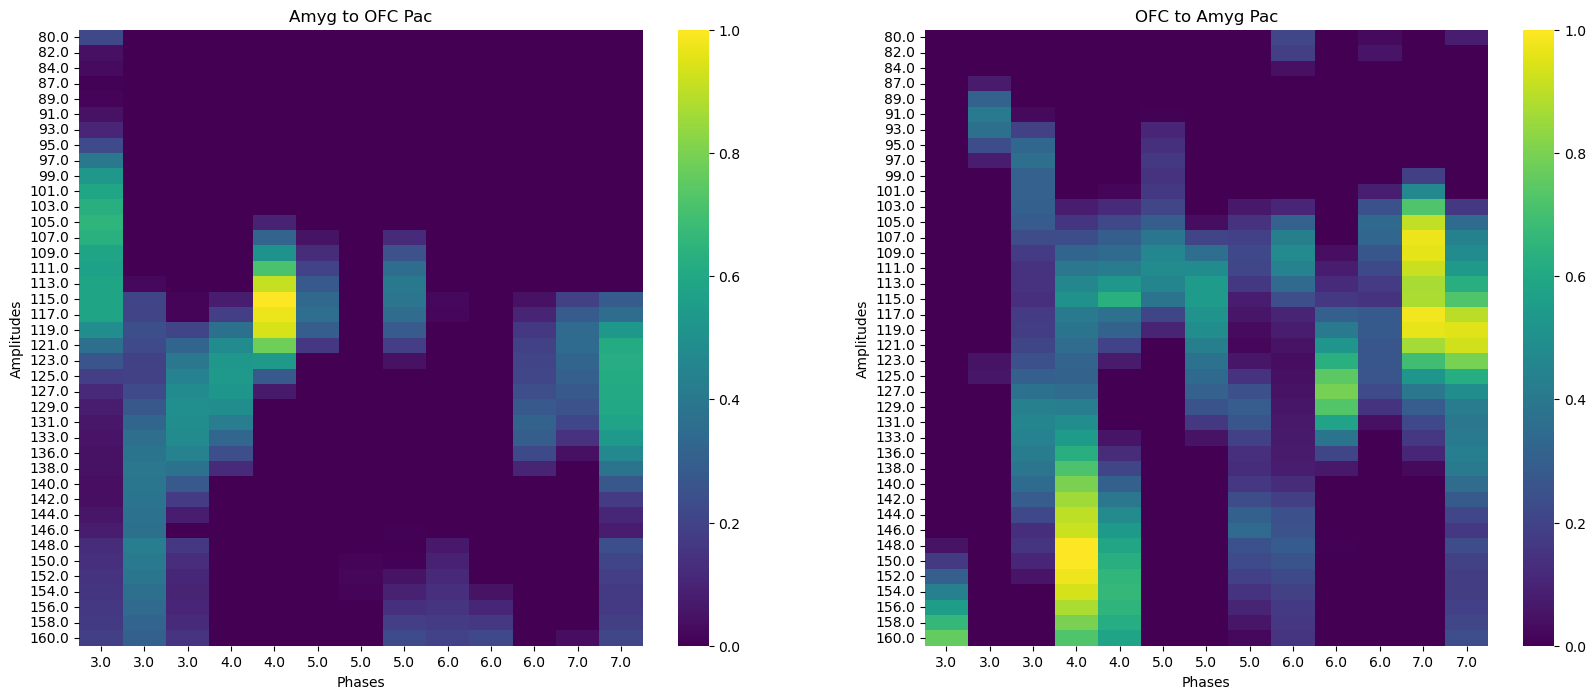

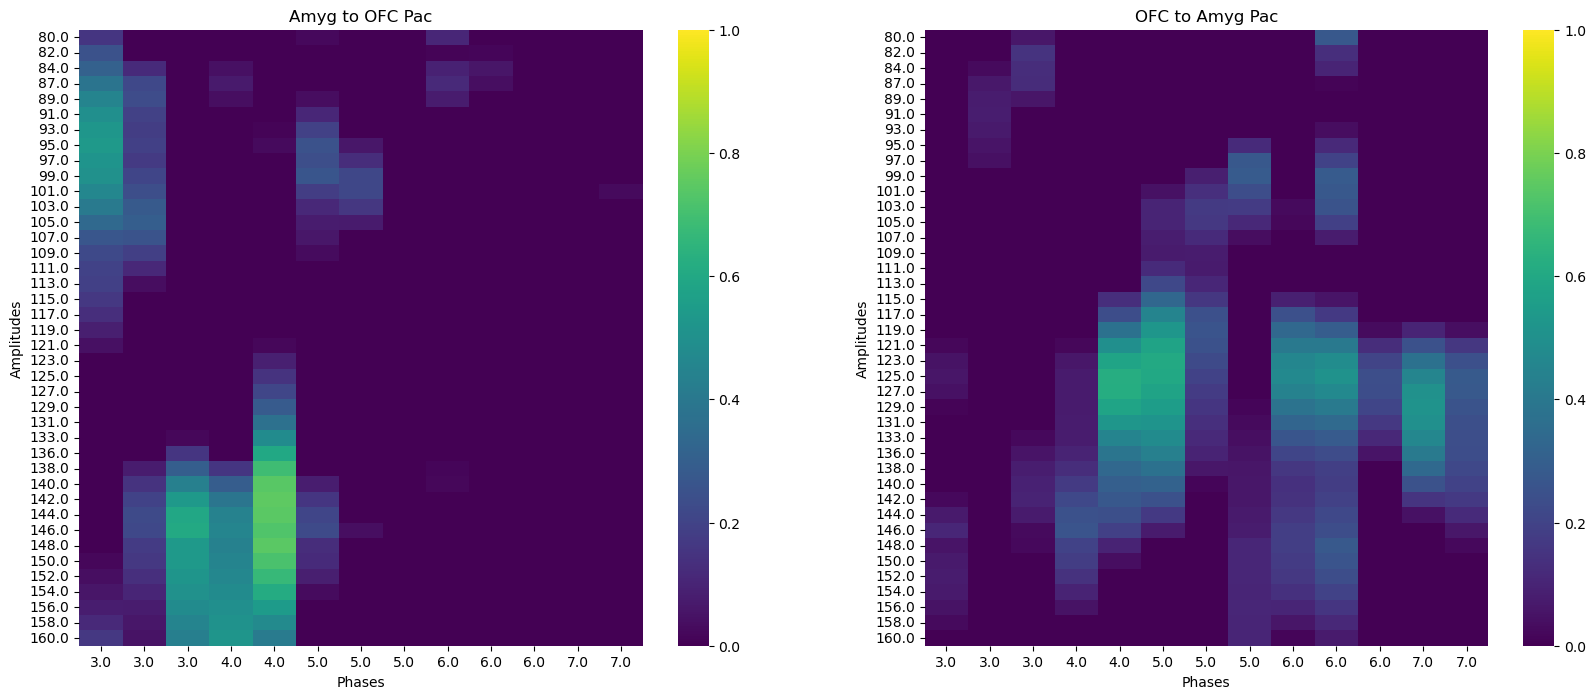

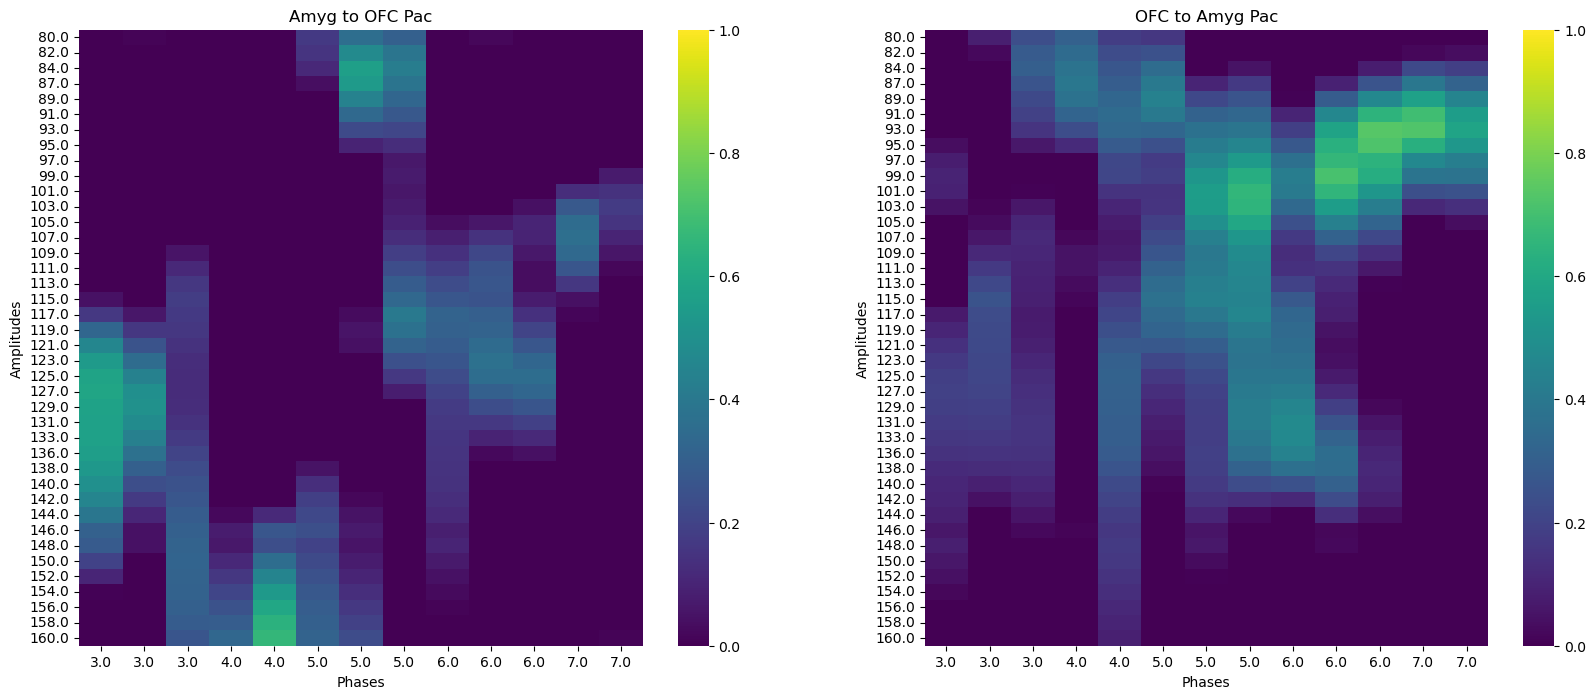

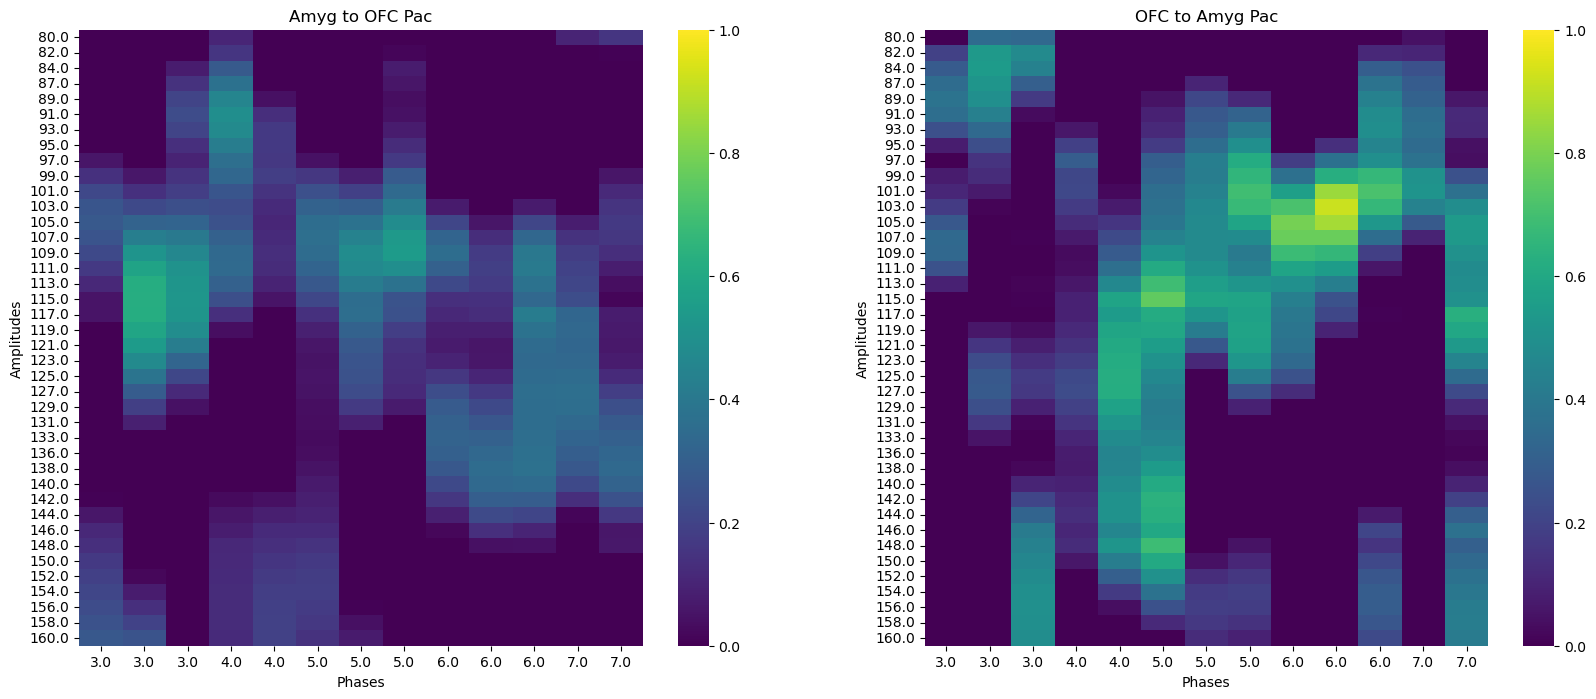

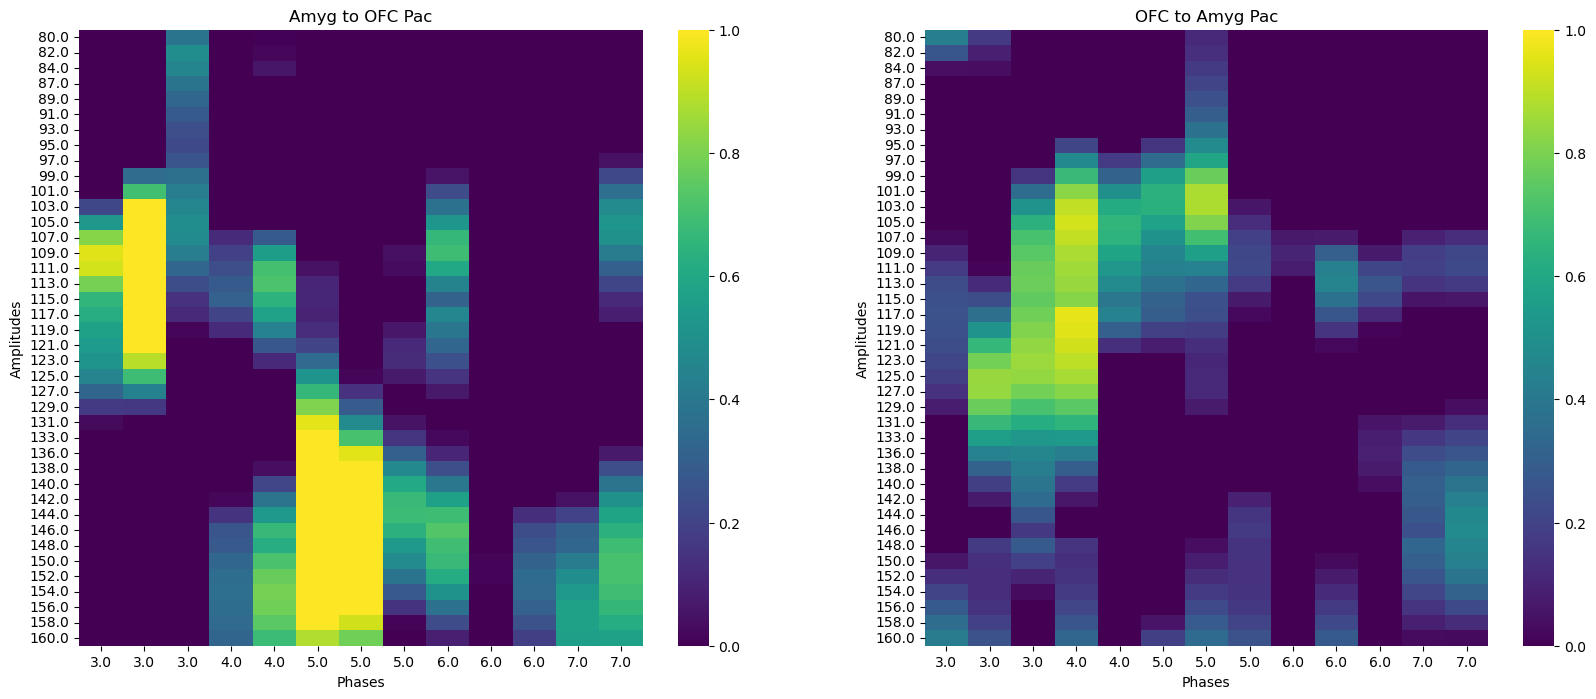

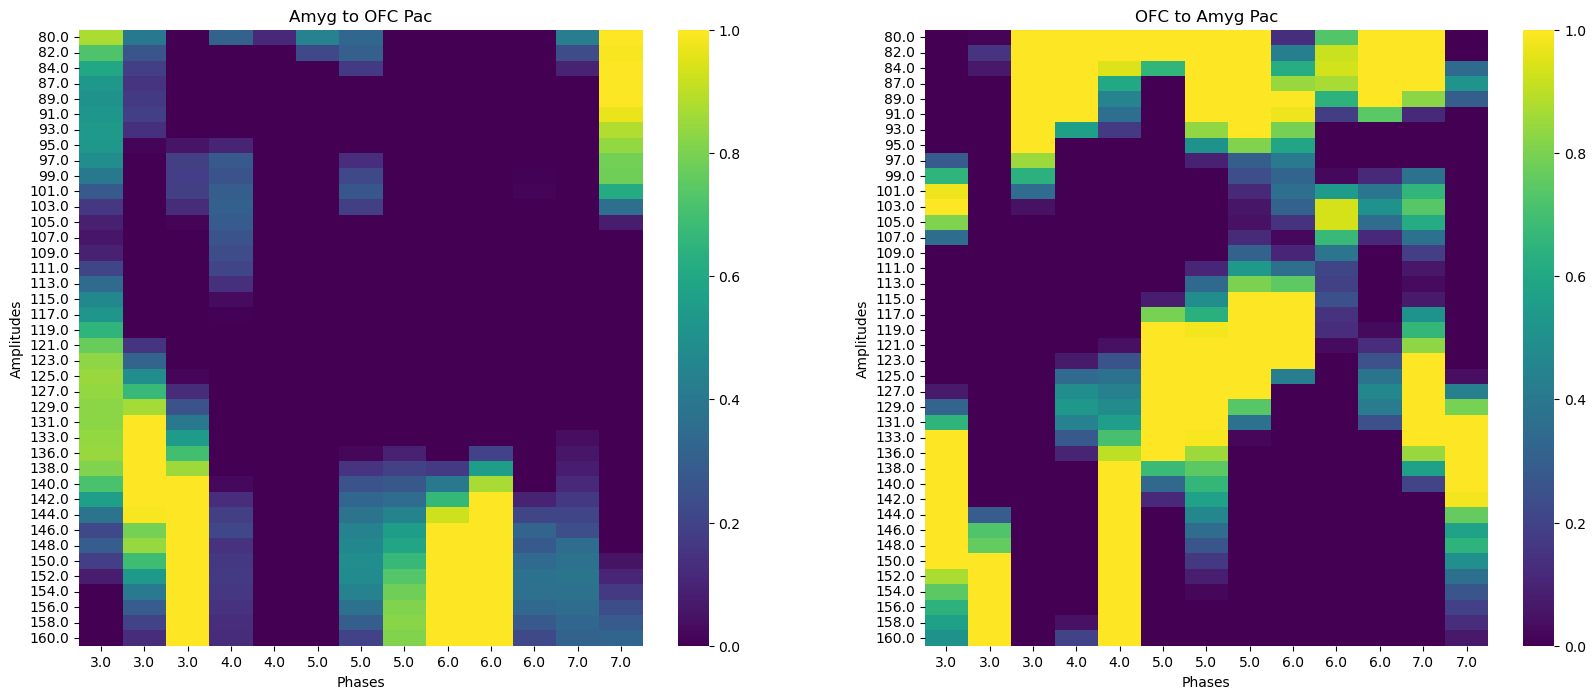

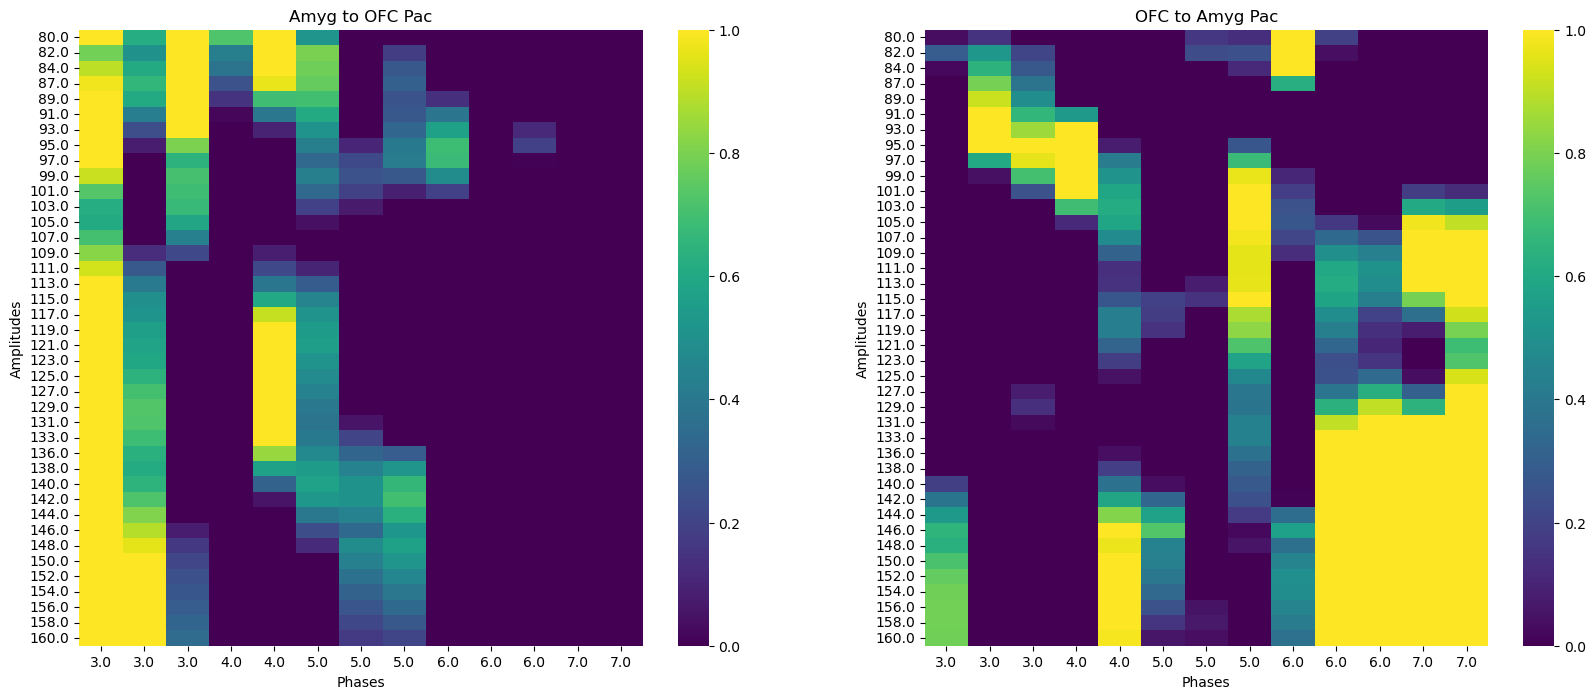

In [107]:
for i in range(7):
    plot_both_pacs(to_ofc_sub_pac[:, :, i], from_ofc_sub_pac[:, :, i], 'Amyg to OFC Pac', 'OFC to Amyg Pac', upper_v = 1)